<div style="display: flex;text-align: left; ">
<!--     <h1>Predicting TripAdvisor Review Sentiment</h1> -->
    <div style="margin-right: 5px; margin-left: -29px">
        <img src="images/tripadvisor.jpg" alt="Alt text" width="100"/>
    </div>
    <h1>Predicting Unsatisfied Guests from TripAdvisor Reviews</h1>
</div>


**Author**: Albane Colmenares <br>
**Date**: January 4th, 2024 <br>
___________________________________________________________________________

### Table of Content
**1. [Overview](#overview)**<br>
**2. [Business Understanding](#business_understanding)**<br>
**3. [Data Understanding](#data_understanding)**<br>
**4. [Data Preparation](#data_preparation)**<br>
**5. [Modeling](#modeling)**<br>
**6. [Evaluation](#evaluation)**<br>
**7. [Findings & Recommendations](#findings_n_recommendations)**<br>
**8. [Limits & Next Steps](#limits_n_next_steps)**<br>


<a id='overview'></a>

## 1. Overview

This notebook examines reviews about hotels from guests who stayed there and predicts whether the sentiment of reviews is positive or negative. <br>
The organization of this notebook follows the CRoss Industry Standard Process for Data Mining (CRISP-DM) is a process model that serves as the base for a data science process.


<a id='business_understanding'></a>

## 2. Business Understanding

The increasing significance of online reputation and social media in the hospitality industry has become integral to a hotel's operational and financial success. The [report](https://ecornell-impact.cornell.edu/the-impact-of-social-media-on-lodging-performance/) from Cornell's Center for Hospitality Research highlights the rising trend of consumers relying on online reviews during hotel bookings. The study reveals the link between a hotel's online reputation and its pricing, occupancy rates and revenue performance. 

Recognizing the challenges faced by hotels in managing online reputation, a **new branch of TripAdvisor** is now dedicated to supporting hotels in identifying and **improving unsatisfied guests' experience** before they leave. 
<br>Hyatt's corporate director of guest experience hired us to drive the strategy. 

Through real-time guest reviews and a sophisticated algorithm, the platform alerts general managers about guests requiring immediate attention. The goal is to enable proactive measures to enhance satisfaction. This innovative tool, backed by an analysis of over 20,000 real guest reviews, also offers tailored recommendations for improvement upon implementation, aligning with the goal of turning [detractors](https://www.datasciencecentral.com/what-is-a-good-net-promoter-score-for-the-hotel-resort-industry/) into promoters. 


<u>The Task</u>

Quickly and durably enhance guest satisfaction and improve online reputation

<u>Objectives</u>

1. improve guest experience 
    * by offering customized recommendations targeting areas that historically caused guest complaints 

2. increase online reputation 
    * reduce the share of negative reviews
    * by identifying unsatisfied guests through real-time reviews, providing an opportunity to create a better experience

<u>Target Audience</u>

Hyatt's corporate director of guest experience


<a id='data_understanding'></a>

## 3. Data Understanding

* **Data Source**

The data is hosted on [Kaggle](https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews) and is provided by *LARXEL*. 

In order to access the file, access the data source through the link provided and click on the `download` button at the top right corner. This will download a zipped folder. The below code unzips it upon loading the data. 

The dataset contains about twenty thousand reviews collected from a hotel's TripAdvisor page. Each review is assigned a rating from 1 to 5, 1 being the lowest (negative review), 5 being the highest (positive review).

* **Features**

Prior to preprocessing, the columns are: 

* `Review`: the actual review's record
* `Rating`: a number from 1 to 5, given by the guest at the time of the review

* **Target**

The target will be identifying negative reviews. It will be created based on the `Rating` column, and will be named `Sentiment`. Based on a given set of reviews, I will predict if the review's sentiment was negative. To be more precise, it will be identified as `detractors`. This term is defined by the metric measuring online reputation: Net Promoter Score. 

More on NPS below.

* **Loading the data**

In [1]:
# Importing the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
import nltk

%matplotlib inline

The text file is encoded using Latin-1 encoding - and is open as is. Several encodings were tried to ensure the right one matched: utf-8, utf-16, ascii for example.

In [2]:
# Loading dataset and saving it as raw_df
raw_df = pd.read_csv('data/tripadvisor_hotel_reviews.csv.zip', compression="zip", encoding='latin-1')

In [3]:
# Inspecting the first 5 rows of the DataFrame
raw_df.head()

Review  Rating
0  nice hotel expensive parking got good deal sta...       4
1  ok nothing special charge diamond member hilto...       2
2  nice rooms not 4* experience hotel monaco seat...       3
3  unique, great stay, wonderful time hotel monac...       5
4  great stay great stay, went seahawk game aweso...       5

In [4]:
# Printing the number of rows and columns in the dataset
print(f'The dataset has {len(raw_df)} rows and {len(raw_df.columns)} columns.' )

The dataset has 20491 rows and 2 columns.


In [5]:
# Inspecting the number of reviews referring to each rating
raw_df['Rating'].value_counts()

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

In [6]:
# Inspecting the number of reviews referring to each rating
raw_df['Rating'].value_counts(normalize=True)

5    0.441853
4    0.294715
3    0.106583
2    0.087502
1    0.069348
Name: Rating, dtype: float64

There is a clear majority of reviews with a rating of 5: over 44% of them while all other ratings are inequally distributed. The dataset is highly imbalanced. I will review whether grouping them as a binary classification can address the issue.  


<a id='data_preparation'></a>

## 4. Data Preparation

## 4: 1- <u>Data Cleaning</u>

For a better readability of the reviews, the column width will be increased.

This [link](https://www.tripadvisor.com/ShowTopic-g1-i12105-k11476502-What_is_the_maximum_character_limit_on_a_review-Tripadvisor_Support.html) from TripAdvisor suggests the maximum number of characters for reviews is 20,000. I will set the limit to 20,000 to ensure all words are encounted for.  

In [7]:
# Increasing column width
pd.set_option('max_colwidth', 20000)

In [8]:
# Inspecting the first 5 rows of the DataFrame now that there no longer is a limitted width
raw_df.head()

Review  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,     
1  ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, start booked suite paid extra website description not, suite bedroom bathroom standard hotel room, took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast, got kidding, embassy suits sitting room bathroom bedroom unlike kimpton calls suite, 5 day stay offer correct false advertising, send kimpton preferred guest website email asking failure provide suite advertised website reservation description furnished hard copy reservation printout website desk manager duty did not reply solution, send email trip guest survey did not follow email mail, guess tell concerned guest.the staff ranged indifferent not helpful, asked desk good breakfast spots neighborhood hood told no hotels, gee best breakfast spots seattle 1/2 block away convenient hotel does not know exist, arrived late night 11 pm inside run bellman busy chating cell phone help bags.prior arrival emailed hotel inform 20th anniversary half really picky wanted make sure good, got nice email saying like deliver bottle champagne chocolate covered strawberries room arrival celebrate, told needed foam pillows, arrival no champagne strawberries no foam pillows great room view alley high rise building good not better housekeeping staff cleaner room property, impressed left morning shopping room got short trips 2 hours, beds comfortable.not good ac-heat control 4 x 4 inch screen bring green shine directly eyes night, light sensitive tape controls.this not 4 start hotel clean business hotel super high rates, better chain hotels seattle,     
2                                                                                                                                                                                                                                                                        nice rooms not 4* experience hotel monaco seattle good hotel n't 4* level.positives large bathroom mediterranean suite comfortable bed pillowsattentive housekeeping staffnegatives ac unit malfunctioned stay desk disorganized, missed 3 separate wakeup calls, concierge busy hard touch, did n't provide guidance special requests.tv har

Despite increasing the column width, some reviews are not finished. This was verified inside the raw data, which confirms the reviews were not provided entirely. 

### 4. a) Copying the raw data

In order to keep the raw data as it is in case it needs to be accessed in the future, an exact copy of the dataset will be made. The new DataFrame `df` contains the same columns:
* `Review`
* `Rating`

In [9]:
# Making a copy of the raw DataFrame to modify it
df = raw_df.copy()

In [10]:
# Verifying the changes applied  
df.head()

Review  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,     
1  ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, start booked suite paid extra website description not, suite bedroom bathroom standard hotel room, took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast, got kidding, embassy suits sitting room bathroom bedroom unlike kimpton calls suite, 5 day stay offer correct false advertising, send kimpton preferred guest website email asking failure provide suite advertised website reservation description furnished hard copy reservation printout website desk manager duty did not reply solution, send email trip guest survey did not follow email mail, guess tell concerned guest.the staff ranged indifferent not helpful, asked desk good breakfast spots neighborhood hood told no hotels, gee best breakfast spots seattle 1/2 block away convenient hotel does not know exist, arrived late night 11 pm inside run bellman busy chating cell phone help bags.prior arrival emailed hotel inform 20th anniversary half really picky wanted make sure good, got nice email saying like deliver bottle champagne chocolate covered strawberries room arrival celebrate, told needed foam pillows, arrival no champagne strawberries no foam pillows great room view alley high rise building good not better housekeeping staff cleaner room property, impressed left morning shopping room got short trips 2 hours, beds comfortable.not good ac-heat control 4 x 4 inch screen bring green shine directly eyes night, light sensitive tape controls.this not 4 start hotel clean business hotel super high rates, better chain hotels seattle,     
2                                                                                                                                                                                                                                                                        nice rooms not 4* experience hotel monaco seattle good hotel n't 4* level.positives large bathroom mediterranean suite comfortable bed pillowsattentive housekeeping staffnegatives ac unit malfunctioned stay desk disorganized, missed 3 separate wakeup calls, concierge busy hard touch, did n't provide guidance special requests.tv har

### 4. b) Missing data

In the next section, the missing values are inspected. 
<br>
None of the two columns have null data, no modification is necessary. 

In [11]:
# Looking for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


### 4. c) Handling duplicates

No duplicate rows were identified. No changes are necessary. 

In [12]:
# How many rows were duplicates
print(str(len(df[df.duplicated()])) + f' duplicate rows were identified.')

0 duplicate rows were identified.


In [13]:
# Verifying there are no duplicate rows
df[df.duplicated()]

Empty DataFrame
Columns: [Review, Rating]
Index: []

### 4. d) Categorizing the ratings into a binary classification

* **Sentiment**

Five sentiment categories are described, which could be grouped in two: detractors and not_detractors. 
<br>Let's first review this assumption that the rating of 5 corresponds to a high positive review. 

In [14]:
# Filtering on the first 5 reviews with a rating of 5
df[df['Rating'] == 5].head()

Review  \
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           unique, great stay, wonderful time hotel monaco, location excellent short stroll main downtown shopping area, pet friendly room showed no signs animal hair smells, monaco suite sleeping area big striped curtains pulled closed nice touch felt cosy, goldfish named brandi enjoyed, did n't partake free wine coffee/tea service lobby thought great feature, great staff friendly, free wireless internet hotel worked suite 2 laptops, decor lovely eclectic mix pattens color palatte, animal print bathrobes feel like rock stars, nice did n't look like sterile chain hotel hotel personality excellent stay,     
4  great stay great stay, went seahawk game awesome, downfall view building did n't complain, room huge staff helpful, booked hotels website seahawk package, no charge parking got voucher taxi, problem taxi driver did n't want accept voucher barely spoke english, funny thing speak arabic called started making comments girlfriend cell phone buddy, took second realize just said fact speak language face priceless, ass told, said large city, told head doorman issue called cab company promply answer did n't, apologized offered pay taxi, bucks 2 miles stadium, game plan taxi return going humpin, great walk did n't mind, right christmas wonderful lights, homeless stowed away building entrances leave, police presence not greatest area stadium, activities 7 blocks pike street waterfront great coffee shops way, hotel mantained foyer awesome, wine tasting available evening, best dog, taking st. bernard time family, safes hotel located service desk room, bathroom huge jetted tub huge, funny house keeping walked girlfriend getting dressed, did n't hear knock doing turn service, screamed girlfriend screams hit floor laughing, started talking spanish worked, place recommend price, check online deals just good not better, besite contains deals vouchers travel websites n't tell,     
5                                                                                                                                                                                                                                                                                         love monaco staff husband stayed hotel crazy weekend attending memorial service best friend husband celebrating 12th wedding anniversary, talk mixed emotions, booked suite hotel monte carlos, loaned beautiful fan-tanned goldfish named joliet weekend visited dogs worked desk human companions, room decorated nicely couch used pillows, l'occitane bath amenities welcome sight, room quiet peaceful, wireless internet access wonderful server went morning leaving problems printing boarding passes, afternoon reception serves oenophile-satisfying wine australia scrumptious cookies, restaurant closed renovation stay finally ate food good drinks better, word caution restaurant larger person not sit booths wo n't fit, 5'6 125 lbs husband 5'9 175. table smack-against stomach couple inches space mighty uncomfortable patron larger pregnant, bad design opinion place decorated funky welcoming way metal wood handblown glass light fixtures expect seattle capital glass art industry, definitely stay reason,     
6                                                                                                                             

At first glance, the reviews indicate how great the stay was, how comfortable the rooms were and provide compliments about the building, decor and neighborhood. This confirms 5 star reviews are positive. 

I will inspect the 1 star review to confirm that these are negative before finally creating the sentiment column. 

In [15]:
# Filtering on the first 5 reviews with a rating of 5
df[df['Rating'] == 1].head()

Review  \
15  horrible customer service hotel stay february 3rd 4th 2007my friend picked hotel monaco appealing website online package included champagne late checkout 3 free valet gift spa weekend, friend checked room hours earlier came later, pulled valet young man just stood, asked valet open said, pull bags didn__Ã_Ã©_ offer help, got garment bag suitcase came car key room number says not valet, car park car street pull, left key working asked valet park car gets, went room fine bottle champagne oil lotion gift spa, dressed went came got bed noticed blood drops pillows sheets pillows, disgusted just unbelievable, called desk sent somebody 20 minutes later, swapped sheets left apologizing, sunday morning called desk speak management sheets aggravated rude, apparently no manager kind supervisor weekend wait monday morning, young man spoke said cover food adding person changed sheets said fresh blood rude tone, checkout 3pm package booked, 12 1:30 staff maids tried walk room opening door apologizing closing, people called saying check 12 remind package, finally packed things went downstairs check, quickly signed paper took, way took closer look room, unfortunately covered food offered charged valet, called desk ask charges lady answered snapped saying aware problem experienced monday like told earlier, life treated like hotel, not sure hotel constantly problems lucky ones stay recommend anybody know,     
32                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 noise airconditioner-a standard, arranged stay travel agency unfortunately warwick seattle hotel dissapointment trip, 3 night stay warwick changed 3 rooms, starting minute stay hotel personnel didn`t make feel like guest like intruder, reluctant help solve complaints, hotel right downtown 5 minutes really good restaurants like good thing, availability room offered 2nd floor window directly opening car parking level, changed room, 3 rooms loud sound coming air conditioner/ heating unbelievable hotel, hotel personnel told standard noise rooms, tried avoid using night order sleep possible watching tv loudly,     
40                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          bad choice, booked hotel hot wire called immediately requesting nonsmoking room king bed room away elevator/ice.the person spoke pleasant stated not guarantee requests honored make note reservation, check-in person desk rude said no special request noted reservation card andstated no king beds way reservation stuck 2 double beds, located directly accross elevator ice, nonsmoking, no elevator parking garage hotel, warwick mats garage filthy stairwells, hotel faces 4th smells urine, carpets registration elevator area need cleaning, upholstery curtains room needed cleaning andpressing sig

Indeed, the first word of the first 1 star review indicate how *horrible* the customer service was. The ranking from 1 to 5 is confirmed to be from low to high.   

* **NPS Score**

The Net Promoter Score (NPS) is a metric used to measure customer satisfaction and loyalty with a hotel, (or more generally a product, service, or company). It is based on the question: "How likely is it that you would recommend our *hotel*? 
The responses can be measured on a scale from 0 to 10 or in our case: 1 to 5. 

[![notext](images/nps-5-scale.png)](https://textexpander.com/blog/how-to-calculate-nps)

According to the 5 point [NPS Scale](https://www.surveysensum.com/blog/11-point-and-5-point-nps-scale#:~:text=5%2Dpoint%20NPS%20Scale,-Similar%20to%20the&text=The%20respondents%20on%20the%205,why%20it%20is%20not%20recommended.):
1. Promoters rate 5 star reviews 
2. Passive customers rate 4 stars
3. Detractors rate from 1 to 3 star reviews


This indicates that the customers who rank a hotel from 1 to 3 star reviews may really damage a hotel's online reputation and negatively influence other guests in their willingness to book your hotel. 


NPS is calculated as:
- the percentage of promoters (guests who highly recommend the hotel: 5 star reviews)
- **minus** the percantage of detractors (guests who do not recommend the hotel: 1 to 3 star reviews)



As a consequence, I will categorize the guests who gave 1 to 3 star reviews as `detractors` and the others as `not_detractors`.

As a starting point the NPS for this hotel chain is calculated. 

In [16]:
# Reminding the current percentage for each star reviews given
df['Rating'].value_counts(normalize=True)

# Storing values for promoters and detractors 
promoters = df['Rating'].value_counts(normalize=True).get(5, 0)
detractors = df['Rating'].value_counts(normalize=True).get(1, 0) + df['Rating'].value_counts(normalize=True).get(2, 0) + df['Rating'].value_counts(normalize=True).get(3, 0)

nps_score = promoters - detractors 

In [17]:
# Calculating the current NPS score
nps_score = promoters - detractors 
print(f'Your NPS Score is {nps_score:.2%}')

Your NPS Score is 17.84%


If a hotel was to decrease the number of detractors by only 10%, the new NPS score for your hotel chain would be:

In [18]:
# Calculating the potential percentage of detractors 
potential_detractors = detractors * 0.9

In [19]:
# Calculating the potential NPS Score
potential_nps_score = promoters - potential_detractors 
print(f'Your potential NPS Score could be {potential_nps_score:.2%}')

Your potential NPS Score could be 20.48%


In [20]:
# Calculating the growth in NPS Score after reducing detractors by 10%
growth_in_nps = (potential_nps_score - nps_score ) / nps_score
print(f'By decreasing only the percentage of detractors in your hotels by only 10%, your online reputation score - or NPS could increase by {growth_in_nps:.2%}!')

By decreasing only the percentage of detractors in your hotels by only 10%, your online reputation score - or NPS could increase by 14.76%!


I will create this new category under the column `Sentiment`.

In [21]:
# Creating the column sentiment
df['Sentiment'] = df['Rating'].apply(lambda x: 'detractors' if x in [1, 2, 3] else 'not_detractors')

In [22]:
# Verifying the column was created 
df.head()

Review  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,     
1  ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, start booked suite paid extra website description not, suite bedroom bathroom standard hotel room, took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast, got kidding, embassy suits sitting room bathroom bedroom unlike kimpton calls suite, 5 day stay offer correct false advertising, send kimpton preferred guest website email asking failure provide suite advertised website reservation description furnished hard copy reservation printout website desk manager duty did not reply solution, send email trip guest survey did not follow email mail, guess tell concerned guest.the staff ranged indifferent not helpful, asked desk good breakfast spots neighborhood hood told no hotels, gee best breakfast spots seattle 1/2 block away convenient hotel does not know exist, arrived late night 11 pm inside run bellman busy chating cell phone help bags.prior arrival emailed hotel inform 20th anniversary half really picky wanted make sure good, got nice email saying like deliver bottle champagne chocolate covered strawberries room arrival celebrate, told needed foam pillows, arrival no champagne strawberries no foam pillows great room view alley high rise building good not better housekeeping staff cleaner room property, impressed left morning shopping room got short trips 2 hours, beds comfortable.not good ac-heat control 4 x 4 inch screen bring green shine directly eyes night, light sensitive tape controls.this not 4 start hotel clean business hotel super high rates, better chain hotels seattle,     
2                                                                                                                                                                                                                                                                        nice rooms not 4* experience hotel monaco seattle good hotel n't 4* level.positives large bathroom mediterranean suite comfortable bed pillowsattentive housekeeping staffnegatives ac unit malfunctioned stay desk disorganized, missed 3 separate wakeup calls, concierge busy hard touch, did n't provide guidance special requests.tv har

In [23]:
# Inspecting the new value_counts for the Sentiment category 
df['Sentiment'].value_counts()

not_detractors    15093
detractors         5398
Name: Sentiment, dtype: int64

In [24]:
# And in percentages
# Inspecting the new value_counts for the Sentiment category 
df['Sentiment'].value_counts(normalize=True)

not_detractors    0.736567
detractors        0.263433
Name: Sentiment, dtype: float64

The grouping also started addressing the class imbalance. Nevertheless, the dataset remains highly imbalanced.

I will visually represent the split of number of reviews. 

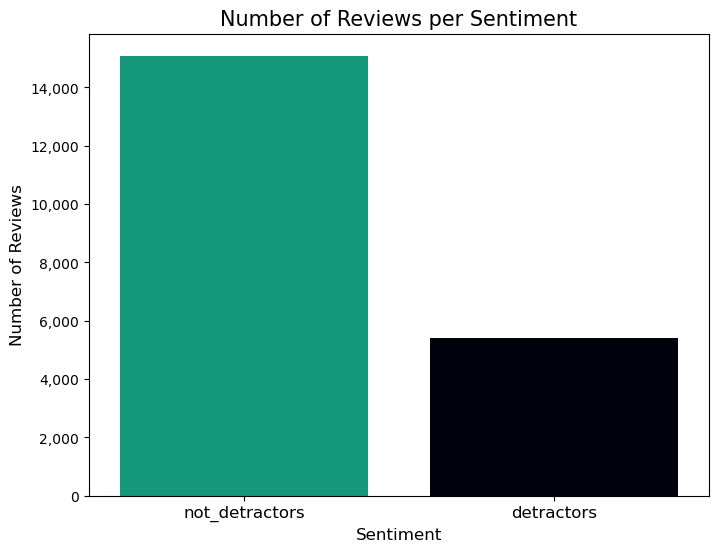

In [372]:
from matplotlib.ticker import FuncFormatter
# Creating a function to plot the number of reviews by sentiment

# Defining custom colors 
custom_colors = ['#00AF87', '#00000F']

def plot_sentiment_count(df, x, label_rotation):
    # Defining the figure
    fig, ax = plt.subplots(figsize=(8,6))
    
    # Plotting the count of reviews 
    sns.countplot(data=df, x=x, order=df[x].value_counts().index, palette=custom_colors)
    
    # Defining the labels and titles
    ax.set_xlabel(xlabel = 'Sentiment', fontsize=12)
    ax.set_ylabel(ylabel = 'Number of Reviews', fontsize=12)
    ax.set_title(f'Number of Reviews per Sentiment', fontsize=15)
    
    # Recording the sentiment values to use them as labels 
    sentiment_labels = df[x].unique()
    
    # Setting the x-axis tick labels to the sentiment labels 
    ax.set_xticks(range(len(sentiment_labels)))
    ax.set_xticklabels(labels=sentiment_labels, rotation=label_rotation, fontsize=12)
    
    
    # Formatting the y-axis labels to show thousands 
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{:,}'.format(int(x))))
    
     # Saving the plot as a PNG with a transparent background
    plt.savefig('images/reviews_per_sentiment.png', transparent=True)
    
    # Showing the plot
    plt.show()

    
plot_sentiment_count(df, 'Sentiment', 0)

### 4. e) Performing a Train-Test Split

The dataset is being divided into two separate subsets: a training set, and a testing (or validation) set. The validation set will allow to assess the performance of the model.

Two parameters are assigned when dividing the dataset:
* random_state=42
    * setting a random seed of 42 ensures that the data split is reproducible
* stratify=y
    * stratified sampling ensures the class distribution is maintained in both sets to address potential class imbalance issues

In [26]:
# Splitting df into X and y
X = df.drop('Sentiment', axis=1)
y = df['Sentiment']

In [27]:
# Performing a train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [28]:
# Inspecting the X_train data
X_train.head()

Review  \
1282                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           gem, pleasantly surprised accomondations helpful attentive staff need, breakfast good cookies, room lovely clean comfortable, room fronting bush street bit noisy did not away enjoyment nice boutique hotel, definitely stay time,     
10661                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           loved fita wife spent nights hotel fita march 2008. hotel staff fantastic helpful pleasant, recommend hotel traveling amsterdam.the hotel located minute walk van gogh rijks museums 10 minute walk leidsplein variety stores shops restaurants located.there tram stop directly hotel, easy access entire city, did walk fita way center city 30 minutes.beautiful accesible friendly definately travel fita wonderful amsterdam,     
17908                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 great modern hotel fantastic price stayed just night beginning april, alot reviews say bad area really did n't, literally 100m away nice redeveloped area 10min walk beach.me partner arrived late barcelona decided walk hotel bus station order barings, quite long walk 50mins roughly really great thing order sights tourists dont usually, arrived check quick painless room really really nice, fantastic modern design little extras want, order barcelona partner opted bus turistic, stop not far hotel goes virtually

In [29]:
# Inspecting the y_train data 
y_train.head()

1282     not_detractors
10661    not_detractors
17908    not_detractors
11685    not_detractors
9059         detractors
Name: Sentiment, dtype: object

* **Distribution of Target**

In [30]:
# Inspecting the distribution in the train data
y_train.value_counts(normalize=True)

not_detractors    0.736596
detractors        0.263404
Name: Sentiment, dtype: float64

In [31]:
# Inspecting the distribution in the test data
y_test.value_counts(normalize=True)

not_detractors    0.736483
detractors        0.263517
Name: Sentiment, dtype: float64

### 4. f) Encoding Target

In order to make predictions useable in calculations, I will encode the target: 
* 0 will replace `not_detractors`
* 1 will replace `detractors`

In [32]:
# Adding in labels for filtering before making any encoding
X_train['label'] = [y_train[val] for val in X_train.index]
X_train[:3]

Review  \
1282                                                                                                                                                                                                                                                                                                                                                                                                                                                            gem, pleasantly surprised accomondations helpful attentive staff need, breakfast good cookies, room lovely clean comfortable, room fronting bush street bit noisy did not away enjoyment nice boutique hotel, definitely stay time,     
10661                                                                                                                                                                                                                                                            loved fita wife spent nights hotel fita march 2008. hotel staff fantastic helpful pleasant, recommend hotel traveling amsterdam.the hotel located minute walk van gogh rijks museums 10 minute walk leidsplein variety stores shops restaurants located.there tram stop directly hotel, easy access entire city, did walk fita way center city 30 minutes.beautiful accesible friendly definately travel fita wonderful amsterdam,     
17908  great modern hotel fantastic price stayed just night beginning april, alot reviews say bad area really did n't, literally 100m away nice redeveloped area 10min walk beach.me partner arrived late barcelona decided walk hotel bus station order barings, quite long walk 50mins roughly really great thing order sights tourists dont usually, arrived check quick painless room really really nice, fantastic modern design little extras want, order barcelona partner opted bus turistic, stop not far hotel goes virtually, worth short visit.i wish spent longer hotel, wish swimming pool roof open, overall fantastic hotel price paid room dont distance centre transport options,     

       Rating           label  
1282        4  not_detractors  
10661       5  not_detractors  
17908       5  not_detractors

In [33]:
# Adding in labels for filtering before making any encoding
X_test['label'] = [y_test[val] for val in X_test.index]
X_test[:3]

Review  \
5372                                                        great location good hotel 1night stay recommend hotel want just night accommodation ahead day flight, sheraton stars mentioned architecture n't good hotel, stay night try solution night stay choose directly connected airport, pretty expensive cola 0,2l juices 4 eur price minibar pizza 12 eur ok person problems finding signs sheraton, problems big frankfurt airport.actually easy hotel airport directly connected airport terminal 1.from departure hall upstairs 2 pedestrian bridges whichconnect terminal hotel long distance trains 1 hall b near lufthansa 1 hall b c near american airlines follow signs hotel fernbahnhof long distance trains,     
16041  good airport hotel booked hotel early departures, nights room comfortable air-conditioning awful, quiet open windows, non-smoking floor smoking allowed restaurants common areas, arriving hotel shuttle available departing odd hour pay 30 taxi no taxi wants 5-minute trip, offer cab driver 10 did agree pay going rate hotel car 30, check-in problem odd hours staff speak english, hotel restaurants awful, chopsticks chinese taste good chinese food u.s. greasy, good wine list course problem smokers, good espresso desert bar outside chopsticks, best aspect hotel excellent travel desk manned efficient friendly lindsay day, ask eat town, english excellent, helped hotel merchant sold damaged item,     
15225                                                                                                                                                                                                                                                                         mandarin oriental good stayed mandarin oriental way australia europe, visit hotel frankly difficult convince ourselevs stay singapore, stayed club rooms time service provided club guests second none, club rooms need little updating clean modern expect class hotel, location superb access marina square mall subsequently malls linked, prices risen significantly recent years watch special deals bonus free nights, highly recommended,     

       Rating           label  
5372        4  not_detractors  
16041       2      detractors  
15225       5  not_detractors

In [34]:
# Inspecting y_train
print('Before')
print(y_train.value_counts())
print(y_train.value_counts(normalize=True))

# Encoding y_train 
y_train = y_train.apply(lambda x: 0 if x == 'not_detractors' else 1)

# Verifying it correctly applied
print('After')
print(y_train.value_counts())
print(y_train.value_counts(normalize=True))

Before
not_detractors    11320
detractors         4048
Name: Sentiment, dtype: int64
not_detractors    0.736596
detractors        0.263404
Name: Sentiment, dtype: float64
After
0    11320
1     4048
Name: Sentiment, dtype: int64
0    0.736596
1    0.263404
Name: Sentiment, dtype: float64


In [35]:
# Inspecting y_test
print('Before')
print(y_test.value_counts())
print(y_test.value_counts(normalize=True))

# Encoding y_test 
y_test = y_test.apply(lambda x: 0 if x == 'not_detractors' else 1)

# Verifying it correctly applied
print('After')
print(y_test.value_counts())
print(y_test.value_counts(normalize=True))

Before
not_detractors    3773
detractors        1350
Name: Sentiment, dtype: int64
not_detractors    0.736483
detractors        0.263517
Name: Sentiment, dtype: float64
After
0    3773
1    1350
Name: Sentiment, dtype: int64
0    0.736483
1    0.263517
Name: Sentiment, dtype: float64


* **Visually Inspecting Features on train and test samples**

In [36]:
X_test.head()

Review  \
5372                                                                                                                                   great location good hotel 1night stay recommend hotel want just night accommodation ahead day flight, sheraton stars mentioned architecture n't good hotel, stay night try solution night stay choose directly connected airport, pretty expensive cola 0,2l juices 4 eur price minibar pizza 12 eur ok person problems finding signs sheraton, problems big frankfurt airport.actually easy hotel airport directly connected airport terminal 1.from departure hall upstairs 2 pedestrian bridges whichconnect terminal hotel long distance trains 1 hall b near lufthansa 1 hall b c near american airlines follow signs hotel fernbahnhof long distance trains,     
16041                                                                             good airport hotel booked hotel early departures, nights room comfortable air-conditioning awful, quiet open windows, non-smoking floor smoking allowed restaurants common areas, arriving hotel shuttle available departing odd hour pay 30 taxi no taxi wants 5-minute trip, offer cab driver 10 did agree pay going rate hotel car 30, check-in problem odd hours staff speak english, hotel restaurants awful, chopsticks chinese taste good chinese food u.s. greasy, good wine list course problem smokers, good espresso desert bar outside chopsticks, best aspect hotel excellent travel desk manned efficient friendly lindsay day, ask eat town, english excellent, helped hotel merchant sold damaged item,     
15225                                                                                                                                                                                                                                                                                                                                                    mandarin oriental good stayed mandarin oriental way australia europe, visit hotel frankly difficult convince ourselevs stay singapore, stayed club rooms time service provided club guests second none, club rooms need little updating clean modern expect class hotel, location superb access marina square mall subsequently malls linked, prices risen significantly recent years watch special deals bonus free nights, highly recommended,     
18749                                                                                                                                                                                   great little hotel close forbidden city great little hotel ideal location, minutes walking forbidden city, located traditional beijing hutong neighborhood recommend going early morning late night walk neighborhood sense locals live daily lives, flying shanghai beijing beijing airport got shut heavy rains flight canceled, thought hotel charged night no proper cancellation, arrived morning told not charge missed night knew control.sunny yu speaks good english help tours great wall places interested.my room bit small clean, overall great hotel grateful generously not charging missed night,     
8348   anther great stay husband stayed 9 nights july 2008. second stay not disappointed, location hotel fantastic rooms nicely appointment great sea view, short walk sitges centre quick taxi ride, make quiet beaches good restaurants 5-mins walking distance hotel.this hotel definitely gets busier weekends spanish tourists coming weekend break uncomfortable, hotel let slightly minor irritations, breakfast superb meals poor, snack bar food terrible getting decent lunch hard, surprising considering brilliant restaurants area, needs improved, irritation lack uk tv channels, clearly does n't sitges watch tv day catch movies 9 days good, no uk channels cnn no movie ordering service, hotel clearly make money introducing service.all excellent choice sitges definitely return,     

       Rating           label  
5372        4  not_detractors  
16041     

In [37]:
# Making a sample of 3 records to display the full text of each
train_sample = X_train.sample(3, random_state=22)
train_sample['target'] = [y_train[val] for val in train_sample.index]
train_sample.style.set_properties(**{'text-align': 'left'})

In [38]:
# Making a sample of 3 records to display the full text of each
test_sample = X_test.sample(3, random_state=22)
test_sample['target'] = [y_test[val] for val in test_sample.index]
test_sample.style.set_properties(**{'text-align': 'left'})

## 4: 2- <u>Data Preprocessing & Exploratory Analysis</u>

The dataset is being divided into two separate subsets: a training set, and a testing (or validation) set. The validation set will allow to assess the performance of the model.

Two parameters are assigned when dividing the dataset:
* random_state=42
    * setting a random seed of 42 ensures that the data split is reproducible
* stratify=y
    * stratified sampling ensures the class distribution is maintained in both sets to address potential class imbalance issues

In order to preprocess the reviews, the following transformations were performed: 
* **Standardizing case**
    <br>This step was verified as it is important to ensure text is uniform and consistent. Nevertheless, no extra step was taken as text was already saved as lower case.

* **Character Encoding**
    <br> This was done to ensure consistent representation of text by transforming non-text characters into a normalized format, which will facilitate proper text processing, analysis, and model training.
    
* **Tokenizing**
    <br>Tokens of words were created. This was done with the `RegexpTokenizer` package from nltk.tokenize. This step will facilitate the conversion of word into a suitable form for analysis and modeling.  <br>
* **Stopwords** 
    <br>To focus on the data's theme, English stopwords were removed. Manual additions were made in this text's context, such as adding industry specific word (i.e. "hotel", "stay")  
* **Lemmatize** 
    <br> The `WordNetLemmatizer` package from nltk.stem.wordnet was used to reduce words to their base form, allowing a more accurate analysis
* **Frequency Distribution**
    <br>The `FreqDist` package was used to review in a dictionary-like output, the words and their frequencies
* **WordCloud**
    <br> The words' frequencies were represented visually thanks to the `WordCloud` package
* **Bigrams**
    <br> Bigrams were drawn to have a better understanding of the themes thanks to the `collocations` package and its BigramAssocMeasures
* **Mutual Information Scores**
    <br> Bigrams that occur more than 5 times were examined through `mutual information scores`

Before any transformation is done, a copy of the review column will be done so the original one can always be accessed. 

In [39]:
# Duplicating the column review
X_train['original_review'] = X_train['Review']

In [40]:
# Verifying the new column was correctly created
X_train.head()

Review  \
1282                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           gem, pleasantly surprised accomondations helpful attentive staff need, breakfast good cookies, room lovely clean comfortable, room fronting bush street bit noisy did not away enjoyment nice boutique hotel, definitely stay time,     
10661                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           loved fita wife spent nights hotel fita march 2008. hotel staff fantastic helpful pleasant, recommend hotel traveling amsterdam.the hotel located minute walk van gogh rijks museums 10 minute walk leidsplein variety stores shops restaurants located.there tram stop directly hotel, easy access entire city, did walk fita way center city 30 minutes.beautiful accesible friendly definately travel fita wonderful amsterdam,     
17908                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 great modern hotel fantastic price stayed just night beginning april, alot reviews say bad area really did n't, literally 100m away nice redeveloped area 10min walk beach.me partner arrived late barcelona decided walk hotel bus station order barings, quite long walk 50mins roughly really great thing order sights tourists dont usually, arrived check quick painless room really really nice, fantastic modern design little extras want, order barcelona partner opted bus turistic, stop not far hotel goes virtually

### 4: 2- a) Standardizing Case

I will glance at the first sample of review to get an idea of whether I need to standardize case. This step is important to ensure text is standardized, to prevent models from treating words with different cases as different ones

In [41]:
# Isolating the first review into windows_sample
sample_review = train_sample.iloc[1]['Review']
sample_review

"great hotel dominican republic booked trip paradisus punta cana march 2006 stayed hotel early september, websites reviewed prior booking trip described paradisus excited time finally came, say overall hotel lived expectation 1, weather perfect entire time island, did n't rain not not hot expected, temperature doable felt comfortable normal island wear shorts skirts tank tops bathing suits course, mosquitoes got day big red bites legs rest trip did n't really itch, obviously recommend bring bug spray.2, rooms room nice, did n't major problems bugs ants nothing major, worked room nice large, bathroom probably needs facelift it.3, hotel grounds amazing big, literally tram hotel, lucky room right pool area great location, food pool beach right, just tram lobby area, grounds perfection, cute little huts benches sit walkways nice just relax dinner.4, food thought good, inclusives jamaica twice traveled parts world definitely rate food paradisus, remember dominican republic not new york city

* **Lower case**

Changing to lower case is not necessary, it looks like it was already done. I will verify whether this is the case.

In [42]:
# Checking that all reviews are in lowercase
def is_lowercase(df_column):
    is_lower = df_column.str.islower().all()
    print('The assumption that all reviews are in lowercase is '+ str(is_lower))
    
is_lowercase(X_train['Review'])

The assumption that all reviews are in lowercase is False


It seemed clear that all the text was lowercase though. Let's filter on the reviews that were not, out of curiosity and extra verification. 

In [43]:
# Creating a sample to filter on reviews that were not in lowercase 
special_characters_sample = X_train[~X_train['Review'].str.islower()][:2]
other_special_characters_sample = X_train[~X_train['Review'].str.islower()][10:12]
special_characters_sample

Review  \
6829  time riu year group travelling fifth trip dominican republic visit punta cana, travel understanding i__Ã_Ã©Â not staying ritz someplace like don__Ã_Ã©_ expect resort provide service, fun regardless little quirks do.check inafter 30 minute bus ride resort arrived resort, check good, 10 people bus resort 7 group, emailed week asking pool view room upgrade pleasantly surprised gotten, walked lobby naturally headed reception desk called small table given registration form room keys brought meeting room cocktail drink given general info hotel hotel not tour operator day, keys safe included package given session.roomas mentioned asked pool view room based reviews i__Ã_Ã©Âe read, group mainly 3 rooms 1 person away group room issue, rooms 2116 2117 2118.there 1 double bed 1 single bed rooms, impression naiboa 1 type room turns rooms queen/double mixes time we__Ã_Ã©Ã¶ try type room.we no problems water pressure hot water supply, power went couple times minute, 30 minutes afternoon long hassle.as mentioned air conditioning hotel tends weak non-existent rooms, rooms ceiling fan keeps room comfortable asking 4 times a/c gave up.i prepared solid beds weren__Ã_Ã©_ nearly hard expected, understand rest group beds softer, said no problems sleeping, day sun drinks it__Ã_Ã©_ easy sleep point concern room keys, mentioned room 2116 key opened 2117 2118 2119. knew rooms handy times big security risk, key engraved room 2170 i__Ã_Ã©Â not sure work door not, point keys 2117 2118 2119 did not open door able open couple own.foodi think hotel offered widest selection breakfast items resort i__Ã_Ã©Âe, granted selection problem getting morning started, think best thing french-toast style croissants yummy, breakfast terrace morning nice touch.lunch normally eaten beach pizzeria beach bar burgers pizza fries pasta hot dogs, roasted chicken good swiss chalet, didn__Ã_Ã©_ try main buffet lunch don__Ã_Ã©_ know selection.supper different theme night buffet good, did italian la carte 3 times steak house caribbean restaurant, book a-la cartes need talk buffet manager night pick reservation slip breakfast day, snacks time couldn__Ã_Ã©_ eat, pool bar beach bar pizzeria food served 2, managed 24 hour food bamboo 5 minutes it__Ã_Ã©_ end supper buffet 2 seating__Ã_Ã©_, day arrive buffet manager book seating stay, assigned specific table stay, men wear pants shirt sleeves admitted saw people turned away.barsthere bars visit wish, pool bar beach bar lobby bar night pizzeria bar bamboo bar swim bar taino bamboo plus didn__Ã_Ã©_, bar went good drinks.the beach time punta cana pleased sand basically white, beach clean expect, need watch walk smokers just putting butts sand chose, ashtrays help habit.we spent 1 day beach, chairs want sit problem finding available ones use second week quite crowded paid beach workers reserve group 8 loungers easy couple trying 8 heard, poolwe naiboa pool got ones access happy beach, naiboa__Ã_Ã©_ pool nice wasn__Ã_Ã©_ bad chairs morning, spend day beach want pool late afternoon hard time getting chairs quite then.entertainmentwe 2 shows, audience participation couple__Ã funny cheesy, michael jackson foot work awesome, song selection better movement like watch real deal.each thursday night caraval riu caribbean street, bars set street vendors, highlight quick parade street gets guests involved.activitiesthe animation team activities going day come beach spot hotel guests remind events pool party, didn__Ã_Ã©_ partake did hold stretching sessions water volleyball aqua-fitness water polo,     
3320                                                                                                                                                                                                                                                                                                                                                                                                                                  

The uppercase text is actually characters that are incorrectly translated. I opened the file with the latin-1 encoding, let's try utf-8 as encoding the review if this resolves this. 

In [44]:
# Saving the index of the special_characters_sample to verify them in the future
spec_char_indices = special_characters_sample.index

In [45]:
# Loading dataset and saving it as raw_df
utf8_df = pd.read_csv('data/tripadvisor_hotel_reviews.csv.zip', compression="zip", encoding='utf-8')

In [46]:
# Checking that all reviews are in lowercase
is_lowercase(utf8_df['Review'])

The assumption that all reviews are in lowercase is False


In [47]:
# Inspecting 2 reviews that caused the reviews not to be lowercase
utf8_df.loc[spec_char_indices]

Review  \
6829  time riu year group travelling fifth trip dominican republic visit punta cana, travel understanding i__Ç_é not staying ritz someplace like don__Ç_é_ expect resort provide service, fun regardless little quirks do.check inafter 30 minute bus ride resort arrived resort, check good, 10 people bus resort 7 group, emailed week asking pool view room upgrade pleasantly surprised gotten, walked lobby naturally headed reception desk called small table given registration form room keys brought meeting room cocktail drink given general info hotel hotel not tour operator day, keys safe included package given session.roomas mentioned asked pool view room based reviews i__Ç_ée read, group mainly 3 rooms 1 person away group room issue, rooms 2116 2117 2118.there 1 double bed 1 single bed rooms, impression naiboa 1 type room turns rooms queen/double mixes time we__Ç_éö try type room.we no problems water pressure hot water supply, power went couple times minute, 30 minutes afternoon long hassle.as mentioned air conditioning hotel tends weak non-existent rooms, rooms ceiling fan keeps room comfortable asking 4 times a/c gave up.i prepared solid beds weren__Ç_é_ nearly hard expected, understand rest group beds softer, said no problems sleeping, day sun drinks it__Ç_é_ easy sleep point concern room keys, mentioned room 2116 key opened 2117 2118 2119. knew rooms handy times big security risk, key engraved room 2170 i__Ç_é not sure work door not, point keys 2117 2118 2119 did not open door able open couple own.foodi think hotel offered widest selection breakfast items resort i__Ç_ée, granted selection problem getting morning started, think best thing french-toast style croissants yummy, breakfast terrace morning nice touch.lunch normally eaten beach pizzeria beach bar burgers pizza fries pasta hot dogs, roasted chicken good swiss chalet, didn__Ç_é_ try main buffet lunch don__Ç_é_ know selection.supper different theme night buffet good, did italian la carte 3 times steak house caribbean restaurant, book a-la cartes need talk buffet manager night pick reservation slip breakfast day, snacks time couldn__Ç_é_ eat, pool bar beach bar pizzeria food served 2, managed 24 hour food bamboo 5 minutes it__Ç_é_ end supper buffet 2 seating__Ç_é_, day arrive buffet manager book seating stay, assigned specific table stay, men wear pants shirt sleeves admitted saw people turned away.barsthere bars visit wish, pool bar beach bar lobby bar night pizzeria bar bamboo bar swim bar taino bamboo plus didn__Ç_é_, bar went good drinks.the beach time punta cana pleased sand basically white, beach clean expect, need watch walk smokers just putting butts sand chose, ashtrays help habit.we spent 1 day beach, chairs want sit problem finding available ones use second week quite crowded paid beach workers reserve group 8 loungers easy couple trying 8 heard, poolwe naiboa pool got ones access happy beach, naiboa__Ç_é_ pool nice wasn__Ç_é_ bad chairs morning, spend day beach want pool late afternoon hard time getting chairs quite then.entertainmentwe 2 shows, audience participation couple__Ç funny cheesy, michael jackson foot work awesome, song selection better movement like watch real deal.each thursday night caraval riu caribbean street, bars set street vendors, highlight quick parade street gets guests involved.activitiesthe animation team activities going day come beach spot hotel guests remind events pool party, didn__Ç_é_ partake did hold stretching sessions water volleyball aqua-fitness water polo,     
3320                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

Whether I open the file with encoding `utf-8` or `latin-1`, I get the same results. I went in and checked the data source: it does contain these special characters from the source. 

### 4: 2- b) Character Encoding

I will then opt to keep the initial encoding of `df` and remove the special characters manually.
The next section will encode characters which are coming up so they don't affect modeling.

In [48]:
# Recall the previously created special_characters_reviews
special_characters_sample

Review  \
6829  time riu year group travelling fifth trip dominican republic visit punta cana, travel understanding i__Ã_Ã©Â not staying ritz someplace like don__Ã_Ã©_ expect resort provide service, fun regardless little quirks do.check inafter 30 minute bus ride resort arrived resort, check good, 10 people bus resort 7 group, emailed week asking pool view room upgrade pleasantly surprised gotten, walked lobby naturally headed reception desk called small table given registration form room keys brought meeting room cocktail drink given general info hotel hotel not tour operator day, keys safe included package given session.roomas mentioned asked pool view room based reviews i__Ã_Ã©Âe read, group mainly 3 rooms 1 person away group room issue, rooms 2116 2117 2118.there 1 double bed 1 single bed rooms, impression naiboa 1 type room turns rooms queen/double mixes time we__Ã_Ã©Ã¶ try type room.we no problems water pressure hot water supply, power went couple times minute, 30 minutes afternoon long hassle.as mentioned air conditioning hotel tends weak non-existent rooms, rooms ceiling fan keeps room comfortable asking 4 times a/c gave up.i prepared solid beds weren__Ã_Ã©_ nearly hard expected, understand rest group beds softer, said no problems sleeping, day sun drinks it__Ã_Ã©_ easy sleep point concern room keys, mentioned room 2116 key opened 2117 2118 2119. knew rooms handy times big security risk, key engraved room 2170 i__Ã_Ã©Â not sure work door not, point keys 2117 2118 2119 did not open door able open couple own.foodi think hotel offered widest selection breakfast items resort i__Ã_Ã©Âe, granted selection problem getting morning started, think best thing french-toast style croissants yummy, breakfast terrace morning nice touch.lunch normally eaten beach pizzeria beach bar burgers pizza fries pasta hot dogs, roasted chicken good swiss chalet, didn__Ã_Ã©_ try main buffet lunch don__Ã_Ã©_ know selection.supper different theme night buffet good, did italian la carte 3 times steak house caribbean restaurant, book a-la cartes need talk buffet manager night pick reservation slip breakfast day, snacks time couldn__Ã_Ã©_ eat, pool bar beach bar pizzeria food served 2, managed 24 hour food bamboo 5 minutes it__Ã_Ã©_ end supper buffet 2 seating__Ã_Ã©_, day arrive buffet manager book seating stay, assigned specific table stay, men wear pants shirt sleeves admitted saw people turned away.barsthere bars visit wish, pool bar beach bar lobby bar night pizzeria bar bamboo bar swim bar taino bamboo plus didn__Ã_Ã©_, bar went good drinks.the beach time punta cana pleased sand basically white, beach clean expect, need watch walk smokers just putting butts sand chose, ashtrays help habit.we spent 1 day beach, chairs want sit problem finding available ones use second week quite crowded paid beach workers reserve group 8 loungers easy couple trying 8 heard, poolwe naiboa pool got ones access happy beach, naiboa__Ã_Ã©_ pool nice wasn__Ã_Ã©_ bad chairs morning, spend day beach want pool late afternoon hard time getting chairs quite then.entertainmentwe 2 shows, audience participation couple__Ã funny cheesy, michael jackson foot work awesome, song selection better movement like watch real deal.each thursday night caraval riu caribbean street, bars set street vendors, highlight quick parade street gets guests involved.activitiesthe animation team activities going day come beach spot hotel guests remind events pool party, didn__Ã_Ã©_ partake did hold stretching sessions water volleyball aqua-fitness water polo,     
3320                                                                                                                                                                                                                                                                                                                                                                                                                                  

I will try to encode these characters by normalizing the Unicode string using NFKD (Normalization Form Compatibility Decompostition). 
After the string is normalized, they are encoded to ASCII and any characters that cannot be represented will be ignored, and then it is encoded back to latin-1.

In [49]:
# Importing the relevant package
import unicodedata

# Applying the lambda function to normalize the characters. 
special_characters_sample['Review'] = special_characters_sample['Review'].apply(lambda x: unicodedata.normalize('NFKD', x). encode('ascii', 'ignore').decode('latin-1'))

In [50]:
special_characters_sample

Review  \
6829  time riu year group travelling fifth trip dominican republic visit punta cana, travel understanding i__A_AA not staying ritz someplace like don__A_A_ expect resort provide service, fun regardless little quirks do.check inafter 30 minute bus ride resort arrived resort, check good, 10 people bus resort 7 group, emailed week asking pool view room upgrade pleasantly surprised gotten, walked lobby naturally headed reception desk called small table given registration form room keys brought meeting room cocktail drink given general info hotel hotel not tour operator day, keys safe included package given session.roomas mentioned asked pool view room based reviews i__A_AAe read, group mainly 3 rooms 1 person away group room issue, rooms 2116 2117 2118.there 1 double bed 1 single bed rooms, impression naiboa 1 type room turns rooms queen/double mixes time we__A_AA try type room.we no problems water pressure hot water supply, power went couple times minute, 30 minutes afternoon long hassle.as mentioned air conditioning hotel tends weak non-existent rooms, rooms ceiling fan keeps room comfortable asking 4 times a/c gave up.i prepared solid beds weren__A_A_ nearly hard expected, understand rest group beds softer, said no problems sleeping, day sun drinks it__A_A_ easy sleep point concern room keys, mentioned room 2116 key opened 2117 2118 2119. knew rooms handy times big security risk, key engraved room 2170 i__A_AA not sure work door not, point keys 2117 2118 2119 did not open door able open couple own.foodi think hotel offered widest selection breakfast items resort i__A_AAe, granted selection problem getting morning started, think best thing french-toast style croissants yummy, breakfast terrace morning nice touch.lunch normally eaten beach pizzeria beach bar burgers pizza fries pasta hot dogs, roasted chicken good swiss chalet, didn__A_A_ try main buffet lunch don__A_A_ know selection.supper different theme night buffet good, did italian la carte 3 times steak house caribbean restaurant, book a-la cartes need talk buffet manager night pick reservation slip breakfast day, snacks time couldn__A_A_ eat, pool bar beach bar pizzeria food served 2, managed 24 hour food bamboo 5 minutes it__A_A_ end supper buffet 2 seating__A_A_, day arrive buffet manager book seating stay, assigned specific table stay, men wear pants shirt sleeves admitted saw people turned away.barsthere bars visit wish, pool bar beach bar lobby bar night pizzeria bar bamboo bar swim bar taino bamboo plus didn__A_A_, bar went good drinks.the beach time punta cana pleased sand basically white, beach clean expect, need watch walk smokers just putting butts sand chose, ashtrays help habit.we spent 1 day beach, chairs want sit problem finding available ones use second week quite crowded paid beach workers reserve group 8 loungers easy couple trying 8 heard, poolwe naiboa pool got ones access happy beach, naiboa__A_A_ pool nice wasn__A_A_ bad chairs morning, spend day beach want pool late afternoon hard time getting chairs quite then.entertainmentwe 2 shows, audience participation couple__A funny cheesy, michael jackson foot work awesome, song selection better movement like watch real deal.each thursday night caraval riu caribbean street, bars set street vendors, highlight quick parade street gets guests involved.activitiesthe animation team activities going day come beach spot hotel guests remind events pool party, didn__A_A_ partake did hold stretching sessions water volleyball aqua-fitness water polo,     
3320                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

This helped. Now, our special characters are replaced by `__A_A_`. I will remove them from the reviews on the next cell. 

In [51]:
# Removing __A_A_ from reviews
special_characters_sample['Review'] = special_characters_sample['Review'].str.replace('__A_A_', '')

In [52]:
# Verifying it removed it
special_characters_sample

Review  \
6829  time riu year group travelling fifth trip dominican republic visit punta cana, travel understanding i__A_AA not staying ritz someplace like don expect resort provide service, fun regardless little quirks do.check inafter 30 minute bus ride resort arrived resort, check good, 10 people bus resort 7 group, emailed week asking pool view room upgrade pleasantly surprised gotten, walked lobby naturally headed reception desk called small table given registration form room keys brought meeting room cocktail drink given general info hotel hotel not tour operator day, keys safe included package given session.roomas mentioned asked pool view room based reviews i__A_AAe read, group mainly 3 rooms 1 person away group room issue, rooms 2116 2117 2118.there 1 double bed 1 single bed rooms, impression naiboa 1 type room turns rooms queen/double mixes time we__A_AA try type room.we no problems water pressure hot water supply, power went couple times minute, 30 minutes afternoon long hassle.as mentioned air conditioning hotel tends weak non-existent rooms, rooms ceiling fan keeps room comfortable asking 4 times a/c gave up.i prepared solid beds weren nearly hard expected, understand rest group beds softer, said no problems sleeping, day sun drinks it easy sleep point concern room keys, mentioned room 2116 key opened 2117 2118 2119. knew rooms handy times big security risk, key engraved room 2170 i__A_AA not sure work door not, point keys 2117 2118 2119 did not open door able open couple own.foodi think hotel offered widest selection breakfast items resort i__A_AAe, granted selection problem getting morning started, think best thing french-toast style croissants yummy, breakfast terrace morning nice touch.lunch normally eaten beach pizzeria beach bar burgers pizza fries pasta hot dogs, roasted chicken good swiss chalet, didn try main buffet lunch don know selection.supper different theme night buffet good, did italian la carte 3 times steak house caribbean restaurant, book a-la cartes need talk buffet manager night pick reservation slip breakfast day, snacks time couldn eat, pool bar beach bar pizzeria food served 2, managed 24 hour food bamboo 5 minutes it end supper buffet 2 seating, day arrive buffet manager book seating stay, assigned specific table stay, men wear pants shirt sleeves admitted saw people turned away.barsthere bars visit wish, pool bar beach bar lobby bar night pizzeria bar bamboo bar swim bar taino bamboo plus didn, bar went good drinks.the beach time punta cana pleased sand basically white, beach clean expect, need watch walk smokers just putting butts sand chose, ashtrays help habit.we spent 1 day beach, chairs want sit problem finding available ones use second week quite crowded paid beach workers reserve group 8 loungers easy couple trying 8 heard, poolwe naiboa pool got ones access happy beach, naiboa pool nice wasn bad chairs morning, spend day beach want pool late afternoon hard time getting chairs quite then.entertainmentwe 2 shows, audience participation couple__A funny cheesy, michael jackson foot work awesome, song selection better movement like watch real deal.each thursday night caraval riu caribbean street, bars set street vendors, highlight quick parade street gets guests involved.activitiesthe animation team activities going day come beach spot hotel guests remind events pool party, didn partake did hold stretching sessions water volleyball aqua-fitness water polo,     
3320                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

Great, this resolved it. I will save the steps into a function and will apply it to the full train data 

In [53]:
# Creating the function character_encoding to handle them 

def character_encoding(df_column):
    # Importing the relevant package
    import unicodedata
    
    # Normalizing characters 
    df_column = df_column.apply(lambda x: unicodedata.normalize('NFKD', x). encode('ascii', 'ignore').decode('latin-1'))
    
    # Defining the list of characters to remove 
    characters_to_remove = ['__A_AA', '__A_A_', '__AA', '__A', '_Aow__', 'AAA', '_A', 'A_', '__hat', 'A', '__']
    
    
    # Removing the characters from text
    for char in characters_to_remove:
        df_column = df_column.str.replace(char, '')
    
    # Returning the df_column
    return df_column 

    

I could now apply it to our full X_train['Review'] column directly, as I kept an unmodified copy as the original.
I later defined a function combining all preprocessing steps, so the next cells will be commented out.

In [54]:
# Reviewing the other sample
other_special_characters_sample

Review  \
4875                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  wow oh wow, partner booked surprise, stayed fabulous room poster bed wonderfully luxurious feel, think tudor suite, wished winter lit sat snug area, terry butler great guide hotel local area, entertaining informative, went bar pre-dinner drinks daniel barman welcoming stephan offered champagne champagne day day milestone, just fantastic lovely nibbles happy stayed bar night, dinner cheneston wonderful experience lovely setting, felt important special not just partner treated, zana lovely treated like royalty did staff, meal truly treat, started endive gruyere pancetta terrine delicious main course, instead went pot roast dover sole world, unfortunately n't manage dessert did steal mouthful simon soufflÂÂÃ oh goodness, thomas sure excellent wines course convinced cognac coffee lounge, used, breakfast calm quality food service near perfect, can__Ã_Ã©_ thank staff making short break memorable special ca n't loved milestone ca n't wait return just arrange girls night dinner, sure stephan thomas daniel make great night,     
19458  best vacation spotever best vacation, went large group, imagine traveling large group cumbersome relief, need speak little spanish listen carefully english it__Ã_Ã©_ totally doable repetition, went way accommodate, eager make stay excelente, tips, n't expecting seasons know surroundings, 3rd world country, beds kinda firm cater europeans americans little flexible days, change linens everyday refresh liquor room days, food water restaurants safe, n't believe things written, just got week ago not sick, food fresh lacks salt prefer, totally purified gallon water stocked fridge, drinking doing drink water, rarely saw individual bottles water, ice make drinks water serve purified n't believe hype, beach totally open safe night, careful waves undertow night, fierce, love juan carlos froggy, hotel, total sweethearts, went club pacha, club rocked, site shuttle no cabs leave safety compound, oh yeah did mention pools heated poolside bar, best thing swimming cold ocean, shopping site not expensive considering it__Ã_Ã©_ thing vacation pay, not sure place conducive kiddos available booze alcohol all-inclusive thing winner, not mention stay riu wristband gives access area hotels, make sure breakfast sign dinner italian restaurant brazilian steakhouse days, fabulous, sign 9-12pm dinner night, try sea bass italian place brazilian restaurant bacon wrapped bananas, sounds gross trust die, brazilian spot there__Ã_Ã©_ lot meat little veggies prepared, tipped lot staff great, couple dollars long way, aware staff flirts, smooth totally caught, watch, riu punta cana, best vaca say hi georgina jefe eugenio definitely possibly yearly,     

       Rating           label  \
4875        5  not_detractors   
19458       4  not_detractors   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [55]:
character_encoding(other_special_characters_sample['Review'])

4875                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          wow oh wow, partner booked surprise, stayed fabulous room poster bed wonderfully luxurious feel, think tudor suite, wished winter lit sat snug area, terry butler great guide hotel local area, entertaining informative, went bar pre-dinner drinks daniel barman welcoming stephan offered champagne champagne day day milestone, just fantastic lovely nibbles happy stayed bar night, dinner cheneston

In [56]:
# Calling the function on full X_train 
# X_train['Review'] = character_encoding(X_train['Review'])

In [57]:
# X_train[~X_train['Review'].str.islower()]

In [58]:
# Verifying that words containing 'a' lowercase were not removed
# assert len(X_train[X_train['Review'].str.contains('stay')]) > 0

In [59]:
# Verifying that our sample reviews are correctly handled now 
# X_train.loc[spec_char_indices]

In [60]:
# Verifying that I correctly have lowercase everywhere 
# is_lowercase(X_train['Review'])

This now resolved it and gave me the result I hoped for. 
I can move on to the next step. 

### 4: 2- c) Tokenizing

Tokenizing text data is one of the fundamental data cleaning steps to further convert words into a suitable form for analysis and modeling.

In [61]:
# Reviewing one of our sample of 2 reviews 
special_characters_sample

Review  \
6829  time riu year group travelling fifth trip dominican republic visit punta cana, travel understanding i__A_AA not staying ritz someplace like don expect resort provide service, fun regardless little quirks do.check inafter 30 minute bus ride resort arrived resort, check good, 10 people bus resort 7 group, emailed week asking pool view room upgrade pleasantly surprised gotten, walked lobby naturally headed reception desk called small table given registration form room keys brought meeting room cocktail drink given general info hotel hotel not tour operator day, keys safe included package given session.roomas mentioned asked pool view room based reviews i__A_AAe read, group mainly 3 rooms 1 person away group room issue, rooms 2116 2117 2118.there 1 double bed 1 single bed rooms, impression naiboa 1 type room turns rooms queen/double mixes time we__A_AA try type room.we no problems water pressure hot water supply, power went couple times minute, 30 minutes afternoon long hassle.as mentioned air conditioning hotel tends weak non-existent rooms, rooms ceiling fan keeps room comfortable asking 4 times a/c gave up.i prepared solid beds weren nearly hard expected, understand rest group beds softer, said no problems sleeping, day sun drinks it easy sleep point concern room keys, mentioned room 2116 key opened 2117 2118 2119. knew rooms handy times big security risk, key engraved room 2170 i__A_AA not sure work door not, point keys 2117 2118 2119 did not open door able open couple own.foodi think hotel offered widest selection breakfast items resort i__A_AAe, granted selection problem getting morning started, think best thing french-toast style croissants yummy, breakfast terrace morning nice touch.lunch normally eaten beach pizzeria beach bar burgers pizza fries pasta hot dogs, roasted chicken good swiss chalet, didn try main buffet lunch don know selection.supper different theme night buffet good, did italian la carte 3 times steak house caribbean restaurant, book a-la cartes need talk buffet manager night pick reservation slip breakfast day, snacks time couldn eat, pool bar beach bar pizzeria food served 2, managed 24 hour food bamboo 5 minutes it end supper buffet 2 seating, day arrive buffet manager book seating stay, assigned specific table stay, men wear pants shirt sleeves admitted saw people turned away.barsthere bars visit wish, pool bar beach bar lobby bar night pizzeria bar bamboo bar swim bar taino bamboo plus didn, bar went good drinks.the beach time punta cana pleased sand basically white, beach clean expect, need watch walk smokers just putting butts sand chose, ashtrays help habit.we spent 1 day beach, chairs want sit problem finding available ones use second week quite crowded paid beach workers reserve group 8 loungers easy couple trying 8 heard, poolwe naiboa pool got ones access happy beach, naiboa pool nice wasn bad chairs morning, spend day beach want pool late afternoon hard time getting chairs quite then.entertainmentwe 2 shows, audience participation couple__A funny cheesy, michael jackson foot work awesome, song selection better movement like watch real deal.each thursday night caraval riu caribbean street, bars set street vendors, highlight quick parade street gets guests involved.activitiesthe animation team activities going day come beach spot hotel guests remind events pool party, didn partake did hold stretching sessions water volleyball aqua-fitness water polo,     
3320                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

I will use `RegexpTokenizer` from NLTK to create tokens of tow or more consecutive word characters, which include letters, numbers and underscores.

* **Tokenizing Pattern**

In [62]:
# Importing RegexpTokenizer
from nltk.tokenize import RegexpTokenizer

basic_token_pattern = r"(?u)\b\w\w+\b"

# Instantiating the tokenizer
tokenizer = RegexpTokenizer(basic_token_pattern)

# Tokenizing the reviews
special_characters_sample['Review'] = special_characters_sample['Review'].apply(lambda x: tokenizer.tokenize(x))
special_characters_sample['Review']

6829    [time, riu, year, group, travelling, fifth, trip, dominican, republic, visit, punta, cana, travel, understanding, i__A_AA, not, staying, ritz, someplace, like, don, expect, resort, provide, service, fun, regardless, little, quirks, do, check, inafter, 30, minute, bus, ride, resort, arrived, resort, check, good, 10, people, bus, resort, group, emailed, week, asking, pool, view, room, upgrade, pleasantly, surprised, gotten, walked, lobby, naturally, headed, reception, desk, called, small, table, given, registration, form, room, keys, brought, meeting, room, cocktail, drink, given, general, info, hotel, hotel, not, tour, operator, day, keys, safe, included, package, given, session, roomas, mentioned, asked, pool, view, room, based, reviews, i__A_AAe, read, ...]
3320                                                                                                                                                                                                                           

I could now apply it to our full X_train['Review'] column directly, as I kept an unmodified copy as the original.  
I later defined a function combining all preprocessing steps, so the next cells will be commented out. 

In [63]:
# Applying the tokenizer on the full train data
# X_train['Review'] = X_train['Review'].apply(lambda x: tokenizer.tokenize(x))

In [64]:
# Inspecting it
# X_train.head()

### 4: 2- d) Stopwords

Then, I will be removing stopwords so I can focus on the the text data's theme. It looked like the text was somewhat preprocessed, so I will review whether there is a need to further extract Stopwords

This step will not be applied to the full X_train data, as I will use it separately to test whether it positively impacts our model in the future when I reach this step. 

In [65]:
# Importing relevant packages
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords

# Creating list to store stopwords
stopwords_list = stopwords.words('english')
stopwords_list[:5]

['i', 'me', 'my', 'myself', 'we']

I will continue using our previously created special_characters_sample

In [66]:
special_characters_sample

Review  \
6829  [time, riu, year, group, travelling, fifth, trip, dominican, republic, visit, punta, cana, travel, understanding, i__A_AA, not, staying, ritz, someplace, like, don, expect, resort, provide, service, fun, regardless, little, quirks, do, check, inafter, 30, minute, bus, ride, resort, arrived, resort, check, good, 10, people, bus, resort, group, emailed, week, asking, pool, view, room, upgrade, pleasantly, surprised, gotten, walked, lobby, naturally, headed, reception, desk, called, small, table, given, registration, form, room, keys, brought, meeting, room, cocktail, drink, given, general, info, hotel, hotel, not, tour, operator, day, keys, safe, included, package, given, session, roomas, mentioned, asked, pool, view, room, based, reviews, i__A_AAe, read, ...]   
3320                                                                                                                                                                                                                                               [caribe, hilton, piAA_a, coladas, stayed, caribe, hilton, nights, june, 2005, apprehensive, bad, reviews, arrived, staff, checked, right, away, asked, upgrade, gave, stayed, renovated, room, new, tower, great, beautiful, ocean, view, beach, clean, order, hotel, serve, right, slide, water, lot, fun, concierge, really, helpful, came, recommending, restaurants, old, san, juan, oh, quite, easy, using, cabs, reviewers, mentioned, cab, rides, expensive, live, dc, really, inexpensive, town, overall, great, experience, lovely, hotel]   

      Rating           label  \
6829       4  not_detractors   
3320       4  not_detractors   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [67]:
# Defining function that takes in a list of strings and returns only those that are not in the list
def remove_stopwords(token_list, stopwords_list):
    stopwords_removed = [token for token in token_list if token not in stopwords_list]
    return stopwords_removed


In [68]:
# Testing it on the tokens example
tokens_example = special_characters_sample.iloc[0]['Review']
print("Length with stopwords: ", len(tokens_example))

tokens_example_without_stopwords = remove_stopwords(tokens_example, stopwords_list)
print("Length with stopwords: ", len(tokens_example_without_stopwords))

Length with stopwords:  528
Length with stopwords:  497


Despite the assumption, stopwords did exist and could be removed. The length of the review was not highly impacted so the main meaning is less at risk of being impacted. 

In [69]:
# Reviewing token example review 
tokens_example_without_stopwords[:5]

['time', 'riu', 'year', 'group', 'travelling']

I will review during the exploratory analysis whether some words need to be manually added to the list.

### 4: 2- e) Lemmatize

The WordNetLemmatizer package from nltk.stem.wordnet was used to reduce words to their base form, allowing a more accurate analysis. 
<br>It first required to be downloaded for Jupyter Notebook. Once the initial download is done, this step was commented out.  

This step will not be applied to the full X_train data, as I will use it separately to test whether it positively impacts our model in the future when I reach this step. 

In [70]:
# Importing relevant package
from nltk.stem.wordnet import WordNetLemmatizer
# nltk.download('wordnet')
# nltk.download('omw-1.4')

# Instantiating the Lemmatizer
lemmatizer = WordNetLemmatizer()

In [71]:
# Instantiating the Lemmatizer
def lemmatize_words(token_list):
    lemmatized_tokens = [lemmatizer.lemmatize(token, pos='v') for token in token_list]
    return lemmatized_tokens

In [72]:
# Print the tokens_example without stopwords before 
print('Before')
print(tokens_example_without_stopwords[:5])

Before
['time', 'riu', 'year', 'group', 'travelling']


In [73]:
# Let's review the impact on our token example
print('After')
lemmatize_words(tokens_example_without_stopwords)[:5]

After


['time', 'riu', 'year', 'group', 'travel']

The words were lemmatized as intended and reduced to their base form. This can be visible on words: travelling changed into travel. 

### 4: 2- f) Summarizing Review Preprocessing

The previous steps will be gathered into one main function so the above steps can be applied to the entire dataset.

In [74]:
# Ensuring the relevant packages are imported
# These were imported individually before but are reminded here if they needed to be used solely for the function
# from nltk.tokenize import RegexpTokenizer
# nltk.download('stopwords', quiet=True)
# from nltk.corpus import stopwords
# from nltk.stem.wordnet import WordNetLemmatizer


In [75]:
# Defining the function
def preprocess_review(df_column):
    # 1. Standardizing case
    df_column = df_column.str.lower()  
    
    # 2. Character Encoding
    # Calling the previously creating the function 
    df_column = character_encoding(df_column)
    
    # 3. Tokenizing
    # Defining the token pattern
    token_pattern = r"(?u)\b\w\w+\b"
    # Instantiating the tokenizer 
    tokenizer = RegexpTokenizer(token_pattern)
    # Tokenizing
    # df_column = tokenizer.tokenize(df_column)
    df_column = df_column.apply(lambda x: tokenizer.tokenize(x))
    
    # 4. Stopwords
    # Creating list to store stopwords
    stopwords_list = stopwords.words('english')
    
#     Storing words to add to list of stopwords
#     manual_stopwords = []
    # Adding to list of stopwords
#     for word in manual_stopwords:
#         stopwords_list.append(word)
    
    # Removing stopwords 
    # df_column = [token for token in df_column if token not in stopwords_list]
    df_column = df_column.apply(lambda tokens: [token for token in tokens if token not in stopwords_list])
    
    
    # 5. Lemmatizing
    # Instantiating the Lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # Lemmatizing words 
    # df_column = [lemmatizer.lemmatize(token) for token in df_column]
    df_column = df_column.apply(lambda tokens: [lemmatizer.lemmatize(token, pos='v') for token in tokens])
    
    #Returning the preprocessed review
    return df_column
    

In [76]:
# Verifying the type of X_train['Review']
type(X_train['Review'])

pandas.core.series.Series

In [77]:
# Testing our function on a few reviews
preprocess_review(X_train['Review'].iloc[95:99])

9751                                                                                                                                                                                                                                                                                                [arc, la, rambla, recommed, hotel, august, 2007, stay, hotel, nights, good, thing, say, clean, safe, room, small, shower, curtain, shower, wash, hold, shower, hand, guy, reception, helpful, rude, enter, hotel, terrible, smell, follow, go, stairs, room, balcony, great, air, crap, work, properly, group, room, windows, air, air, better, room, get, older, room, hotel, decorate, part, hotel, ther, perfect, location, la, rambla, shop, im, sure, nicer, hotels, strip]
1213                                                                                                                                                                                                                                               

In [78]:
# Applying this to our whole train data
X_train['Review'] = preprocess_review(X_train['Review'])

# # Applying this to our whole dataset
# X_train['Review'] = X_train['Review'].apply(lambda x: preprocess_review(x))

In [79]:
# Verifying that I correctly have lowercase strings after character encoding, and preprocessing 
is_lowercase(X_train['Review'])

The assumption that all reviews are in lowercase is True


In [80]:
# Now creating a column with of preprocessed reviews without being stored in lists
X_train['Review_prep_nolist'] = X_train['Review'].apply(lambda x: ' '.join(x))

In [81]:
# Inspecting the newly created column
X_train[:2]

Review  \
1282                                                                                                                                                                                                                     [gem, pleasantly, surprise, accomondations, helpful, attentive, staff, need, breakfast, good, cookies, room, lovely, clean, comfortable, room, front, bush, street, bite, noisy, away, enjoyment, nice, boutique, hotel, definitely, stay, time]   
10661  [love, fita, wife, spend, nights, hotel, fita, march, 2008, hotel, staff, fantastic, helpful, pleasant, recommend, hotel, travel, amsterdam, hotel, locate, minute, walk, van, gogh, rijks, museums, 10, minute, walk, leidsplein, variety, store, shop, restaurants, locate, tram, stop, directly, hotel, easy, access, entire, city, walk, fita, way, center, city, 30, minutes, beautiful, accesible, friendly, definately, travel, fita, wonderful, amsterdam]   

       Rating           label  \
1282        4  not_detractors   
10661       5  not_detractors   

                                                                                                                                                                                                                                                                                                                                                                                                                            original_review  \
1282                                                                                                                                                                                                  gem, pleasantly surprised accomondations helpful attentive staff need, breakfast good cookies, room lovely clean comfortable, room fronting bush street bit noisy did not away enjoyment nice boutique hotel, definitely stay time,     
10661  loved fita wife spent nights hotel fita march 2008. hotel staff fantastic helpful pleasant, recommend hotel traveling amsterdam.the hotel located minute walk van gogh rijks museums 10 minute walk leidsplein variety stores shops restaurants located.there tram stop directly hotel, easy access entire city, did walk fita way center city 30 minutes.beautiful accesible friendly definately travel fita wonderful amsterdam,     

                                                                                                                                                                                                                                                                                                                                                                                            Review_prep_nolist  
1282                                                                                                                                                                                        gem pleasantly surprise accomondations helpful attentive staff need breakfast good cookies room lovely clean comfortable room front bush street bite noisy away enjoyment nice boutique hotel definitely stay time  
10661  love fita wife spend nights hotel fita march 2008 hotel staff fantastic helpful pleasant recommend hotel travel amsterdam hotel locate minute walk van gogh rijks museums 10 minute walk leidsplein variety store shop restaurants locate tram stop directly hotel easy access entire city walk fita way center city 30 minutes beautiful accesible friendly definately travel fita wonderful amsterdam

* **Preprocessing test data for later use**

In [82]:
# Creating a duplicate of the review column 
X_test['original_review'] = X_test['Review']

In [83]:
# Preprocessing reviews to the test data
X_test['Review'] = preprocess_review(X_test['Review'])

In [84]:
# Now creating a column of preprocessed reviews without being stored in lists, for the test data too
X_test['Review_prep_nolist'] = X_test['Review'].apply(lambda x: ' '.join(x))

In [85]:
# Verifying that I correctly have lowercase strings after character encoding, and preprocessing 
is_lowercase(X_test['Review'])

The assumption that all reviews are in lowercase is True


### 4: 2- f) Frequency Distributions

A frequency distribution is a data structure which can be compared to a list displaying how often a piece of data - or a word appears. 

In order to do this, I will use the `FreqDist` package. It allows us to pass in a single list of words. It then produces a dictionary-like output of those words and their frequencies.  

I will visualize the top 10 words to evaluate further what cleaning needs to be done. 

In [86]:
# Importing the relevant package: FreqDist
from nltk import FreqDist

* **FreqDist**

In [87]:
# Creating an example of Frequency distribution for 1 review
example_freq_dist = FreqDist(X_train.iloc[100]['Review'][:20])
example_freq_dist

FreqDist({'experience': 2, 'hotel': 2, 'best': 1, 'recommend': 1, 'owl': 1, 'clearly': 1, 'standards': 1, 'differ': 1, 'considerably': 1, 'clean': 1, ...})

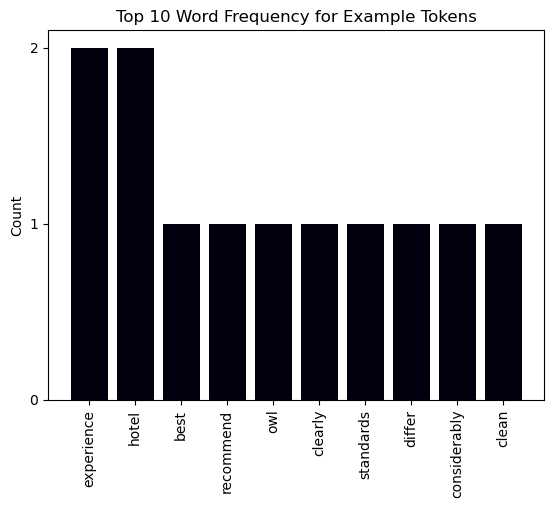

In [88]:
# Importing the relevant package for top number of words
from matplotlib.ticker import MaxNLocator

# Creating a function to visualize the top 10 words

def visualize_top_10(freq_dist, title, rotation):
#     extracting data for graph
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]
    
#     Setting up graph and plotting data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts, color='#00000F')
#     ax.set_facecolor('#ffffff')

#     Customizing plot appearance 
    ax.set_title(title)
    ax.set_ylabel('Count')
    
    # Formatting the y-axis labels to show thousands 
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{:,}'.format(int(x))))
    
    
    ax.tick_params(axis='x', rotation=rotation)
    
visualize_top_10(example_freq_dist, "Top 10 Word Frequency for Example Tokens", 90)

* **FreqDist on the Full DataSet**

In order to calculate the count of words, they need to be stored into a list. To do so, I will `explode` the dataset.  

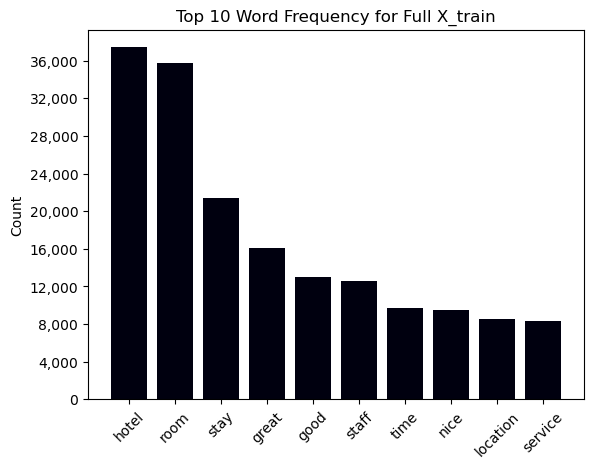

In [89]:
# Creating a frequency distribution for X_train
train_freq_dist = FreqDist(X_train['Review'].explode())

# Plotting the top 10 tokens
visualize_top_10(train_freq_dist, 'Top 10 Word Frequency for Full X_train', 45)


In [90]:
# Inspecting the most common 20 words
train_freq_dist.most_common(20)

[('hotel', 37427),
 ('room', 35770),
 ('stay', 21391),
 ('great', 16054),
 ('good', 13046),
 ('staff', 12527),
 ('time', 9687),
 ('nice', 9459),
 ('location', 8529),
 ('service', 8308),
 ('clean', 8215),
 ('beach', 7747),
 ('walk', 7731),
 ('breakfast', 7539),
 ('night', 7498),
 ('day', 7410),
 ('place', 7377),
 ('like', 7102),
 ('food', 7061),
 ('resort', 6750)]

I will also subdivide this by category (detractors/not_detractors) to see if it makes a difference:

In [91]:
# # Adding in labels for filtering
# X_train['label'] = [y_train[val] for val in X_train.index]

In [92]:
X_train[:3]

Review  \
1282                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     [gem, pleasantly, surprise, accomondations, helpful, attentive, staff, need, breakfast, good, cookies, room, lovely, clean, comfortable, room, front, bush, street, bite, noisy, away, enjoyment, nice, boutique, hotel, definitely, stay, time]   
10661                                                                                                                                                                                                                                                                  [love, fita, wife, spend, nights, hotel, fita, march, 2008, hotel, staff, fantastic, helpful, pleasant, recommend, hotel, travel, amsterdam, hotel, locate, minute, walk, van, gogh, rijks, museums, 10, minute, walk, leidsplein, variety, store, shop, restaurants, locate, tram, stop, directly, hotel, easy, access, entire, city, walk, fita, way, center, city, 30, minutes, beautiful, accesible, friendly, definately, travel, fita, wonderful, amsterdam]   
17908  [great, modern, hotel, fantastic, price, stay, night, begin, april, alot, review, say, bad, area, really, literally, 100m, away, nice, redevelop, area, 10min, walk, beach, partner, arrive, late, barcelona, decide, walk, hotel, bus, station, order, bar, quite, long, walk, 50mins, roughly, really, great, thing, order, sight, tourists, dont, usually, arrive, check, quick, painless, room, really, really, nice, fantastic, modern, design, little, extras, want, order, barcelona, partner, opt, bus, turistic, stop, far, hotel, go, virtually, worth, short, visit, wish, spend, longer, hotel, wish, swim, pool, roof, open, overall, fantastic, hotel, price, pay, room, dont, distance, centre, transport, options]   

       Rating           label  \
1282        4  not_detractors   
10661       5  not_detractors   
17908       5  not_detractors   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      original_review  \
1282                                                                                                                                                                                                                                                                                                                                                                                                                                                            gem, pleasantly surprised accomondations helpful attentive staff need, breakfast good cookies, room lovely clean comfortable, room fronting bush street bit noisy did not away enjoyment nice boutique hotel, definitely stay time,     
10661                                                                                                                                                                                                                                                            loved fita wife spent nights hotel fita march 2008. hotel staff fantastic helpful plea

In [93]:
# Reminding custom colors
# Defining custom colors
custom_colors = ['#00AF87', '#00000F']

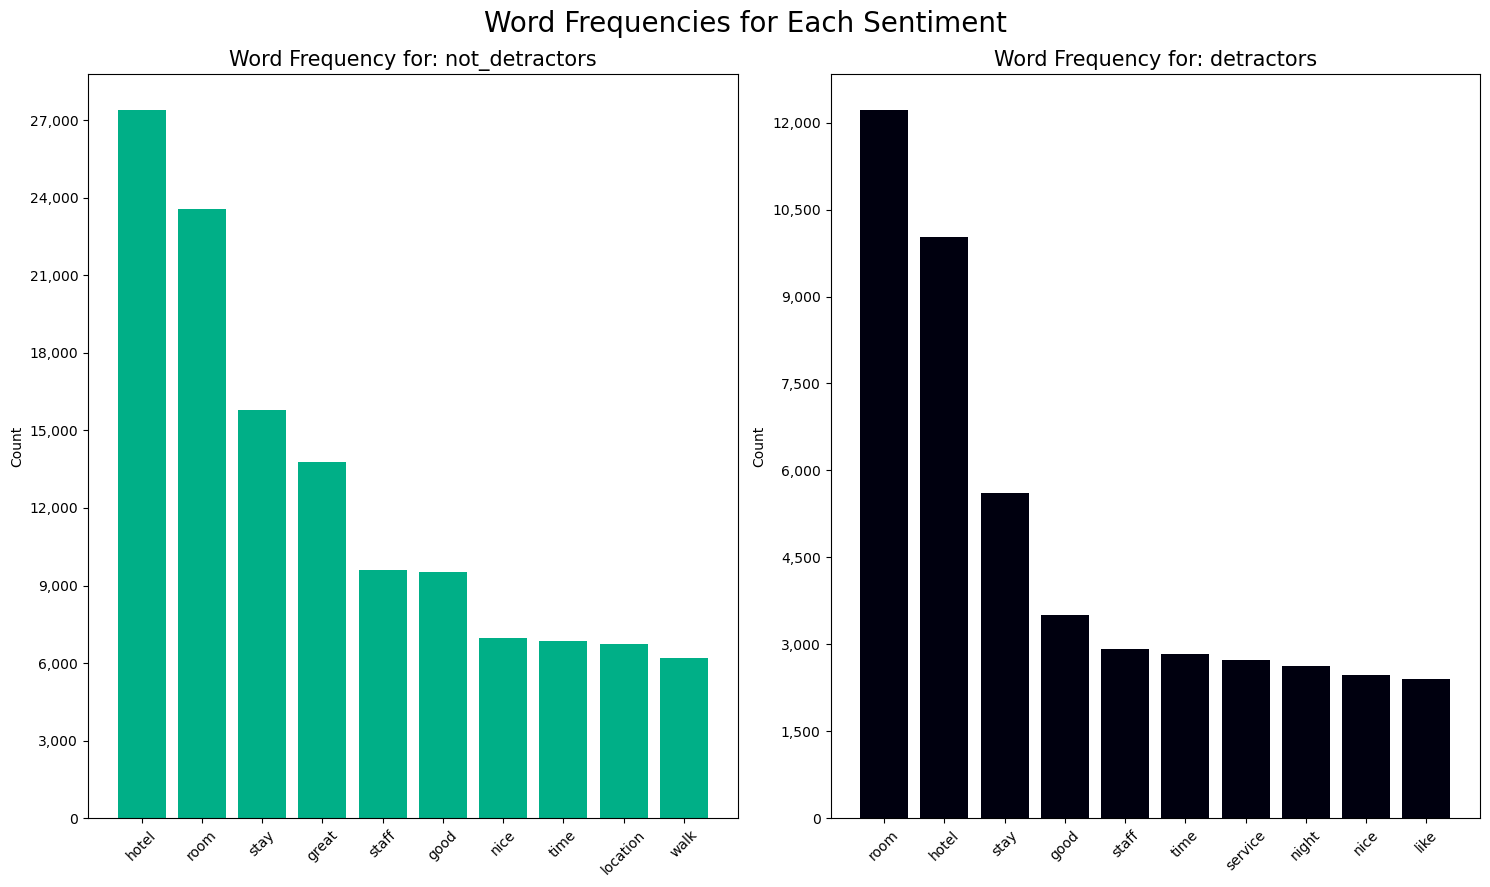

In [94]:
# Defining funcrion to plot 2 visualizations

# Creating two columns 
def two_subplits():
    fig = plt.figure(figsize=(15, 9))
    fig.set_tight_layout(True)
    gs = fig.add_gridspec(1, 2)
    
    ax1 = fig.add_subplot(gs[0, 0]) #row 0, col 0 
    ax2 = fig.add_subplot(gs[0, 1]) #row 0, col 1 
    return fig, [ax1, ax2]

# Plotting the graph
def plot_distribution_by_sentiment(X_version, column, axes, rotation):
    for index, category in enumerate(X_version['label'].unique()): 
        # Calculating frequency distribution for this subset
        all_words = X_version[X_version['label'] == category][column].explode()
        freq_dist = FreqDist(all_words)
        top_10 = list(zip(*freq_dist.most_common(10)))
        tokens = top_10[0]
        counts = top_10[1]
        
        
        # Setting up a plot
        ax = axes[index]
        ax.bar(tokens, counts, color=custom_colors[index])
        
        # Setting background color
        # ax.set_facecolor('#F5F2EE')
    
        # Customizing plot appearance
        title = "Word Frequency for:"
        ax.set_title(f"{title} {category}", fontsize=15)
        ax.set_ylabel("Count")
        
        # Formatting the y-axis labels to show thousands 
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{:,}'.format(int(x))))
        ax.tick_params(axis='x', rotation=rotation)
 
         
fig, axes = two_subplits()
plot_distribution_by_sentiment(X_train, 'Review', axes, 45)
fig.suptitle('Word Frequencies for Each Sentiment', fontsize=20)

 # Saving the plot as a PNG with a transparent background
plt.savefig('images/word_freq.png', transparent=True)

plt.show()

This is helpful to review them as a graph. I will define the subsets in a preliminary step to be able to review the frequency distribution without the need of a graph.  

In [95]:
# Frequency distribution
# Defining subset prior. Here: detractors, notdetractors

notdetractors_reviews = X_train[X_train['label'] == 'not_detractors']
detractors_reviews = X_train[X_train['label'] == 'detractors']

# Defining the function to return the most frequently mentioned words
def freq_distr(subset, most_common):
    exploded_subset = subset['Review'].explode()
    subset_freq = FreqDist(exploded_subset)
    return subset_freq.most_common(most_common)



In [96]:
# Getting frequency distribution for top 20 strings of detractors
freq_distr(detractors_reviews, 20)

[('room', 12221),
 ('hotel', 10028),
 ('stay', 5608),
 ('good', 3507),
 ('staff', 2920),
 ('time', 2840),
 ('service', 2722),
 ('night', 2630),
 ('nice', 2479),
 ('like', 2406),
 ('resort', 2362),
 ('day', 2335),
 ('get', 2330),
 ('go', 2310),
 ('food', 2286),
 ('beach', 2286),
 ('great', 2272),
 ('place', 2081),
 ('clean', 2068),
 ('say', 2046)]

Now reviewing the first 20 words for reviews coming from detractors help us confirm that the first top 5 words are as represented in both categories. They are most common words to refer to a hotel stay. 
They should be removed for clearer analysis. 

In [97]:
# # Applying this to our whole dataset
# X_train['Review'] = X_train['Review'].apply(lambda x: preprocess_review(x))

In [98]:
# Including these new words to a new list of stopwords 
new_stopwords = ['hotel', 'room', 'night', 'day', 'stay', 'resort', 'place']

In [99]:
# Calling the previously defined function to remove stopwords 
X_train['Review'] = X_train['Review'].apply(lambda x: remove_stopwords(x, new_stopwords))

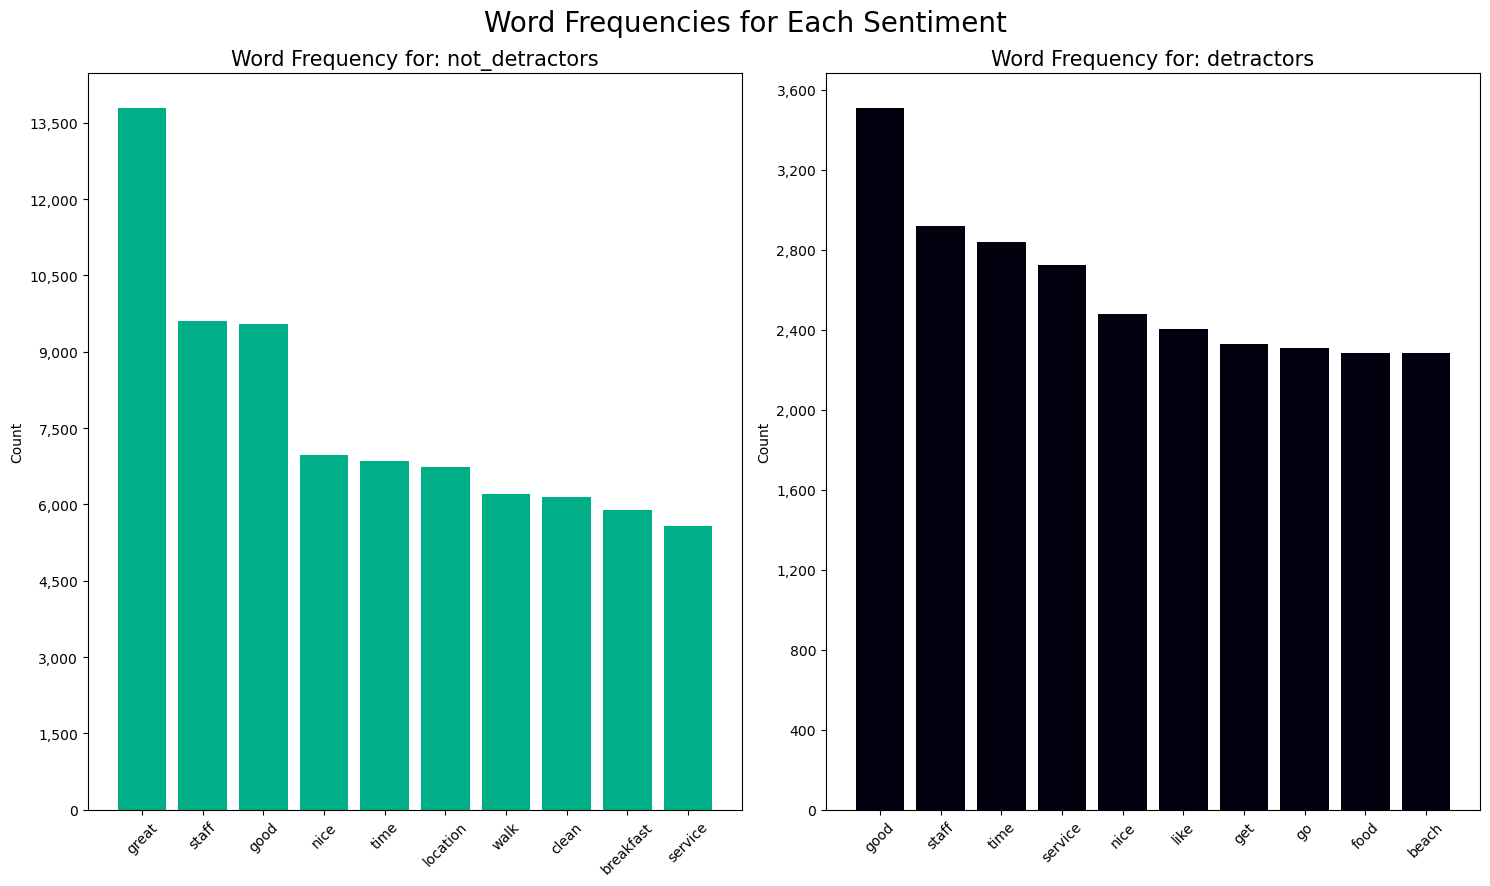

In [100]:
# Calling the function again to review the new split of top 10 words for each sentiment

fig, axes = two_subplits()
plot_distribution_by_sentiment(X_train, 'Review', axes, 45)
fig.suptitle('Word Frequencies for Each Sentiment', fontsize=20)

 # Saving the plot as a PNG with a transparent background
plt.savefig('images/word_freq.png', transparent=True)

plt.show()

I will filter on reviews that include specific words such as 'time' to review if they should be considered stopwords. 

In [101]:
# Defining the word to search 
word_search = 'time'

# Printing the results
X_train[X_train['Review_prep_nolist'].str.contains(word_search)][:3]

# Another way of searching directly in the column 'Review' in case several words were stored in a list.
# word_researched = 'time'
# filtered_on_word = X_train[X_train['Review'].apply(lambda review_list: any(word_researched in s for s in review_list))]
# filtered_on_word

Review  \
1282                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          [gem, pleasantly, surprise, accomondations, helpful, attentive, staff, need, breakfast, good, cookies, lovely, clean, comfortable, front, bush, street, bite, noisy, away, enjoyment, nice, boutique, definitely, time]   
6730  [hat, family, husband, children, disable, june, 23, 30, 2007, ok, time, hot, water, time, contact, service, desk, advise, respond, attitude, staff, work, look, happy, reflect, tremendously, service, food, terrible, sick, end, hosiptal, beg, doctor, discharge, early, children, claim, sick, imagination, rep, suggest, eat, bread, week, nice, suggestion, aware, hospital, ambulance, pick, doctor, office, equip, handle, bacterial, infection, contact, actual, fact, treat, garbage, kid, club, kid, club, children, active, love, swim, play, sport, interact, children, want, kid, club, nothing, kid, kid, sing, songs, circle, break, heart, children, fun, years, away, children, travel, family, cheap, especially, take, years, put, away, money, little, ...]   
49                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      [great, location, friendly, staff, easter, throughly, enjoy, time, superably, locate, explore, seattle, especially, market, good, size, staff, friendly, helpful, reception, area, welcome, exit, stairwell, hear, rumble, assume, like, air, condition, pip]   

      Rating           label  \
1282       4  not_detractors   
6730       1      detractors   
49         5  not_detractors   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           original_review  \
1282                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

Time is so commonly used to describe eihter category: such as 'next time' to describe a 'times where water did not work'. 
I will not include it in the list of stopwords to add. Instead I will try to understand through visualizations and bigrams. 

### 4: 2- g) WordCloud

I will now visually represent the most frequently mentioned words, without representing them in a bar graph. 
<br>Word clouds visually represent the frequency of words in a given text, with more frequently occurring words displayed in larger font size. This allows a quick and intuitive overview of the words occuring most.

In [102]:
# Installing wordcloud
# !pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host=files.pythonhosted.org wordcloud

In [103]:
# Importing relevant packages
from matplotlib.colors import LinearSegmentedColormap

# Defining a colormap that interpolates between the two defined colors
# custom_colors were defined before 

n_bins = 5

# Creating the custom colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_colors, N=n_bins)

In [104]:
# Importing relevant packages 
from wordcloud import WordCloud

# Concatenate all Review into a single string
all_reviews = ' '.join(X_train['Review'].apply(lambda x: ' '.join(map(str, x))))

# Defining the function to plot wordclouds
def wordcloud_graph(text):
    
    # Generate a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='#ffffff', colormap=custom_cmap).generate(all_reviews)

    # Display the generated word cloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


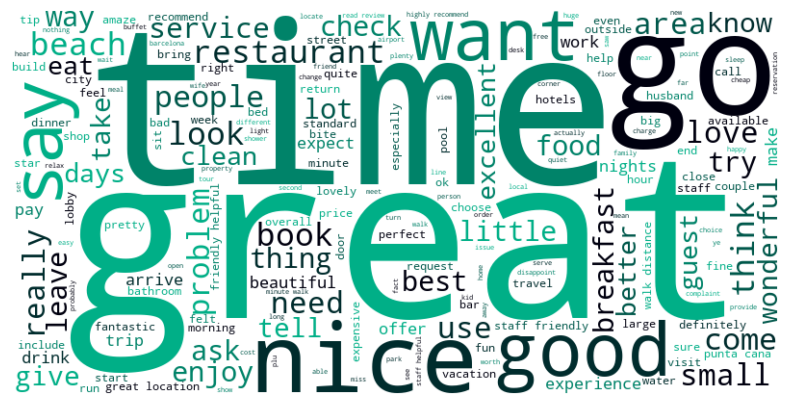

In [105]:
# Calling the function on all reviews
wordcloud_graph(all_reviews)

Place, resort and time are really stand out among some of the most talked about topics in all reviews. 
However it is difficult to distinguish whether these reviews indicate anything mentioned by detractors or not, so I will divide them into 2  categories: 
- detractors 
- not_detractors

I will verify that our X_train includes the label to be able to divide the dataset into 2 categories. 

In [106]:
# Ensuring the 'label' is part of X_train
X_train.columns

Index(['Review', 'Rating', 'label', 'original_review', 'Review_prep_nolist'], dtype='object')

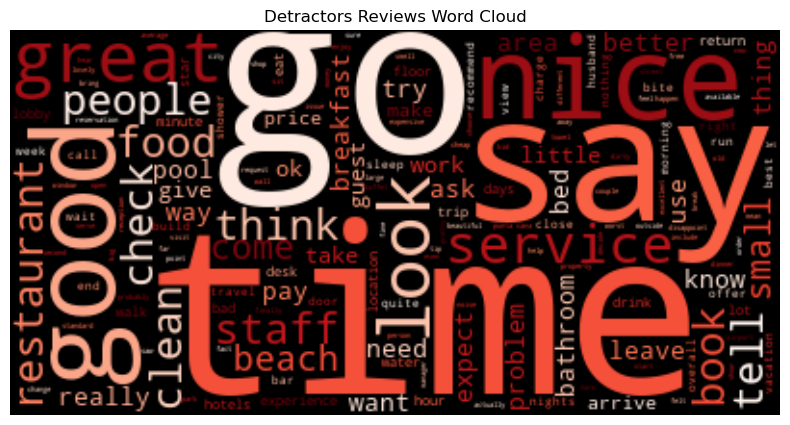

In [107]:
# Importing relevant packages

# Concatenating detractors and not_detractors reviews separately
detractors_reviews = ' '.join(X_train[X_train['label'] == 'detractors']['Review'].apply(lambda x: ' '.join(map(str, x))))
not_detractors_reviews = ' '.join(X_train[X_train['label'] == 'not_detractors']['Review'].apply(lambda x: ' '.join(map(str, x))))

# Defining the function to plot word clouds
def wordcloud_graph(text, title, colormap, background_color):
    # Generating a word cloud
    wordcloud = WordCloud(width=400, height=200, background_color=background_color, colormap=colormap).generate(text)

    # Displaying the generated word cloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Plotting detractors reviews word cloud
wordcloud_graph(detractors_reviews, 'Detractors Reviews Word Cloud', 'Reds', 'black')



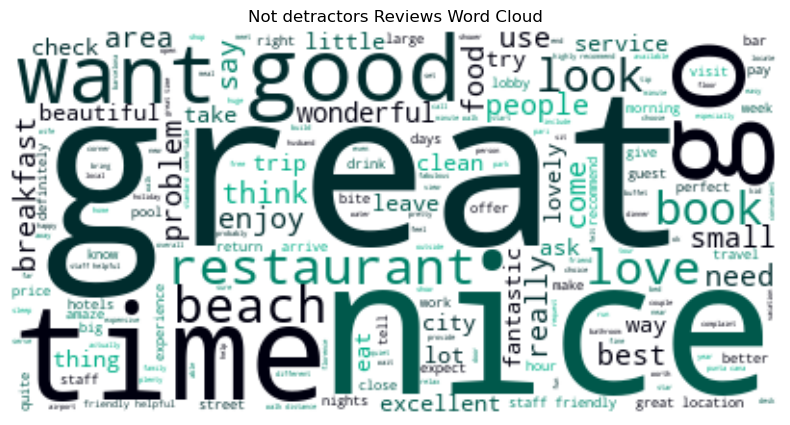

In [108]:
# Plotting not_detractors reviews word cloud
wordcloud_graph(not_detractors_reviews, 'Not detractors Reviews Word Cloud', custom_cmap, 'white')

While the wordcloud for not_detractors seem to standout more, the ones from detractors look like they are a bit harder to distinguish due to the number of times "time" is mentioned. 
I will try removing it from this extract, along with say and go to better understand the themes. 

In [109]:
# Making a copy of the list of words
detractors_reviews_modified = detractors_reviews

In [110]:
# Defining the strings to remove
strings_to_remove = ['time', 'say', 'go', 'nice', 'great', 'od', 'fo']

In [111]:
# Removing them
for string in strings_to_remove:
    detractors_reviews_modified = detractors_reviews_modified.replace(string, '')
# detractors_reviews_modified

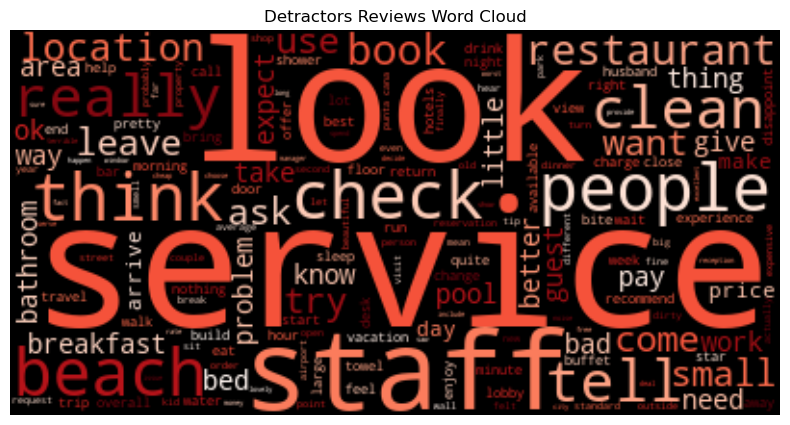

In [112]:
# Plotting detractors reviews word cloud
wordcloud_graph(detractors_reviews_modified, 'Detractors Reviews Word Cloud', 'Reds', 'black')


In [113]:
# Some words were researched individually as well to ensure  
X_train[X_train['Review_prep_nolist'].str.contains(' service ')][:1]

Review  \
6730  [hat, family, husband, children, disable, june, 23, 30, 2007, ok, time, hot, water, time, contact, service, desk, advise, respond, attitude, staff, work, look, happy, reflect, tremendously, service, food, terrible, sick, end, hosiptal, beg, doctor, discharge, early, children, claim, sick, imagination, rep, suggest, eat, bread, week, nice, suggestion, aware, hospital, ambulance, pick, doctor, office, equip, handle, bacterial, infection, contact, actual, fact, treat, garbage, kid, club, kid, club, children, active, love, swim, play, sport, interact, children, want, kid, club, nothing, kid, kid, sing, songs, circle, break, heart, children, fun, years, away, children, travel, family, cheap, especially, take, years, put, away, money, little, ...]   

      Rating       label  \
6730       1  detractors   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           original_review  \
6730  hated resort family 5. husband 3 children disabled, stayed resort june 23-30 2007. room ok times did not hot water, time contacted service desk advise respond attitude, staff working resort looked not happy reflected tremendously service, food terrible, sick ended hosiptal beg doctor discharge early children, hotel claimed no sick imagination, rep suggested eat bread week nice suggestion, hotel aware hospital stay ambulance pick hotel doctor office not equipped handle bacterial infection, no hotel contacted doing actual fact treated garbage, kids club, kids club, children active love swim play sports interact children did not want kids club, did nothing, kids night, kids, night sang songs circle, broke heart children not having fun, years away children, having travel family not cheap, especially takes years putting away money little little order enjoy week vacation, disappointed hotel not recommend unless young going bunch girls guys, like types travelers, lived dr travelled dr 15 times treated poorly did, ignored posting site warning figured people picky, realize hotels dr just not worth,     

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          Review_prep_

Themes that come up the most for the detractors' reviews are: 
* the overall service and staff friendliness:
    * service
    * staff
    * people
* the view from the rooms
* the decor 
    * look 
* cleanliness
    * clean
* problem solving
    * problem 
    * little
    
    
Other smaller negative items: 
* Restaurant
* Bathroom


The mention of 'pay' is indicated. When contrasted with the 'value' mentioned in reviews coming from non-detractors, this indicates guests are okay with paying higher rates as long as they feel like it represents a good value for money. 


<br><br>
As initial recommendations, in order to reduce the number of reviews from detractors:
<br>**1.** Provide training sessions to enhance the friendliness of the staff
<br>**2.** Re-define cleanliness standards 
<br>**3.** Revise the aesthetics of the lobby and rooms — appearance is crucial
<br>**4.** Cultivate a problem-solving environment for staff

Coming up with these themes required extra research though through individual words, so I will try to use bigrams to make the themes more obvious. 

### 4: 2- h) Bigrams

#### Bigrams

* **All Reviews**

In [114]:
# Importing relevant package
from nltk.collocations import *

# Storing nltk.collocations.BigramAssocMeasures into variable
bigram_measures = nltk.collocations.BigramAssocMeasures()

I will define a function to review bigrams and be able to filter in the future by the category I need.

In [115]:
# Defining a function to review bigrams
def bigram_review(text, top_n):
    # Creating a finder and passing it the words of reviews summarized as 1 list  
    text_finder = BigramCollocationFinder.from_words(text.sum())
    text_scored = text_finder.score_ngrams(bigram_measures.raw_freq)
    return text_scored[: top_n]


I am starting with the top 20 bigrams overall. 

In [116]:
# Calling the function to review the top 20 bigrams overall 
bigram_review(X_train['Review'], 20)

[(('great', 'location'), 0.001195786887061),
 (('staff', 'friendly'), 0.0011807859762914177),
 (('punta', 'cana'), 0.0008879110517424272),
 (('walk', 'distance'), 0.000804334548883325),
 (('friendly', 'helpful'), 0.0007857619926924135),
 (('highly', 'recommend'), 0.0007250440205298179),
 (('staff', 'helpful'), 0.0005964647853619684),
 (('minute', 'walk'), 0.0005750349128339935),
 (('read', 'review'), 0.000535032484115107),
 (('location', 'great'), 0.0005036020044074104),
 (('air', 'condition'), 0.0005000303589860813),
 (('make', 'sure'), 0.0004978873717332838),
 (('san', 'juan'), 0.0004943157263119546),
 (('great', 'time'), 0.0004857437773007647),
 (('good', 'value'), 0.00042859745055949826),
 (('good', 'location'), 0.0004228828178853716),
 (('breakfast', 'buffet'), 0.00038716636367208007),
 (('food', 'good'), 0.0003850233764192826),
 (('new', 'york'), 0.000379308743745156),
 (('value', 'money'), 0.0003757370983238268)]

This started providing better insights. In addition to what was identified for detractors, it can be identified here that what is most appreciated by guests are:
* Great location, close to key attractions
* Friendly and helpful staff 
* Good value for money would be felt

In [117]:
# Creating subsets by detractors or not detractor reviews
X_train_detractors = X_train[X_train['label'] == 'detractors']
X_train_notdetractors = X_train[X_train['label'] != 'detractors']

In [118]:
# Calling the bigram function on detractorss
detractors_bigrams_100 = bigram_review(X_train_detractors['Review'], 100)

# Calling the bigram function on not detractorss
notdetractors_bigrams_100 = bigram_review(X_train_notdetractors['Review'], 100)

In [119]:
# Creating a function to review bigrams in WordClouds
def wordcloud_bigrams(bigram_list, title, colormap, background_color):
    # Converting bigrams to a dictionary for WordCloud
    wordcloud_data = {bigram[0]: freq for bigram, freq in bigram_list}
    
    # Creating WordClouds
    wordcloud = WordCloud(width=800, height=400, background_color=background_color, colormap=colormap).generate_from_frequencies(wordcloud_data)
    
    # Plotting WordCloud
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=15, pad=20)
    plt.axis('off')
    plt.show()


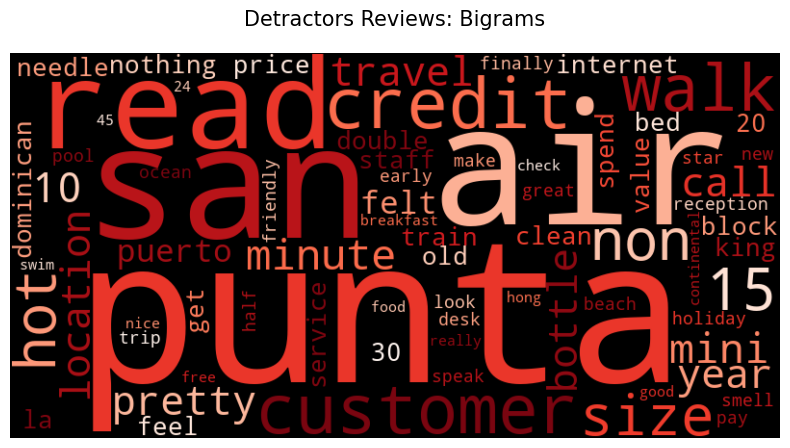

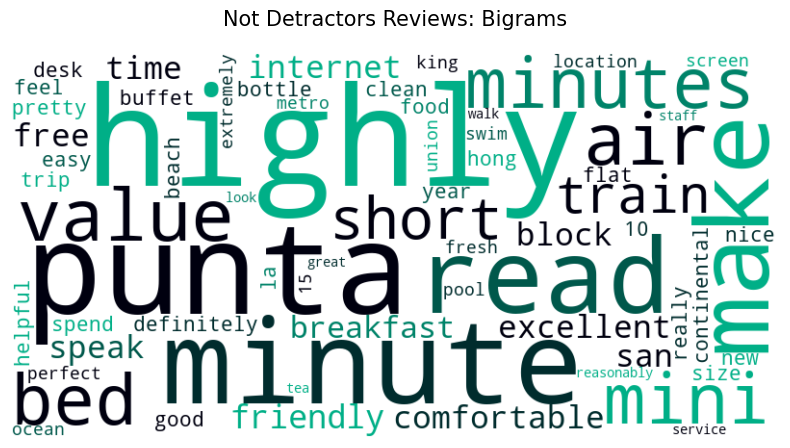

In [120]:
# Calling it on the detractors_bigrams_100 list
wordcloud_bigrams(detractors_bigrams_100, 'Detractors Reviews: Bigrams', 'Reds', 'black')

# Calling it on the notdetractors_bigrams_100 list
wordcloud_bigrams(notdetractors_bigrams_100, 'Not Detractors Reviews: Bigrams', custom_cmap, 'white')

It is not easy to distinguish the difference in detactors vs not detactors reviews when individualizing again the bigrams. What about if I select more bigrams, such as the top 500 for each?


In [121]:
# Calling the bigram function on detractors
detractors_bigrams_500 = bigram_review(X_train_detractors['Review'], 500)

# Calling the bigram function on not detractors
notdetractors_bigrams_500 = bigram_review(X_train_notdetractors['Review'], 500)

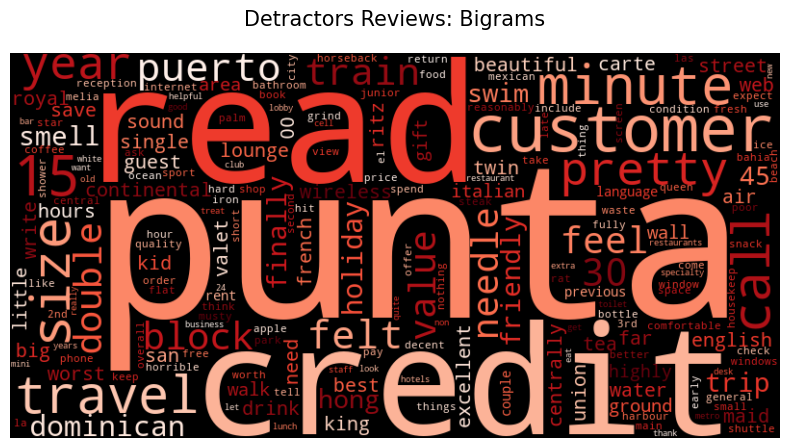

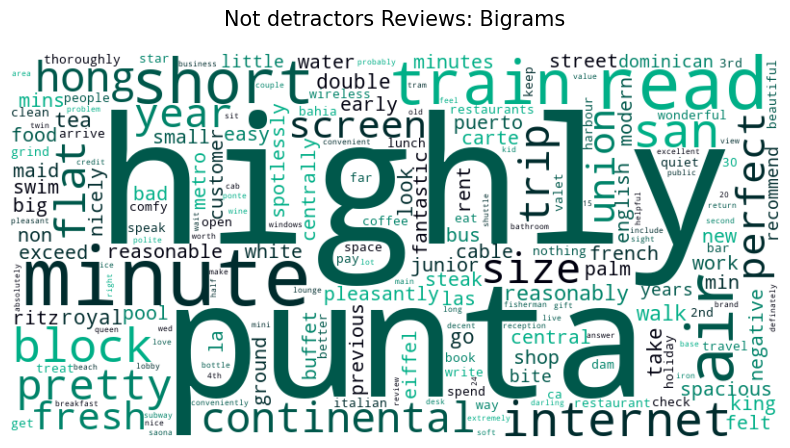

In [122]:
# Calling it on the detractor_bigrams_500 list
wordcloud_bigrams(detractors_bigrams_500, 'Detractors Reviews: Bigrams', 'Reds', 'black')

# Calling it on the notdetractor_bigrams_500 list
wordcloud_bigrams(notdetractors_bigrams_500, 'Not detractors Reviews: Bigrams', custom_cmap, 'white')

There are still some similarities among dectractors and not detractors reviews referring to `Punta Cana` and walking. Let's research these specific mention to get a better understanding. 

In [123]:
# Research walking and punta in detractors_bigrams_500

def research_bigram(word, bigram_list):
    word_researched = [bigram for bigram in bigram_list if word in bigram[0]]
    return word_researched

print(research_bigram('punta', detractors_bigrams_500))
# print(research_bigram('punta', dectractors_bigrams_500))

[(('punta', 'cana'), 0.00099021799216478)]


In [124]:
# notdetractors_bigrams_500

# print(research_bigram('walking', notpositive_bigrams_500))
print(research_bigram('punta', notdetractors_bigrams_500))

[(('punta', 'cana'), 0.0008446452439154541)]


The referrence to Punta Cana may only indicate that there is a high number of reviews. 

Out of curiosity, I drew bigrams for Punta Cana specifically to get an understanding of why they are 

In [125]:
# Calling the bigram function on punta
detractors_bigrams_punta = bigram_review(X_train_detractors[X_train_detractors['Review_prep_nolist'].str.contains('punta')]['Review'], 500)

# Calling the bigram function on not detractors
notdetractors_bigrams_punta = bigram_review(X_train_notdetractors[X_train_notdetractors['Review_prep_nolist'].str.contains('punta')]['Review'], 500)

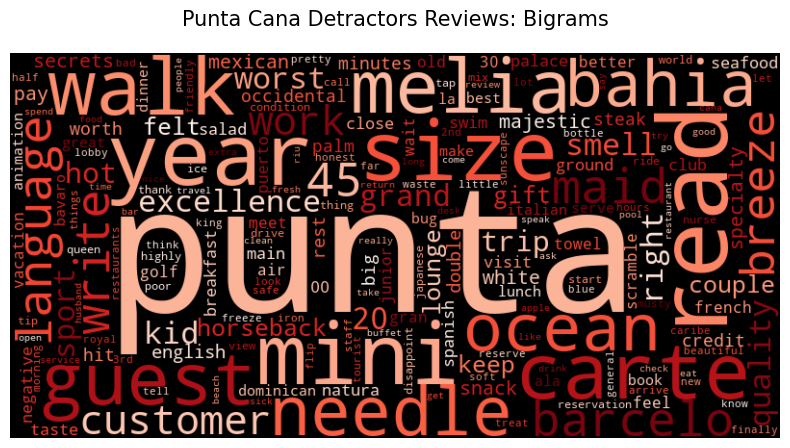

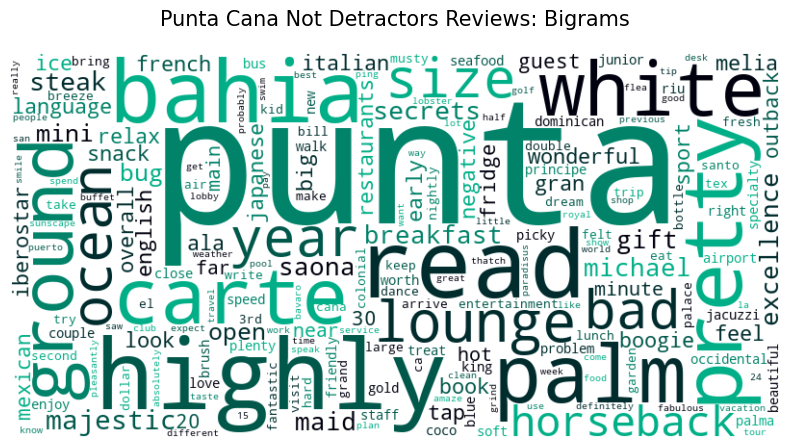

In [126]:
# Calling it on the detractors list
wordcloud_bigrams(detractors_bigrams_punta, 'Punta Cana Detractors Reviews: Bigrams', 'Reds', 'black')

# Calling it on the notpositive_bigrams_punta list
wordcloud_bigrams(notdetractors_bigrams_punta, 'Punta Cana Not Detractors Reviews: Bigrams', custom_cmap, 'white')

It looks like Punta Cana is one of the top visited resorts or one of those generating the highest number of reviews which explains why the name comes up so often.

By separating only for Punta Cana the negatives and not negative words, I can get better insights: horseback riding is one of the top activities, gusts appreciate the all inclusive service, and the hotel guests are referring to is the `Bahia Principe` hotel and resort. 

I will now try to visualize the top 20 positive and negative bigrams overall to close on this topic.  

In [127]:
# Storing the top 20 bigrams for each sentiment
detractors_bigrams_20 = detractors_bigrams_500[:20]
notdetractors_bigrams_20 = notdetractors_bigrams_500[:20]

In [128]:
# Combining bigram words into a single string for each sentiment
detractor_bigram_20 = [' '.join(bigram[0]) for bigram in detractors_bigrams_20]
notdetactor_bigram_20 = [' '.join(bigram[0]) for bigram in notdetractors_bigrams_20]

# Reviewing what the newly created lists look like  
# detractor_bigram_20

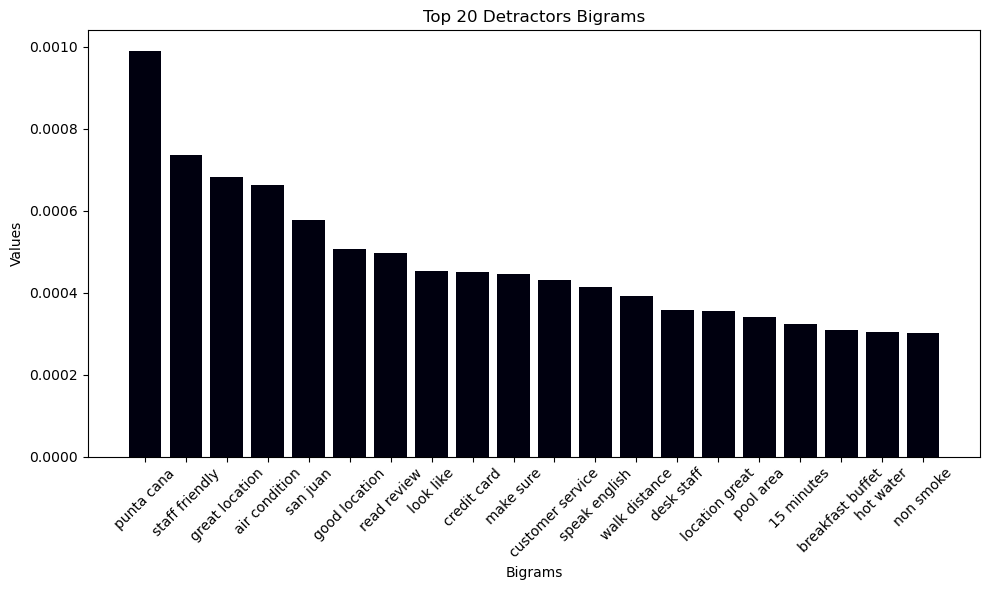

In [129]:
# Plotting the detractor bigrams as a bar chart 

# Extracting bigrams and values
bigrams, values = zip(*detractors_bigrams_20)

# Sort bigrams and values in descending order based on values
sorted_indices = sorted(range(len(values)), key=lambda k: values[k], reverse=True)
sorted_bigrams = [bigrams[i] for i in sorted_indices]
sorted_values = [values[i] for i in sorted_indices]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_values)), sorted_values, align='center', color='#00000F')
plt.xticks(range(len(sorted_values)), [f'{bigram[0]} {bigram[1]}' for bigram in sorted_bigrams], rotation=45)
plt.xlabel('Bigrams')
plt.ylabel('Values')
plt.title('Top 20 Detractors Bigrams')
plt.tight_layout()
plt.show()

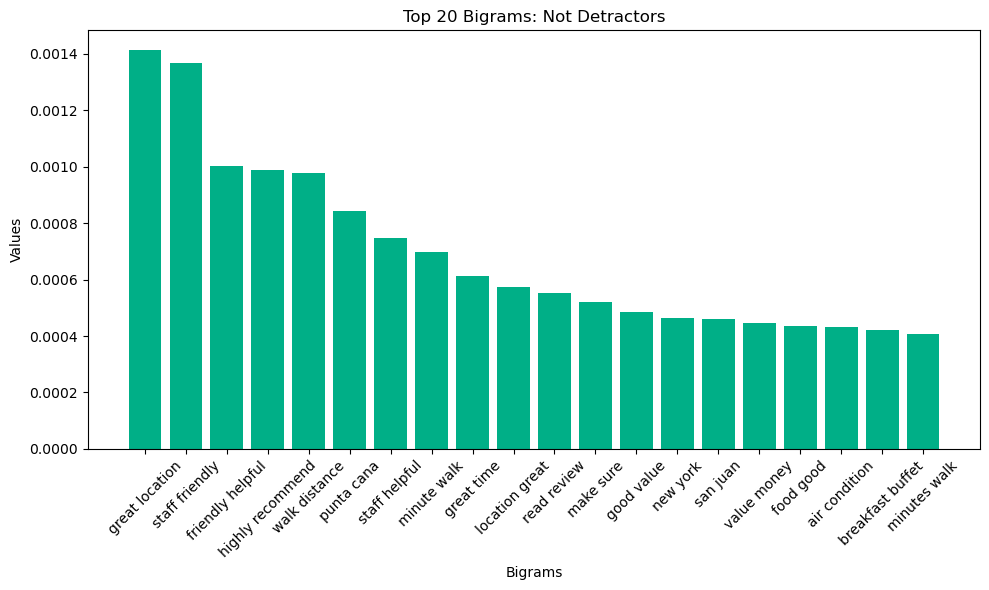

In [130]:
# Plotting the negative bigrams as a bar chart 

# Extracting bigrams and values
bigrams, values = zip(*notdetractors_bigrams_20)

# Sort bigrams and values in descending order based on values
sorted_indices = sorted(range(len(values)), key=lambda k: values[k], reverse=True)
sorted_bigrams = [bigrams[i] for i in sorted_indices]
sorted_values = [values[i] for i in sorted_indices]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_values)), sorted_values, align='center', color='#00AF87')
plt.xticks(range(len(sorted_values)), [f'{bigram[0]} {bigram[1]}' for bigram in sorted_bigrams], rotation=45)
plt.xlabel('Bigrams')
plt.ylabel('Values')
plt.title('Top 20 Bigrams: Not Detractors')
plt.tight_layout()
plt.show()

In [131]:
# Searching through actual reviews to define the themes of some bigrams
# X_train_detractors[X_train_detractors['Review_prep_nolist'].str.contains('credit card')][['original_review']]

Despite detractors giving overall negative reviews, they also highlight what they liked in the hotel as a contrast. This is why location is often referred to as something great. 

I will remove the references to location, as well as the indications such as 'make sure' so I can clearly display the top 10 themes to focus on.  

In [132]:
bigrams_to_remove = [('great', 'location'), ('make', 'sure'), ('good', 'location'), ('location', 'great'), ('walk', 'distance')]

In [133]:
# Creating top_10_bigrams if they are not in list of bigrams to remove 
detractors_bigrams_10 = [bigram for bigram in detractors_bigrams_500 if bigram[0] not in bigrams_to_remove][:10]
detractors_bigrams_10

[(('punta', 'cana'), 0.00099021799216478),
 (('staff', 'friendly'), 0.000735453168937919),
 (('air', 'condition'), 0.0006633499170812604),
 (('san', 'juan'), 0.0005768260148532699),
 (('read', 'review'), 0.0004975124378109452),
 (('look', 'like'), 0.00045184704496839474),
 (('credit', 'card'), 0.00044944360323983943),
 (('customer', 'service'), 0.0004302160694113971),
 (('speak', 'english'), 0.0004133919773115101),
 (('desk', 'staff'), 0.0003581128175547384)]

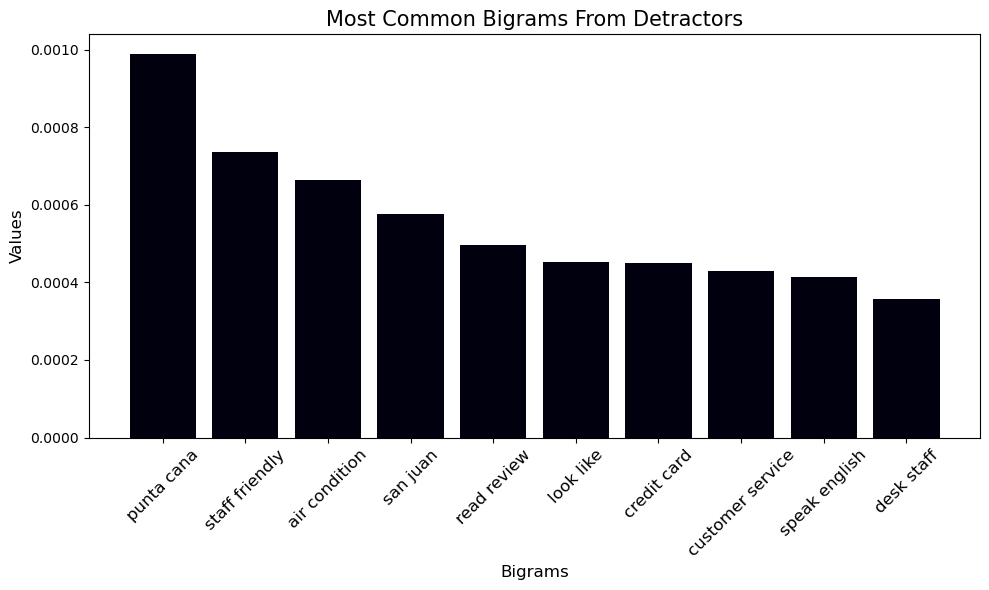

In [134]:
# Plotting the detractor bigrams as a bar chart 

# Extracting bigrams and values
bigrams, values = zip(*detractors_bigrams_10)

# Sort bigrams and values in descending order based on values
sorted_indices = sorted(range(len(values)), key=lambda k: values[k], reverse=True)
sorted_bigrams = [bigrams[i] for i in sorted_indices]
sorted_values = [values[i] for i in sorted_indices]


# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_values)), sorted_values, align='center', color='#00000F')
plt.xticks(range(len(sorted_values)), [f'{bigram[0]} {bigram[1]}' for bigram in sorted_bigrams], rotation=45, fontsize=12)
plt.xlabel('Bigrams', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.title('Most Common Bigrams From Detractors', fontsize=15)
plt.tight_layout()
# Saving the plot as a PNG with a transparent background
plt.savefig('images/top10detractors.png', transparent=True)
plt.show()

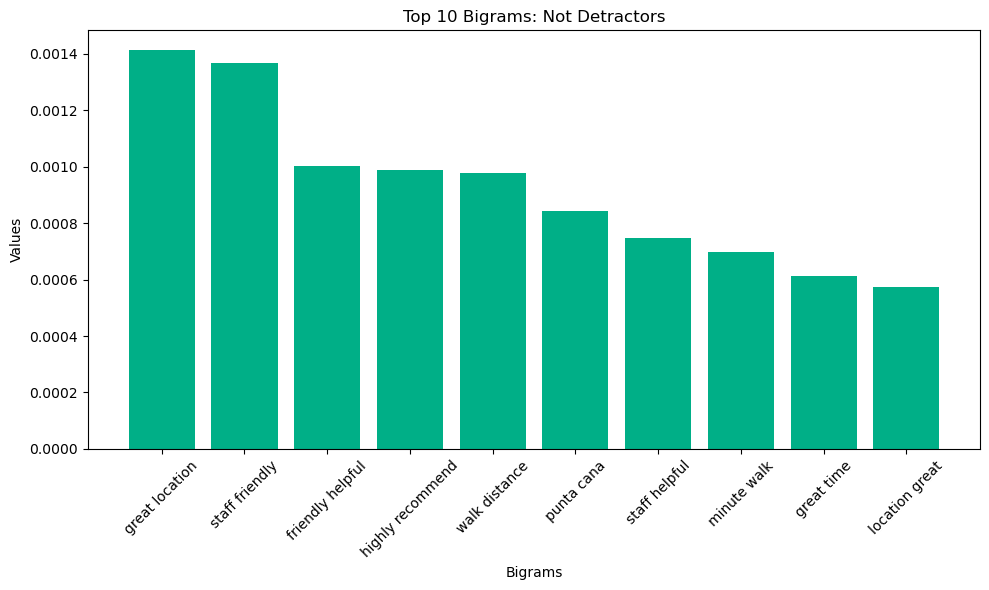

In [135]:
# Plotting the negative bigrams as a bar chart 

# Extracting bigrams and values
bigrams, values = zip(*notdetractors_bigrams_20[:10])

# Sort bigrams and values in descending order based on values
sorted_indices = sorted(range(len(values)), key=lambda k: values[k], reverse=True)
sorted_bigrams = [bigrams[i] for i in sorted_indices]
sorted_values = [values[i] for i in sorted_indices]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_values)), sorted_values, align='center', color='#00AF87')
plt.xticks(range(len(sorted_values)), [f'{bigram[0]} {bigram[1]}' for bigram in sorted_bigrams], rotation=45)
plt.xlabel('Bigrams')
plt.ylabel('Values')
plt.title('Top 10 Bigrams: Not Detractors')
plt.tight_layout()
plt.show()

Bigrams from detractors indicate that:
* Punta Cana and San Juan are the first destinations that require attention 
* Staff friendliness needs to be addressed as identified in wordclouds
* Air conditioning needs to work and remain quiet
* Appearance matters: ensure the hotel is well-maintainted 
* Hire staff who can speak English in destinations welcoming English-speaking guests
* Ensure easy payment methods are allowed and work correctly 
    <br>Some hotels (i.e. Florence) do not take credit cards. This needs to be addressed nowadays 
* Respond to reviews: a lot of detractors mention they read them

### 4: 2- i) Mutual Information Scores

I will calculate mutual information scores and I will create a frequency filter, so that I only examine the strength of association between pairs of words (bigrams) for detractors or not detractors sentiments. 

In [136]:
# Defining a function to calculate the mutual information scores
def mutual_info_score(text, n_filter):
    text_pmi_finder = BigramCollocationFinder.from_words(text.sum())
    text_pmi_finder.apply_freq_filter(n_filter)
    text_pmi_scored = text_pmi_finder.score_ngrams(bigram_measures.pmi)
    return text_pmi_scored

In [137]:
# Calling the function for the top 10 mutual information scores for all reviews
mutual_info_score(X_train['Review'], 5)[:10]

[(('ajili', 'mojili'), 18.094979706748987),
 (('krispy', 'kreme'), 18.094979706748987),
 (('desa', 'seni'), 17.83194530091519),
 (('ocho', 'rios'), 17.83194530091519),
 (('ropa', 'vieja'), 17.609552879578743),
 (('altos', 'chavon'), 17.41690780163635),
 (('dai', 'ichi'), 17.41690780163635),
 (('kwai', 'fong'), 17.41690780163635),
 (('ograde', 'oreview'), 17.41690780163635),
 (('piet', 'hein'), 17.41690780163635)]

In [138]:
# Reminding the previously created subsets by detractors or not detractors reviews
X_train_detractors = X_train[X_train['label'] == 'detractors']
X_train_notdetractors = X_train[X_train['label'] != 'detractors']

In [139]:
# Calling the function for the top 10 mutual information scores for positive reviews
mutual_info_score(X_train_detractors['Review'], 5)[:10]

[(('sha', 'tsui'), 16.344538648678256),
 (('tsim', 'sha'), 16.344538648678256),
 (('degli', 'orafi'), 16.08150424284446),
 (('lo', 'behold'), 16.08150424284446),
 (('rick', 'steves'), 15.859111821508012),
 (('ograde', 'oreview'), 15.666466743565618),
 (('chateau', 'lemoyne'), 15.496541742123306),
 (('postage', 'stamp'), 15.496541742123306),
 (('sagrada', 'familia'), 15.47382166562322),
 (('zona', 'rosa'), 15.444074322229168)]

In [140]:
# Calling the function for the top 10 mutual information scores for notdetractors reviews
mutual_info_score(X_train_notdetractors['Review'], 5)[:10]

[(('kwai', 'fong'), 17.58614342342153),
 (('desa', 'seni'), 17.323109017587733),
 (('smith', 'wollensky'), 17.323109017587733),
 (('piet', 'hein'), 17.10071659625129),
 (('degli', 'orafi'), 16.908071518308894),
 (('pont', 'neuf'), 16.908071518308894),
 (('dai', 'ichi'), 16.90807151830889),
 (('zoologischer', 'garten'), 16.90807151830889),
 (('crabtree', 'evelyn'), 16.73814651686658),
 (('frankfurter', 'allee'), 16.685679096972443)]

The mutual information scores in themselves are a bit hearder to drive direct conclusions from them. Additional analyses would be necessary for them to be conclusive. 

The groups of words mostly indicate some specific neighborhoods in destinations that were not appreciated by guests, or at the opposite, some destinations and attractions in destinations that were often talked by guests who reviewed the hotels positively.


<a id='modeling'></a>

## 5. Modeling

I now have an initial idea for recommendations on focus areas to improve guest satistfaction. My objective is now to:
1. Provide more precise recommendations or confirm them
2. Develop a tool to identify unsatisfied customer reviews in real time

The goal is to identify the most unsatisfied customers, the detractors. The cost of wrongly predicting a satisfied guest, when they actually were unsatisfied (false negative) is higher than incorrectly predicting a guest as unsatisfied, when they actually were (false positive).

Incorrectly identifying a guest as satisfied when they weren't would lead in a detractor posting a review instead of catching them while they are in-house, and having a chance of improving their satisfaction. 

As a consequence, `recall` should be an important evaluation metric for this model.

As the dataset is a text, it requires a transformation before it can be used for modeling. Like other types of dataset would one-hot encoded, here, the reviews were vectorized, using the common method in natural language processing: `TfidfVectorizer`.  
<br> It converts a collection of text documents to a matrix of tf-idf features. 

* Term-Frequency
<br>Measures how often a term (word) appears in a document
* Inverse Document Frequency (IDF)
<br>Measures the importance of a term in the entire collection of documents. 

4 main classification models were explored: 
1. Multinomial Naive Bayes
2. K-Nearest Neighbor 
3. Decision Tree
3. Random Forest 
4. Gradient Boosting
5. AdaBoost
6. XGBoost

The models' parameters were tuned using the following approaches:
1. Under Sampling
2. Stopwords
3. Lemmatize
4. Full text preprocessing
5. Hyperparameter Tuning
    * Combinatoric Grid Searching

In addition, X_train was split with `stratify` in order to keep the distribution ratios for ech sentiment.  

In [141]:
# Reminding the natural balance
y_train.value_counts(normalize=True)

0    0.736596
1    0.263404
Name: Sentiment, dtype: float64

If I were to guess the majority class every time I would get 74% accuracy. 

In [142]:
# Verifing labels is not part of X_train
X_train.columns

Index(['Review', 'Rating', 'label', 'original_review', 'Review_prep_nolist'], dtype='object')

In [143]:
# Dropping it 
# X_train = X_train.drop('label', axis=1)

By using only the dataset's natural class balance, and if I guessed the contribution of the majority class every time I would get 67% accuracy. However, if I were to guess that a review was positive, I would expect only about 33% accuracy. 

### 5. a) Baseline Model with TfidfVectorizer and MultinomialNB

The first baseline model will vectorize the reviews and make predictions using Multinomial Naive Bayes. The first step is to import the vectorizer, instantiate a vectorizer object and fit it on `X_train['original_review']`.

### <u>1st iteration</u>: Vanilla Tfidf Vectorizer with Pipeline

    1) Fitting and training on train data

In [144]:
# Importing the relevant packages
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# Define the pipeline steps
tfidf_vectorizer = TfidfVectorizer()
naive_bayes_classifier = MultinomialNB()

# Create the pipeline
base_pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('classifier', naive_bayes_classifier)
])

# Fitting the pipeline on X_train['original_review'] and y_train
base_pipeline.fit(X_train['original_review'], y_train)

# Calculating predictions using this model
base_y_pred = base_pipeline.predict(X_test['original_review'])

# Optionally, you can access the individual components of the pipeline:
X_train_vectorized = base_pipeline.named_steps['tfidf'].transform(X_train['original_review'])
baseline_model = base_pipeline.named_steps['classifier']

    2) Evaluation Metrics

In [145]:
# Importing the relevant packages
from sklearn.metrics import recall_score, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score

def evaluation_metrics(y_test, y_pred, model, X, y):
    with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
    
    # Calculating and printing accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

    # Calculating and printing F1-score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'F1-Score: {f1:.4f}')
    
    # Calculating and printing recall
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    print(f'Recall: {recall:.4f}')

    # Performing cross-validation and printing the mean accuracy
    cv_scores = cross_val_score(model, X, y, cv=5)
    mean_cv_accuracy = cv_scores.mean()
    print(f'Mean Cross-Validated Accuracy: {mean_cv_accuracy:.4f}')
    
    return accuracy, f1, recall, mean_cv_accuracy

In [146]:
# Naming the model and calling the function to evaluate it
baseline_model_name = 'Baseline'

# Calling the function and recording into the defined values
accuracy_base, f1_base,recall_base, cv_base = evaluation_metrics(
    y_test, 
    base_y_pred, 
    base_pipeline, 
    X_train['original_review'], 
    y_train)

Accuracy: 0.7546
F1-Score: 0.6656
Recall: 0.7546
Mean Cross-Validated Accuracy: 0.7507


The model shows a reasonable overall accuracy in predicting sentiments from hotel reviews on TripAdvisor. It achieves a good balance between recall and F1-Score, with a mean cross-validated accuracy that suggests stability across different subsets of the data. 

Let's verify this using the classification report and confusion matrix. 

    3) Classification Report

In [147]:
# Defining a function to print a classification report

import warnings
from sklearn.metrics import classification_report

def class_calculation(y_test, y_pred):
    # y_preds will be calculated for each model beforehand 
    
    # Generating and printing classification report
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
    class_report = classification_report(y_test, y_pred, zero_division=0, digits=5, target_names=["Not Detractors", "Detractors"])
#     class_report = classification_report(y_test, y_pred, zero_division=0, digits=5)
    
    # Due to class imbalance, the initial recall for positive returns 0 
    # Consequently, warnings need to be handled 
    print('Classification Report:\n', class_report)
    
    
     # Parsing the classification report to extract recall for 'Detractors'
    lines = class_report.split('\n')
    recall_line = lines[3]  
    # Extracting numerical values
    recall_values = [float(value) for value in recall_line.split()[1:]]  
    # Storing recall for Detractors 
    recall_detractors = recall_values[1]     
    
    
    return class_report, recall_detractors
    



Because what matters most is recall but for the detractors' side, we will also store this metric.

In [148]:
# Calling the function to record the classification report
base_class_report, recall_detractors_base = class_calculation(y_test, base_y_pred)

Classification Report:
                 precision    recall  f1-score   support

Not Detractors    0.75020   0.99973   0.85718      3773
    Detractors    0.98947   0.06963   0.13010      1350

      accuracy                        0.75464      5123
     macro avg    0.86984   0.53468   0.49364      5123
  weighted avg    0.81325   0.75464   0.66558      5123



    4) Confusion Matrix

In [149]:
# Creating a color map
from matplotlib.colors import LinearSegmentedColormap

# Defining a colormap that interpolates between the two defined colors
custom_colors_cnf = ['#2F4858', '#00868A', '#00AF87']

n_bins = 20

# Creating the custom colormap
custom_cmap_cnf = LinearSegmentedColormap.from_list("custom_cmap", custom_colors_cnf, N=n_bins)

In [150]:
# Displaying visually the confusion matrix 

# Importing the relevant package 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def confusion_matrix_display(model, y_test, y_pred):
    # Defining the confusion matrix 
    cnf_matrix = confusion_matrix(y_test, y_pred)
#     print(cnf_matrix)
    
    # Normalizing the confusion matrix
    cnf_matrix_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    
    # Taking in the model's classes as labels
#     disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix_normalized, display_labels=model.classes_)
    
    # Taking in pre-defined labels
    disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix_normalized, display_labels=["Not Detractors", "Detractors"])

    disp.plot(cmap=custom_cmap_cnf)

    plt.title("Model Performance: Confusion Matrix", fontsize=16)

    # Saving the plot as a PNG with a transparent background
    plt.savefig('images/confusion_matrix.png', transparent=True)

    return cnf_matrix
    plt.show()
    

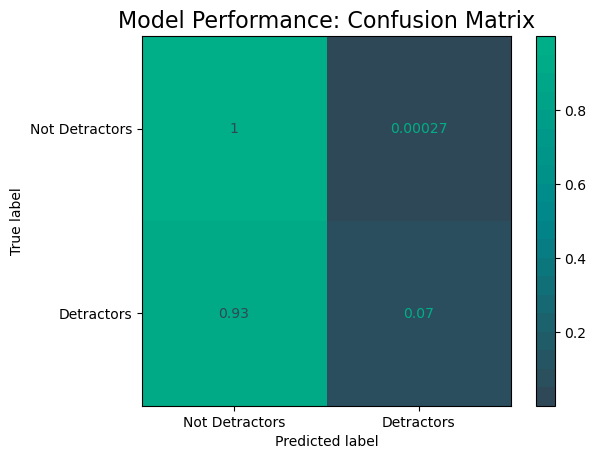

In [151]:
# Calling the function to display the confusion matrix 
base_cfn_matrix = confusion_matrix_display(base_pipeline, y_test, base_y_pred)

While the overall metrics look decent, the results for each sentiment are not balanced at all and the recall for detractors is the lowest of recorded results: 0.06963. 
This needs to be addressed through the dataset's balance. 

    5) ROC Curve and AUC

The Receiver Operating Characteristic (ROC) Curve displays on a fraph the False Positive Rate against the True Positive Rate. It is another evaluation metric for classification algorithms combining both described ratios. It is compared to a *worthless accuracy*: a classifier with 50-50 accuracy. It is considered worthless, as it would be comparable to just random guessing.     

In [152]:
# Importing the relevant packages
from sklearn.metrics import roc_curve, auc


def plot_roc_curve(y_true, y_pred_proba, model_name='Model'):
    # Computing ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Plottting ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='#00AF87', lw=2, label='{} (AUC = {:.4f})'.format(model_name, roc_auc))

    # Plotting the 50-50 accuracy line
    plt.plot([0, 1], [0, 1], color='#00000F', lw=2, linestyle='--', label='Random 50-50')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve - {}'.format(model_name))
    plt.legend(loc='lower right')
    plt.show()
    return roc_auc

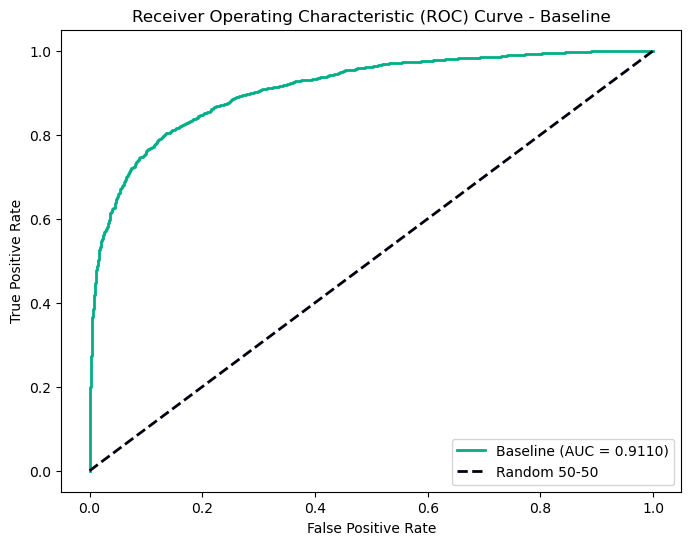

In [153]:
# Plotting the ROC curve for the baseline model
base_y_pred_proba = base_pipeline.predict_proba(X_test['original_review'])[:, 1]
auc_base = plot_roc_curve(y_test, base_y_pred_proba, model_name=baseline_model_name)

In [154]:
# Defining a function that provides an interpretation of area under the curve 
def auc_interpretation(auc): 
    if auc == 1:
        print(f'AUC = {auc:.4f}. The model is a perfect classifier. It predicts all positive instances higher than all negative instances.')
    elif auc > 0.95:
        print(f'AUC = {auc:.4f}. The model has a predictive power close to perfection.')    
    elif auc > 0.9:
        print(f'AUC = {auc:.4f}. The model has a great predictive power.')    
    elif auc > 0.8:
        print(f'AUC = {auc:.4f}. The model has a good predictive power.')   
    elif auc > 0.7:
        print(f'AUC = {auc:.4f}. The model has some predictive power.')    
    elif auc == 0.5:
        print(f'AUC = {auc:.4f}. The model does not perform better than random chance.')   
    
    

In [155]:
# Printing the interpretation
auc_interpretation(auc_base)

AUC = 0.9110. The model has a great predictive power.


In [156]:
# Creating an empty list of metrics to easily add new evaluations as they are done
modelnames = []
accuracies = []
f1s = []
recalls = []
recalls_detractors = []
cv_accs = []
roc_aucs = []

In [157]:
# Appending each metric to the lists 
modelnames.append(baseline_model_name)
accuracies.append(accuracy_base)
f1s.append(f1_base)
recalls.append(recall_base)
recalls_detractors.append(recall_detractors_base)
cv_accs.append(cv_base)
roc_aucs.append(auc_base)

### <u>2nd iteration</u>: Addressing class imbalance: undersampling negative reviews

#### Sampling Strategy: 0.8

While the initial categorization of sentiment following Net Promoter Score classification helped address the dataset imbalance, the number of reviews from non-detractors remained higher than the one from detractors. 

As a consequence, the dataset needs to be resampled. More precisely, negative reviews need to be undersampled. I will first try with a sampling strategy of 0.8.

    1) Fitting and training on train data

In [158]:
# Importing relevant packages
from imblearn.under_sampling import RandomUnderSampler
import imblearn.pipeline

I will now include the Random Undersampler to our pipeline so it under samples our majority class. 

In [159]:
# Defining the pipeline steps
tfidf_vectorizer = TfidfVectorizer()
naive_bayes_classifier = MultinomialNB()

# Including the UnderSampler to the pipeline
rs_pipeline = imblearn.pipeline.Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('us', RandomUnderSampler(sampling_strategy=0.8, random_state=42)),
    ('classifier', naive_bayes_classifier)
])

# Fitting the pipeline on X_train['original_review'] and y_train
rs_pipeline.fit(X_train['original_review'], y_train)

rs_y_pred = rs_pipeline.predict(X_test['original_review']) 


In [160]:
# Verifying the value counts of each category, before undersampling
original_value_counts = y_train.value_counts()
original_value_counts_normalized = y_train.value_counts(normalize=True)
print("Original class distribution:")
print(original_value_counts)
print(original_value_counts_normalized)

# Getting the indices of the resampled data
resampled_indices = rs_pipeline.named_steps['us'].sample_indices_

# Verifying the new value counts of each category, after undersampling
resampled_value_counts = y_train.iloc[resampled_indices].value_counts()
resampled_value_counts_normalized = y_train.iloc[resampled_indices].value_counts(normalize=True)
print("\nClass distribution after undersampling:")
print(resampled_value_counts)
print(resampled_value_counts_normalized)


Original class distribution:
0    11320
1     4048
Name: Sentiment, dtype: int64
0    0.736596
1    0.263404
Name: Sentiment, dtype: float64

Class distribution after undersampling:
0    5060
1    4048
Name: Sentiment, dtype: int64
0    0.555556
1    0.444444
Name: Sentiment, dtype: float64


The non-detractors reviews were randomly undersampled from our model, which now has a higher proportion of detractors reviews and lower not_detractor ones. 

I will now run our evaluation metrics to review if the model is providing better predictions. 

    2) Evaluation Metrics

In [161]:
# Naming the model
resampled_model_name = 'Resampled'

# Calling the function and recording into the defined values
accuracy_rs, f1_rs, recall_rs, cv_rs = evaluation_metrics(
    y_test, 
    rs_y_pred, 
    rs_pipeline, 
    X_train['original_review'], 
    y_train)

Accuracy: 0.8842
F1-Score: 0.8784
Recall: 0.8842
Mean Cross-Validated Accuracy: 0.8836


In [162]:
# Creating a function to print the metrics' comparison
def metrics_comparison(metric_name, old_metric, new_metric): 
    if new_metric > old_metric:
        print(f'{metric_name} improved from {old_metric:.4f} to {new_metric:.4f}.')
    else:
        print(f'{metric_name} decreased from {old_metric:.4f} to {new_metric:.4f}.')

In [163]:
# Comparing the evaluation metrics between baseline and Resampled model 
metrics_comparison('Accuracy', accuracy_base, accuracy_rs)
metrics_comparison('F1', f1_base, f1_rs)
metrics_comparison('Recall', recall_base, recall_rs)
metrics_comparison('Cross-validated Accuracy', cv_base, cv_rs)

Accuracy improved from 0.7546 to 0.8842.
F1 improved from 0.6656 to 0.8784.
Recall improved from 0.7546 to 0.8842.
Cross-validated Accuracy improved from 0.7507 to 0.8836.


In [164]:
# Printing the overall summary
print('The resampling started to improve the overall scores')

The resampling started to improve the overall scores


    3) Classification Report

In [165]:
# Calling confusion report for resampled model
resamp_class_report, recall_detractors_rs = class_calculation(y_test, rs_y_pred)

Classification Report:
                 precision    recall  f1-score   support

Not Detractors    0.88667   0.96634   0.92479      3773
    Detractors    0.87438   0.65481   0.74884      1350

      accuracy                        0.88425      5123
     macro avg    0.88053   0.81058   0.83681      5123
  weighted avg    0.88343   0.88425   0.87843      5123



    4) Confusion Matrix

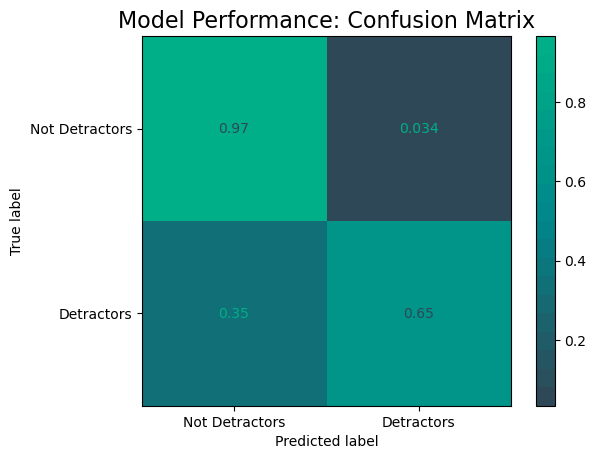

In [166]:
# Calling confusion matrix for resampled model
rs_cfn_matrix = confusion_matrix_display(rs_pipeline, y_test, rs_y_pred)

The resampling helped with the overall accuracy and the predictions became slightly more consistent by sentiment as well. Nevertheless the disparities between the classes remain high. 

I will try to improve the undersampling to hope to find a more suited ratio for the positive reviews.   

    5) ROC Curve and AUC

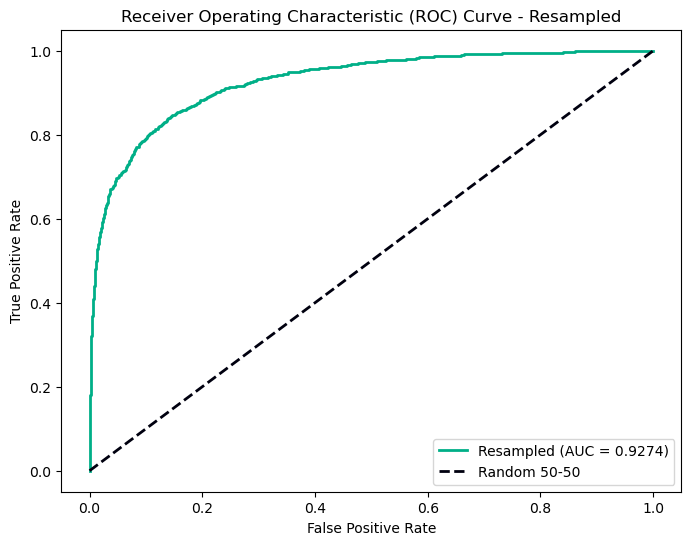

In [167]:
# Plotting the ROC curve for the baseline model
resamp_y_pred_proba = rs_pipeline.predict_proba(X_test['original_review'])[:, 1]
auc_resampled = plot_roc_curve(y_test, resamp_y_pred_proba, model_name=resampled_model_name)

In [168]:
# Printing the interpretation
auc_interpretation(auc_resampled)

AUC = 0.9274. The model has a great predictive power.


In [169]:
# Reminding the scores variables for easier commenting 
# auc_base
# auc_resampled

In [170]:
metrics_comparison('AUC', auc_base, auc_resampled)

AUC improved from 0.9110 to 0.9274.


In [171]:
# Appending each metric to the lists 
modelnames.append(resampled_model_name)
accuracies.append(accuracy_rs)
f1s.append(f1_rs)
recalls.append(recall_rs)
recalls_detractors.append(recall_detractors_rs)
cv_accs.append(cv_rs)
roc_aucs.append(auc_resampled)

### <u>3rd iteration</u>: Undersampling negative reviews: Sampling Strategy 

#### Sampling Strategy: 1

I will try to reach the same number of positive reviews than there are non_positive reviews. 
<br>To do so, I will apply a sampling strategy of 1. 

    1) Fitting and training on train data

In [172]:
# Importing relevant packages
from imblearn.under_sampling import RandomUnderSampler
import imblearn.pipeline

I will now include the Random Undersampler to our pipeline so it under samples our majority class. 

In [173]:
# Defining the pipeline steps
tfidf_vectorizer = TfidfVectorizer()
naive_bayes_classifier = MultinomialNB()

# Including the UnderSampler to the pipeline
rs1_pipeline = imblearn.pipeline.Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('us', RandomUnderSampler(sampling_strategy=1, random_state=42)),
    ('classifier', naive_bayes_classifier)
])

# Fitting the pipeline on X_train['original_review'] and y_train
rs1_pipeline.fit(X_train['original_review'], y_train)

rs1_y_pred = rs1_pipeline.predict(X_test['original_review']) 


In [174]:
# Verifying the value counts of each category, before undersampling
original_value_counts = y_train.value_counts()
print("Original class distribution:")
print(original_value_counts)

# Getting the indices of the resampled data
resampled_indices = rs1_pipeline.named_steps['us'].sample_indices_

# Verifying the new value counts of each category, after undersampling
resampled_value_counts = y_train.iloc[resampled_indices].value_counts()
print("\nClass distribution after undersampling:")
print(resampled_value_counts)


Original class distribution:
0    11320
1     4048
Name: Sentiment, dtype: int64

Class distribution after undersampling:
0    4048
1    4048
Name: Sentiment, dtype: int64


The not positive reviews were randomly undersampled from our model, which now has the exact same number of reviews for both sentiments. 

I will now run our evaluation metrics to review if the model is providing better predictions. 

    2) Evaluation Metrics

In [175]:
# Naming the model
resampled1_model_name = 'Sampling 1'

# Calling the function and recording into the defined values
accuracy_rs1, f1_rs1, recall_rs1, cv_rs1 = evaluation_metrics(
    y_test, 
    rs1_y_pred, 
    rs1_pipeline, 
    X_train['original_review'], 
    y_train)

Accuracy: 0.8312
F1-Score: 0.8378
Recall: 0.8312
Mean Cross-Validated Accuracy: 0.8442


In [176]:
# Comparing the evaluation metrics between baseline and Resampled model 
metrics_comparison('Accuracy', accuracy_rs, accuracy_rs1)
metrics_comparison('F1', f1_rs, f1_rs1)
metrics_comparison('Recall', recall_rs, recall_rs1)
metrics_comparison('Cross-validated Accuracy', cv_rs, cv_rs1)

Accuracy decreased from 0.8842 to 0.8312.
F1 decreased from 0.8784 to 0.8378.
Recall decreased from 0.8842 to 0.8312.
Cross-validated Accuracy decreased from 0.8836 to 0.8442.


In [177]:
# Printing the overall summary
print('The resampling with sampling strategy of 1 highly improved the overall scores')

The resampling with sampling strategy of 1 highly improved the overall scores


    3) Classification Report

In [178]:
# Calling confusion report for resampled model
resamp1_class_report, recall_detractors_rs1 = class_calculation(y_test, rs_y_pred)

Classification Report:
                 precision    recall  f1-score   support

Not Detractors    0.88667   0.96634   0.92479      3773
    Detractors    0.87438   0.65481   0.74884      1350

      accuracy                        0.88425      5123
     macro avg    0.88053   0.81058   0.83681      5123
  weighted avg    0.88343   0.88425   0.87843      5123



    4) Confusion Matrix

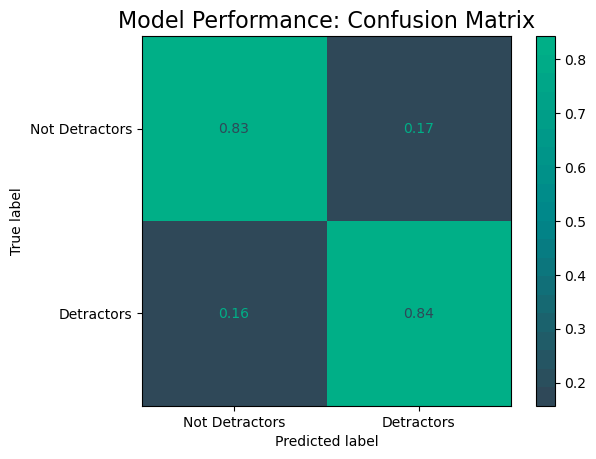

In [179]:
# Calling confusion matrix for resampled model
rs1_cfn_matrix = confusion_matrix_display(rs1_pipeline, y_test, rs1_y_pred)

-------------CHANGE-------------

Not only did the resampling helped with the overall accuracy, the predictions became much more consisten by sentiment as well: 

- Out of the instances predicted as positive, about 72.94% are correctly classified.
- Out of the instances predicted as not positive, about 81.18% are correctly classified.

While RECALL for each class still presents small disparities, recall showed a much better split between each sentiment: 
- 77% of predictions made as positive or not positive, actually were. 
- This compares to 92% for the not_positive class and 45% for the positive class on the previous model. 

-------------CHANGE-------------

    5) ROC Curve and AUC

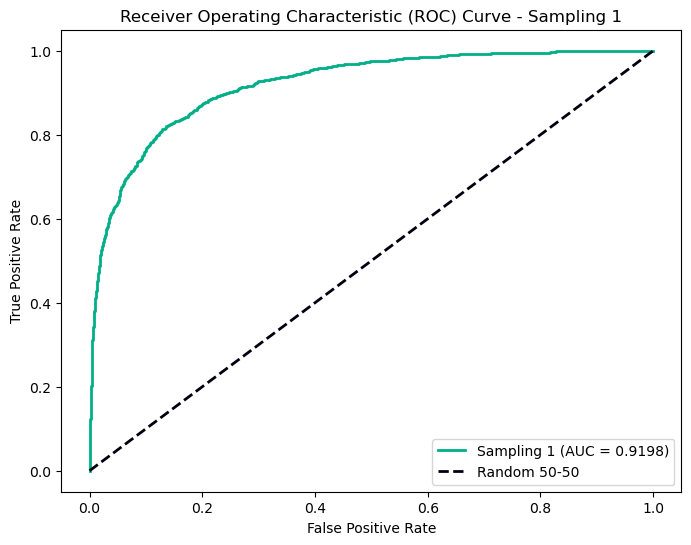

In [180]:
# Plotting the ROC curve for the baseline model
resamp1_y_pred_proba = rs1_pipeline.predict_proba(X_test['original_review'])[:, 1]
auc_resamp1 = plot_roc_curve(y_test, resamp1_y_pred_proba, model_name=resampled1_model_name)

In [181]:
# Printing the interpretation
auc_interpretation(auc_resamp1)

AUC = 0.9198. The model has a great predictive power.


In [182]:
metrics_comparison('AUC', auc_resampled, auc_resamp1)

AUC decreased from 0.9274 to 0.9198.


In [183]:
# Appending each metric to the lists 
modelnames.append(resampled1_model_name)
accuracies.append(accuracy_rs1)
f1s.append(f1_rs1)
recalls.append(recall_rs1)
recalls_detractors.append(recall_detractors_rs1)
cv_accs.append(cv_rs1)
roc_aucs.append(auc_resamp1)

### <u>4th iteration</u>: including stopwords

I will now test fitting the vectorizer by removing the stopwords from reviews to review if this can help predictions be more accurate.

    1) Fitting and training train data

In [184]:
# Defining the pipeline steps, including the stopwords_list created 
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords_list)
naive_bayes_classifier = MultinomialNB()

# Instantiating the pipeline with the undersampler and the new vectorizer
pipeline_nostop = imblearn.pipeline.Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('us', RandomUnderSampler(sampling_strategy=1, random_state=42)),
    ('classifier', naive_bayes_classifier)
])

# Fit the pipeline on X_train['original_review'] and y_train
pipeline_nostop.fit(X_train['original_review'], y_train)

# Generating predictions
nostop_y_pred = pipeline_nostop.predict(X_test['original_review'])

    2) Evaluation Metrics

In [185]:
# Naming the model
nostop_model_name = 'No Stopwords'

# Calling the function and recording into the defined values
accuracy_nostop, f1_nostop, recall_nostop, cv_nostop = evaluation_metrics(
    y_test, 
    nostop_y_pred, 
    pipeline_nostop, 
    X_train['original_review'], 
    y_train)

Accuracy: 0.8319
F1-Score: 0.8382
Recall: 0.8319
Mean Cross-Validated Accuracy: 0.8466


In [186]:
# Comparing the evaluation metrics between baseline and Resampled model 
metrics_comparison('Accuracy', accuracy_rs1, accuracy_nostop)
metrics_comparison('F1', f1_rs1, f1_nostop)
metrics_comparison('Recall', recall_rs1, recall_nostop)
metrics_comparison('Cross-validated Accuracy', cv_rs1, cv_nostop)

Accuracy improved from 0.8312 to 0.8319.
F1 improved from 0.8378 to 0.8382.
Recall improved from 0.8312 to 0.8319.
Cross-validated Accuracy improved from 0.8442 to 0.8466.


In [187]:
# Printing the overall summary
print('Removing stopwords improved most scores, but RECALL.')

Removing stopwords improved most scores, but RECALL.


    3) Classification Report

In [188]:
# Calling the classification function
nostop_class_report, recall_detractors_nostop = class_calculation(y_test, nostop_y_pred)

Classification Report:
                 precision    recall  f1-score   support

Not Detractors    0.93308   0.83143   0.87933      3773
    Detractors    0.63884   0.83333   0.72324      1350

      accuracy                        0.83193      5123
     macro avg    0.78596   0.83238   0.80128      5123
  weighted avg    0.85554   0.83193   0.83820      5123



    4) Confusion Matrix

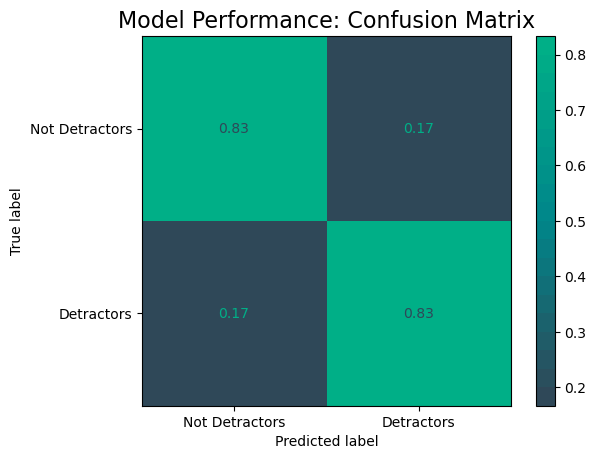

In [189]:
# Calling the confusion matrix function
nostop_cfn_matrix = confusion_matrix_display(pipeline_nostop, y_test, nostop_y_pred)

Nevertheless, the true predictions of positive reviews improved: 78% of predictions made as positive, actually were, compared to 77% previously.

    5) ROC Curve and AUC

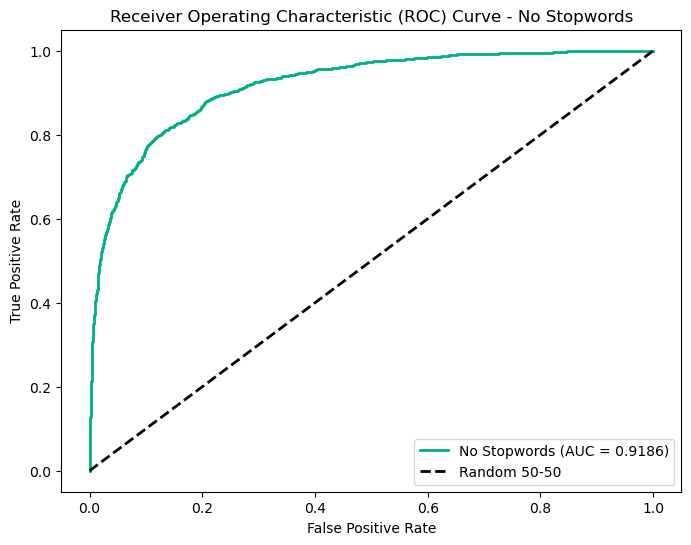

In [190]:
# Plotting the ROC curve for the baseline model
nostop_y_pred_proba = pipeline_nostop.predict_proba(X_test['original_review'])[:, 1]
auc_nostop = plot_roc_curve(y_test, nostop_y_pred_proba, model_name=nostop_model_name)

In [191]:
# Printing the interpretation
auc_interpretation(auc_nostop)

AUC = 0.9186. The model has a great predictive power.


In [192]:
metrics_comparison('AUC', auc_resamp1, auc_nostop)

AUC decreased from 0.9198 to 0.9186.


In [193]:
# Appending each metric to the lists 
modelnames.append(nostop_model_name)
accuracies.append(accuracy_nostop)
f1s.append(f1_nostop)
recalls.append(recall_nostop)
recalls_detractors.append(recall_detractors_nostop)
cv_accs.append(cv_nostop)
roc_aucs.append(auc_nostop)

### <u>5th iteration</u>: including only the industry specific stopwords

For analysis purposes, I had removed a list of industry specific stopwords which came up often and were as present on the positive than not_positive reviews without adding specific meaning to them. 

I will test our model on by including only this list as stopwords. 

    1) Fitting and training train data

In [194]:
# Reminding the list of industry specific stopwords 
new_stopwords

['hotel', 'room', 'night', 'day', 'stay', 'resort', 'place']

In [195]:
# Defining the pipeline steps, including the stopwords_list created 
tfidf_vectorizer = TfidfVectorizer(stop_words=new_stopwords)
naive_bayes_classifier = MultinomialNB()

# Instantiating the pipeline with the undersampler and the new vectorizer
pipeline_nonewstop = imblearn.pipeline.Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('us', RandomUnderSampler(sampling_strategy=1, random_state=42)),
    ('classifier', naive_bayes_classifier)
])

# Fit the pipeline on X_train['original_review'] and y_train
pipeline_nonewstop.fit(X_train['original_review'], y_train)

# Generating predictions
nonewstop_y_pred = pipeline_nonewstop.predict(X_test['original_review'])

    2) Evaluation Metrics

In [196]:
# Naming the model
nonewstop_model_name = 'Industry Stopwords'

# Calling the function and recording into the defined values
accuracy_nonewstop, f1_nonewstop, recall_nonewstop, cv_nonewstop = evaluation_metrics(
    y_test, 
    nonewstop_y_pred, 
    pipeline_nonewstop, 
    X_train['original_review'], 
    y_train)

Accuracy: 0.8331
F1-Score: 0.8396
Recall: 0.8331
Mean Cross-Validated Accuracy: 0.8460


The accuracy score now increased slightly, however it remains below just guessing the majority class.

In [197]:
# Comparing the evaluation metrics between baseline and Resampled model 
metrics_comparison('Accuracy', accuracy_nostop, accuracy_nonewstop)
metrics_comparison('F1', f1_nostop, f1_nonewstop)
metrics_comparison('Recall', recall_nostop, recall_nonewstop)
metrics_comparison('Cross-validated Accuracy', cv_nostop, cv_nonewstop)

Accuracy improved from 0.8319 to 0.8331.
F1 improved from 0.8382 to 0.8396.
Recall improved from 0.8319 to 0.8331.
Cross-validated Accuracy decreased from 0.8466 to 0.8460.


In [198]:
# Printing the overall summary
print('Including Industry stopwords improved scores compared to including English stopwords.')

Including Industry stopwords improved scores compared to including English stopwords.


In [199]:
# Comparing the evaluation metrics between undersampled model and no industry stopwords model 
metrics_comparison('Accuracy', accuracy_rs1, accuracy_nonewstop)
metrics_comparison('F1', f1_rs1, f1_nonewstop)
metrics_comparison('Recall', recall_rs1, recall_nonewstop)
metrics_comparison('Cross-validated Accuracy', cv_rs1, cv_nonewstop)

Accuracy improved from 0.8312 to 0.8331.
F1 improved from 0.8378 to 0.8396.
Recall improved from 0.8312 to 0.8331.
Cross-validated Accuracy improved from 0.8442 to 0.8460.


In [200]:
# Printing the overall summary
print('The overall scores recorded higher results when new stopwords were removed.')

The overall scores recorded higher results when new stopwords were removed.


    3) Classification Report

In [201]:
# Calling the classification function
nonewstop_class_report, recall_detractors_nonewstop = class_calculation(y_test, nonewstop_y_pred)

Classification Report:
                 precision    recall  f1-score   support

Not Detractors    0.93709   0.82905   0.87976      3773
    Detractors    0.63866   0.84444   0.72727      1350

      accuracy                        0.83311      5123
     macro avg    0.78787   0.83675   0.80352      5123
  weighted avg    0.85845   0.83311   0.83958      5123



    4) Confusion Matrix

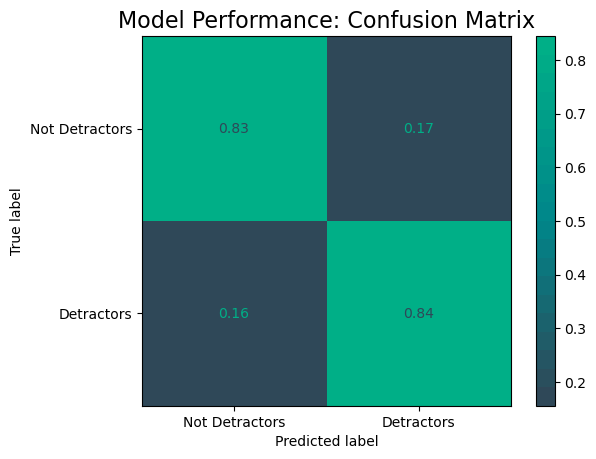

In [202]:
# Calling the confusion matrix function
nonewstop_cfn_matrix = confusion_matrix_display(pipeline_nonewstop, y_test, nonewstop_y_pred)

    5) ROC Curve and AUC

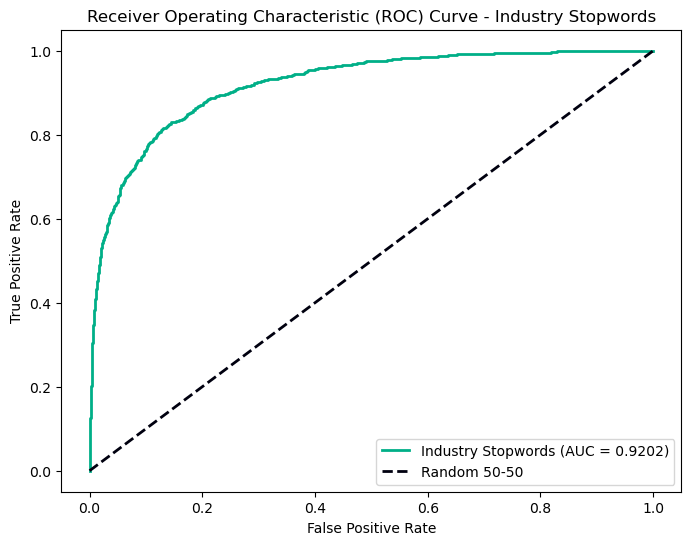

In [203]:
# Plotting the ROC curve for the baseline model
nonewstop_y_pred_proba = pipeline_nonewstop.predict_proba(X_test['original_review'])[:, 1]
auc_nonewstop = plot_roc_curve(y_test, nonewstop_y_pred_proba, model_name=nonewstop_model_name)

In [204]:
# Printing the interpretation
auc_interpretation(auc_nonewstop)

AUC = 0.9202. The model has a great predictive power.


In [205]:
# Interpreting AUC:
print('Compared to the last run model: ')
metrics_comparison('AUC', auc_nostop, auc_nonewstop)
print()

Compared to the last run model: 
AUC improved from 0.9186 to 0.9202.



In [206]:
# Appending each metric to the lists 
modelnames.append(nonewstop_model_name)
accuracies.append(accuracy_nonewstop)
f1s.append(f1_nonewstop)
recalls.append(recall_nonewstop)
recalls_detractors.append(recall_detractors_nonewstop)
cv_accs.append(cv_nonewstop)
roc_aucs.append(auc_nonewstop)

### <u>6th iteration</u>: adding both English and industry stopwords

For analysis purposes, I had removed a list of industry specific stopwords which came up often and were as present on the positive than not_positive reviews without adding specific meaning to them. 

I will test our model on by including only this list as stopwords. 

    1) Fitting and training train data

I will create a new list of stopwords as a copy of the existing one, so the industry stopwords can be added to it. 

In [207]:
# Reminding the list of English stopwords 
stopwords_list[:3] # is the one including all English stopwords. 

['i', 'me', 'my']

In [208]:
# Reminding the list of industry specific stopwords 
new_stopwords # includes industry specific stopwords

['hotel', 'room', 'night', 'day', 'stay', 'resort', 'place']

In [209]:
# Creating a new list to combine both stopwords lists
full_stopwords = stopwords_list.copy()

# Adding the new_stopwords to the existing list
full_stopwords.extend(new_stopwords)

In [210]:
# Verifying the list of new_stopwords were added to the stopwords list
assert full_stopwords[-len(new_stopwords):] == new_stopwords

In [211]:
# Defining the pipeline steps, including the new stopwords_list created 
tfidf_vectorizer = TfidfVectorizer(stop_words=full_stopwords)
naive_bayes_classifier = MultinomialNB()

# Instantiating the pipeline with the undersampler and the new vectorizer
pipeline_fullstop = imblearn.pipeline.Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('us', RandomUnderSampler(sampling_strategy=1, random_state=42)),
    ('classifier', naive_bayes_classifier)
])

# Fit the pipeline on X_train['original_review'] and y_train
pipeline_fullstop.fit(X_train['original_review'], y_train)

# Generating predictions
fullstop_y_pred = pipeline_fullstop.predict(X_test['original_review'])

    2) Evaluation Metrics

In [212]:
# Naming the model
fullstop_model_name = 'Full Stopwords'

# Calling the function and recording into the defined values
accuracy_fullstop, f1_fullstop, recall_fullstop, cv_fullstop = evaluation_metrics(
    y_test, 
    fullstop_y_pred, 
    pipeline_fullstop, 
    X_train['original_review'], 
    y_train)

Accuracy: 0.8345
F1-Score: 0.8405
Recall: 0.8345
Mean Cross-Validated Accuracy: 0.8481


The accuracy score now increased slightly, however it remains below just guessing the majority class.

In [213]:
# Comparing the evaluation metrics between baseline and Resampled model 
metrics_comparison('Accuracy', accuracy_nonewstop, accuracy_fullstop)
metrics_comparison('F1', f1_nonewstop, f1_fullstop)
metrics_comparison('Recall', recall_nonewstop, recall_fullstop)
metrics_comparison('Cross-validated Accuracy', cv_nonewstop, cv_fullstop)

Accuracy improved from 0.8331 to 0.8345.
F1 improved from 0.8396 to 0.8405.
Recall improved from 0.8331 to 0.8345.
Cross-validated Accuracy improved from 0.8460 to 0.8481.


In [214]:
# Printing the overall summary
print('Including full list of stopwords improved scores.')

Including full list of stopwords improved scores.


    3) Classification Report

In [215]:
# Calling the classification function
fullstop_class_report, recall_detractors_fullstop = class_calculation(y_test, fullstop_y_pred)

Classification Report:
                 precision    recall  f1-score   support

Not Detractors    0.93308   0.83514   0.88140      3773
    Detractors    0.64376   0.83259   0.72610      1350

      accuracy                        0.83447      5123
     macro avg    0.78842   0.83387   0.80375      5123
  weighted avg    0.85684   0.83447   0.84047      5123



    4) Confusion Matrix

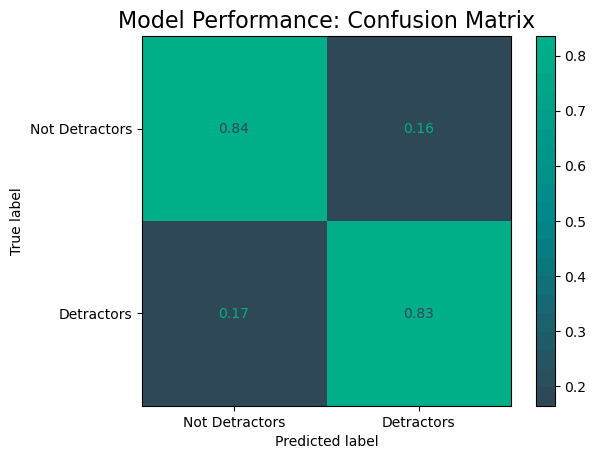

In [216]:
# Calling the confusion matrix function
fullstop_cfn_matrix = confusion_matrix_display(pipeline_fullstop, y_test, fullstop_y_pred)

    5) ROC Curve and AUC

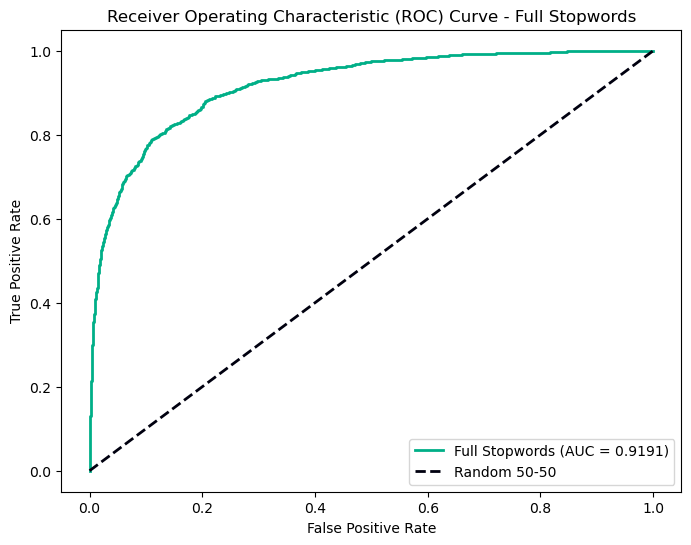

In [217]:
# Plotting the ROC curve for the baseline model
fullstop_y_pred_proba = pipeline_fullstop.predict_proba(X_test['original_review'])[:, 1]
auc_fullstop = plot_roc_curve(y_test, fullstop_y_pred_proba, model_name=fullstop_model_name)

In [218]:
# Printing the interpretation
auc_interpretation(auc_fullstop)

AUC = 0.9191. The model has a great predictive power.


In [219]:
# Interpreting AUC:
print('Compared to the last run model: ')
metrics_comparison('AUC', auc_nonewstop, auc_fullstop)
print()


Compared to the last run model: 
AUC decreased from 0.9202 to 0.9191.



In [220]:
# Appending each metric to the lists 
modelnames.append(fullstop_model_name)
accuracies.append(accuracy_fullstop)
f1s.append(f1_fullstop)
recalls.append(recall_fullstop)
recalls_detractors.append(recall_detractors_fullstop)
cv_accs.append(cv_fullstop)
roc_aucs.append(auc_fullstop)

### <u>7th iteration</u>: Lemmatized Reviews

Models perform better when stopwords are not included. Let's now review how it compares when it runs of lemmatized words. 

    1) Fitting and training train data

For the exploratory analysis, some adjectives were included in this list, however they would be important to help predicting the sentiment of the review. They will be dropped from this list so they are still considered by the model.  

In [221]:
# Only lemmatizing X_train['lemm_review ']
X_train['lemmatized_review'] = X_train['original_review'].apply(lambda x: tokenizer.tokenize(x))
X_train['lemmatized_review'] = X_train['lemmatized_review'].apply(lambda tokens: [lemmatizer.lemmatize(token, pos='v') for token in tokens])

In [222]:
# Storing outside a list 
X_train['lemmatized_review'] = X_train['lemmatized_review'].apply(lambda x: ' '.join(x))

In [223]:
# Viewing the newly created column
X_train[:3]

Review  \
1282                                                                                                                                                                                                                                                                                                                                                                                                                                                  [gem, pleasantly, surprise, accomondations, helpful, attentive, staff, need, breakfast, good, cookies, lovely, clean, comfortable, front, bush, street, bite, noisy, away, enjoyment, nice, boutique, definitely, time]   
10661                                                                                                                                                                                                                                         [love, fita, wife, spend, nights, fita, march, 2008, staff, fantastic, helpful, pleasant, recommend, travel, amsterdam, locate, minute, walk, van, gogh, rijks, museums, 10, minute, walk, leidsplein, variety, store, shop, restaurants, locate, tram, stop, directly, easy, access, entire, city, walk, fita, way, center, city, 30, minutes, beautiful, accesible, friendly, definately, travel, fita, wonderful, amsterdam]   
17908  [great, modern, fantastic, price, begin, april, alot, review, say, bad, area, really, literally, 100m, away, nice, redevelop, area, 10min, walk, beach, partner, arrive, late, barcelona, decide, walk, bus, station, order, bar, quite, long, walk, 50mins, roughly, really, great, thing, order, sight, tourists, dont, usually, arrive, check, quick, painless, really, really, nice, fantastic, modern, design, little, extras, want, order, barcelona, partner, opt, bus, turistic, stop, far, go, virtually, worth, short, visit, wish, spend, longer, wish, swim, pool, roof, open, overall, fantastic, price, pay, dont, distance, centre, transport, options]   

       Rating           label  \
1282        4  not_detractors   
10661       5  not_detractors   
17908       5  not_detractors   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      original_review  \
1282                                                                                                                                                                                                                                                                                                                                                                                                                                                            gem, pleasantly surprised accomondations helpful attentive staff need, breakfast good cookies, room lovely clean comfortable, room fronting bush street bit noisy did not away enjoyment nice boutique hotel, definitely stay time,     
10661                                                                                                                                                                                                                                                            loved fita wife spent nights hotel fita march 2008. hotel staff fantastic helpful pleasant, recommend hotel traveling amsterdam.the hotel located minute walk van gogh rijks museums 10 minute walk leidsplein variety stores shops restaurants located.there tram stop di

In [224]:
# Applying the same to X_test

X_test['lemmatized_review'] = X_test['original_review'].apply(lambda x: tokenizer.tokenize(x))
X_test['lemmatized_review'] = X_test['lemmatized_review'].apply(lambda tokens: [lemmatizer.lemmatize(token, pos='v') for token in tokens])
X_test['lemmatized_review'] = X_test['lemmatized_review'].apply(lambda x: ' '.join(x))

In [225]:
# Defining the pipeline steps, including full stopwords and on lemmatized 
tfidf_vectorizer = TfidfVectorizer(stop_words=full_stopwords)
naive_bayes_classifier = MultinomialNB()

# Instantiating the pipeline with the undersampler and the new vectorizer
pipeline_lemm = imblearn.pipeline.Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('us', RandomUnderSampler(sampling_strategy=1, random_state=42)),
    ('classifier', naive_bayes_classifier)
])

# Fit the pipeline on X_train['original_review'] and y_train
pipeline_lemm.fit(X_train['lemmatized_review'], y_train)

# Generating predictions
lemm_y_pred = pipeline_lemm.predict(X_test['lemmatized_review'])

    2) Evaluation Metrics

In [226]:
# Naming the model
lemm_model_name = 'Lemmatized'

# Calling the function and recording into the defined values
accuracy_lemm, f1_lemm, recall_lemm, cv_lemm = evaluation_metrics(
    y_test, 
    lemm_y_pred, 
    pipeline_lemm, 
    X_train['lemmatized_review'], 
    y_train)

Accuracy: 0.8288
F1-Score: 0.8358
Recall: 0.8288
Mean Cross-Validated Accuracy: 0.8403


In [227]:
# Comparing the evaluation metrics between undersampled model (best model) and no industry stopwords model 
metrics_comparison('Accuracy', accuracy_fullstop, accuracy_lemm)
metrics_comparison('F1', f1_fullstop, f1_lemm)
metrics_comparison('Recall', recall_fullstop, recall_lemm)
metrics_comparison('Cross-validated Accuracy', cv_fullstop, cv_lemm)

Accuracy decreased from 0.8345 to 0.8288.
F1 decreased from 0.8405 to 0.8358.
Recall decreased from 0.8345 to 0.8288.
Cross-validated Accuracy decreased from 0.8481 to 0.8403.


In [228]:
# Printing the overall summary
print('Most scores decreased slightly.')

Most scores decreased slightly.


    3) Classification Report

In [229]:
# Calling the classification function
lemm_class_report, recall_detractors_lemm = class_calculation(y_test, lemm_y_pred)

Classification Report:
                 precision    recall  f1-score   support

Not Detractors    0.93773   0.82216   0.87615      3773
    Detractors    0.63030   0.84741   0.72291      1350

      accuracy                        0.82881      5123
     macro avg    0.78401   0.83478   0.79953      5123
  weighted avg    0.85672   0.82881   0.83577      5123



    4) Confusion Matrix

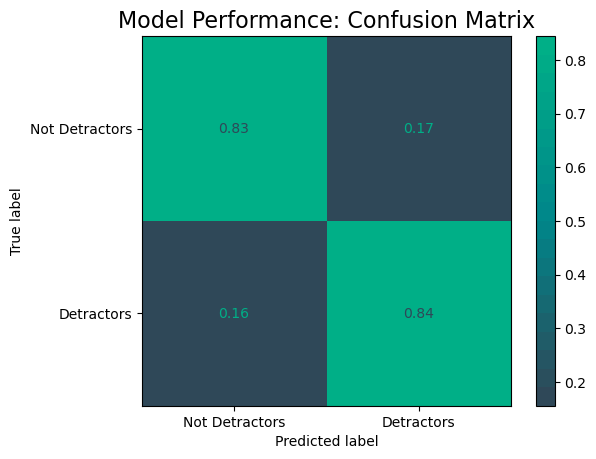

In [230]:
# Calling the confusion matrix function
nonewstop_cfn_matrix = confusion_matrix_display(pipeline_nonewstop, y_test, nonewstop_y_pred)

    5) ROC Curve and AUC

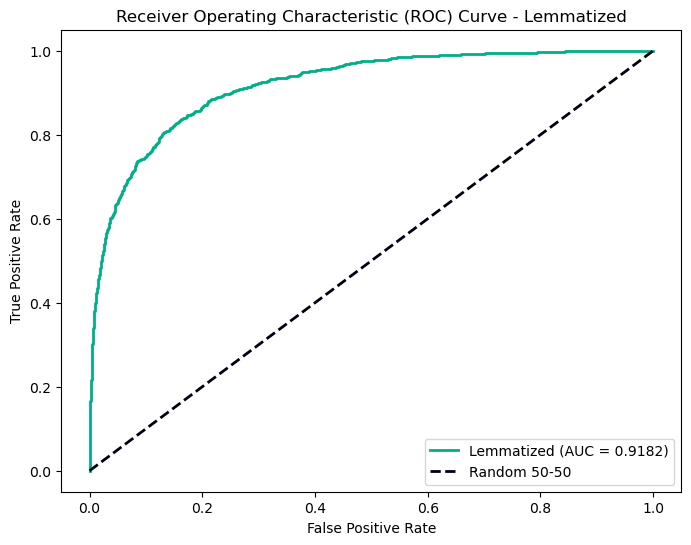

In [231]:
# Plotting the ROC curve for the baseline model
lemm_y_pred_proba = pipeline_lemm.predict_proba(X_test['lemmatized_review'])[:, 1]
auc_lemm = plot_roc_curve(y_test, lemm_y_pred_proba, model_name=lemm_model_name)

In [232]:
# Printing the interpretation
auc_interpretation(auc_lemm)

AUC = 0.9182. The model has a great predictive power.


In [233]:
# Interpreting AUC:
print('Compared to the last run model: ')
metrics_comparison('AUC', auc_fullstop, auc_lemm)
print()

Compared to the last run model: 
AUC decreased from 0.9191 to 0.9182.



In [234]:
# Appending each metric to the lists 
modelnames.append(lemm_model_name)
accuracies.append(accuracy_lemm)
f1s.append(f1_lemm)
recalls.append(recall_lemm)
recalls_detractors.append(recall_detractors_lemm)
cv_accs.append(cv_lemm)
roc_aucs.append(auc_lemm)

### <u>8th iteration</u>: Training on the fully preprocessed reviews

    1) Fitting and training on train data

In [235]:
# Not applying stopwords to the vectorizer, as they were applied to the preprocessed reviews.

In [236]:
# Defining the pipeline steps 
tfidf_vectorizer = TfidfVectorizer()
naive_bayes_classifier = MultinomialNB()

# Instantiating the pipeline with the undersampler and the new vectorizer
pipeline_prep = imblearn.pipeline.Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('us', RandomUnderSampler(sampling_strategy=1, random_state=42)),
    ('classifier', naive_bayes_classifier)
])

# Fitting the pipeline on X_train and X_test['Review_prep_nolist'] which contains the fully preprocessed Reviews
pipeline_prep.fit(X_train['Review_prep_nolist'], y_train)

# Generating predictions
prep_y_pred = pipeline_prep.predict(X_test['Review_prep_nolist'])

    2) Evaluation Metrics

In [237]:
pp_model_name = 'Preprocessed'

# Calling the function and recording into the defined values
accuracy_pp, f1_pp, recall_pp, cv_pp = evaluation_metrics(
    y_test, 
    prep_y_pred, 
    pipeline_prep, 
    X_train['Review_prep_nolist'], 
    y_train)

Accuracy: 0.8271
F1-Score: 0.8341
Recall: 0.8271
Mean Cross-Validated Accuracy: 0.8404


In [238]:
# Comparing the evaluation metrics between undersampled model (best model) and no industry stopwords model 
metrics_comparison('Accuracy', accuracy_rs1, accuracy_pp)
metrics_comparison('F1', f1_rs1, f1_pp)
metrics_comparison('Recall', recall_rs1, recall_pp)
metrics_comparison('Cross-validated Accuracy', cv_rs1, cv_pp)

Accuracy decreased from 0.8312 to 0.8271.
F1 decreased from 0.8378 to 0.8341.
Recall decreased from 0.8312 to 0.8271.
Cross-validated Accuracy decreased from 0.8442 to 0.8404.


In [239]:
# Printing the overall summary
print('Change this.')

Change this.


    3) Classification Report

In [240]:
# Drawing the classification report 
prep_class_report, recall_detractors_prep = class_calculation(y_test, prep_y_pred)

Classification Report:
                 precision    recall  f1-score   support

Not Detractors    0.93703   0.82030   0.87479      3773
    Detractors    0.62747   0.84593   0.72050      1350

      accuracy                        0.82705      5123
     macro avg    0.78225   0.83311   0.79765      5123
  weighted avg    0.85545   0.82705   0.83413      5123



    4) Confusion Matrix

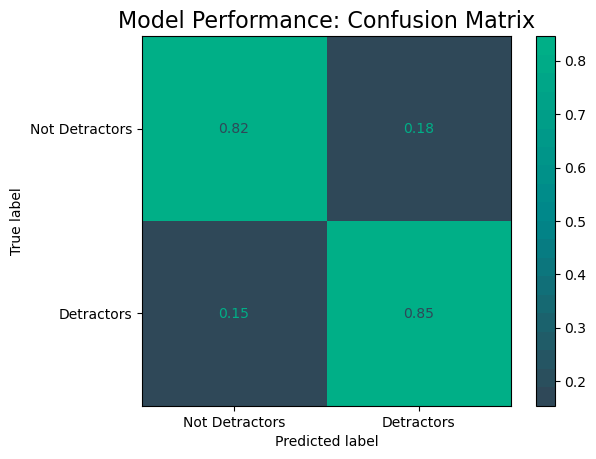

In [241]:
# Plotting the confusion matrix
prep_cnf_matrix = confusion_matrix_display(pipeline_prep, y_test, prep_y_pred)

    5) ROC Curve and AUC

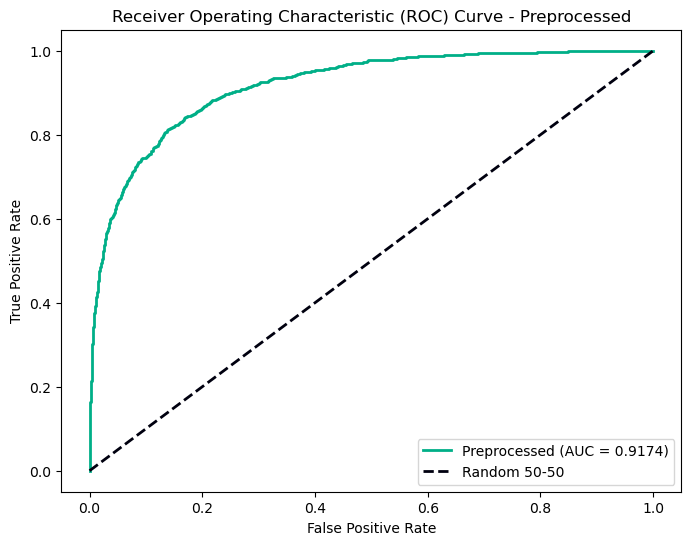

In [242]:
# Plotting the ROC curve for the baseline model
prep_y_pred_proba = pipeline_prep.predict_proba(X_test['Review_prep_nolist'])[:, 1]
auc_pp = plot_roc_curve(y_test, prep_y_pred_proba, model_name=pp_model_name)

In [243]:
# Printing the interpretation
auc_interpretation(auc_pp)

AUC = 0.9174. The model has a great predictive power.


In [244]:
# Interpreting AUC:
print('Compared to the last run model: ')
metrics_comparison('AUC', auc_lemm, auc_pp)
print()


Compared to the last run model: 
AUC decreased from 0.9182 to 0.9174.



In [245]:
# Appending each metric to the lists 
modelnames.append(pp_model_name)
accuracies.append(accuracy_pp)
f1s.append(f1_pp)
recalls.append(recall_pp)
recalls_detractors.append(recall_detractors_prep)
cv_accs.append(cv_pp)
roc_aucs.append(auc_pp)

### <u>9th iteration</u>: Tuning Tfidf Vectorizer - Hyperparameter tuning

The model performed better when stopwords were removed but worse when applied on the full tokenized reviews. Let's try to use combinatoric grid searching to find the best parameters for the vectorizer. 

    1) Fitting and training on train data

In [246]:
from sklearn.model_selection import GridSearchCV

# Defining the pipeline steps, excluding any manual input of features, with the vectorizer and classifier
# The pipeline still includes the undersampler to ensure class imbalance is addressed
gs_pipeline = imblearn.pipeline.Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('us', RandomUnderSampler(sampling_strategy=1, random_state=42)),
    ('classifier', MultinomialNB())
])

# Define the parameter grid to search over
parameters = {
    'tfidf__max_features': [100, None],
    'tfidf__max_df': [0.7, 0.9],
    'tfidf__min_df': [1, 3],
    'tfidf__sublinear_tf': [True, False],
#     'tfidf__ngram_range': [(1, 1), (2, 2)],
    # including the list of stopwords that was defined earlier 
    'tfidf__stop_words': [stopwords_list, new_stopwords, full_stopwords],
}


In [247]:
# Performing grid search for hyperparameter tuning
grid_search = GridSearchCV(gs_pipeline, parameters, cv=5, scoring='accuracy', error_score='raise')

# Fitting the tuned pipeline on training data
grid_search.fit(X_train['original_review'], y_train)
# grid_search.fit(X_train['lemmatized_review'], y_train)


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('us',
                                        RandomUnderSampler(random_state=42,
                                                           sampling_strategy=1)),
                                       ('classifier', MultinomialNB())]),
             param_grid={'tfidf__max_df': [0.7, 0.9],
                         'tfidf__max_features': [100, None],
                         'tfidf__min_df': [1, 3],
                         'tfidf__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                                'our', 'ours', 'ourse...
                                                'itself', ...],
                                               ['hotel', 'room', 'night', 'day',
                                                'stay', 'resort', 'place'],
                                               ['i', 'me', 'my', 'myself', 'we',
                                                'our', 'ours', 'ourselves',
                                                'you', "you're", "you've",
                                                "you'll", "you'd", 'your',
                                                'yours', 'yourself',
                                                'yourselves', 'he', 'him',
                                                'his', 'himself', 'she',
                                                "she's", 'her', 'hers',
                                                'herself', 'it', "it's", 'its',
                                                'itself', ...]],
                         'tfidf__sublinear_tf': [True, False]},
             scoring='accuracy')

In [248]:
# Recording the best parameters and printing them
best_tfidf_params = grid_search.best_params_

# Recording the best estimator as the best_pipeline
best_pipeline = grid_search.best_estimator_

print("Best Parameters:", best_tfidf_params)


Best Parameters: {'tfidf__max_df': 0.7, 'tfidf__max_features': None, 'tfidf__min_df': 3, 'tfidf__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'eac

In [249]:
# Fitting the best pipeline on training data
best_pipeline.fit(X_train['original_review'], y_train)

# Fitting the best model on the full training data
best_gs_y_pred = best_pipeline.predict(X_test['original_review'])

    2) Evaluation Metrics

In [250]:
# Naming the model
gs_model_name = 'NaiveBayes'

# Calling the function and recording into the defined values
accuracy_gs, f1_gs, recall_gs, cv_gs = evaluation_metrics(
    y_test, 
    best_gs_y_pred, 
    best_pipeline, 
    X_train['original_review'], 
    y_train)

Accuracy: 0.8495
F1-Score: 0.8536
Recall: 0.8495
Mean Cross-Validated Accuracy: 0.8599


In [251]:
# Comparing the evaluation metrics between undersampled model (best model) and no industry stopwords model 
metrics_comparison('Accuracy', accuracy_fullstop, accuracy_gs)
metrics_comparison('F1', f1_fullstop, f1_gs)
metrics_comparison('Recall', recall_fullstop, recall_gs)
metrics_comparison('Cross-validated Accuracy', cv_fullstop, cv_gs)

Accuracy improved from 0.8345 to 0.8495.
F1 improved from 0.8405 to 0.8536.
Recall improved from 0.8345 to 0.8495.
Cross-validated Accuracy improved from 0.8481 to 0.8599.


In [252]:
# Printing the overall summary
print('Change this.')

Change this.


    3) Classification Report

In [253]:
# Calling the classification report function
tuned_class_report, recall_detractors_gs = class_calculation(y_test, best_gs_y_pred)

Classification Report:
                 precision    recall  f1-score   support

Not Detractors    0.92935   0.86112   0.89393      3773
    Detractors    0.67793   0.81704   0.74101      1350

      accuracy                        0.84950      5123
     macro avg    0.80364   0.83908   0.81747      5123
  weighted avg    0.86310   0.84950   0.85364      5123



    4) Confusion Matrix

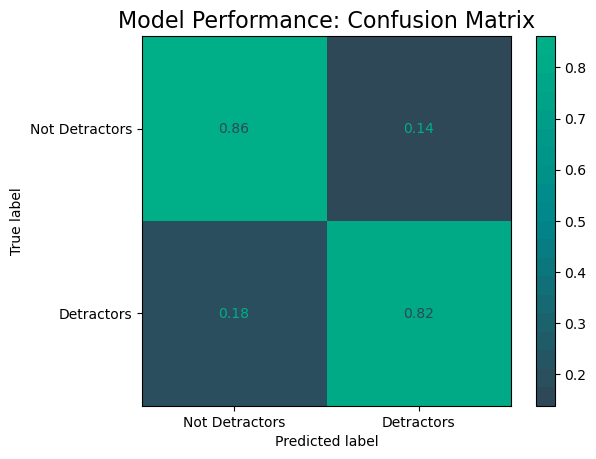

In [254]:
# Plotting the confusion matrix
gs_cfn_matrix = confusion_matrix_display(best_pipeline, y_test, best_gs_y_pred)

    5) ROC Curve and AUC

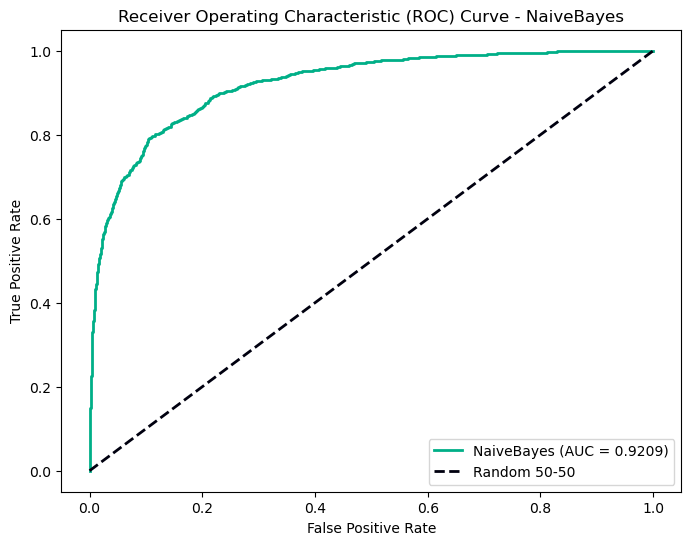

In [255]:
# Plotting the ROC curve for the baseline model
gs_y_pred_proba = best_pipeline.predict_proba(X_test['original_review'])[:, 1]
auc_gs = plot_roc_curve(y_test, gs_y_pred_proba, model_name=gs_model_name)

In [256]:
# Printing the interpretation
auc_interpretation(auc_gs)

AUC = 0.9209. The model has a great predictive power.


In [257]:
# Interpreting AUC:
print('Compared to the last run model: ')
metrics_comparison('AUC', auc_pp, auc_gs)
print()


# # Interpreting AUC:
# print('Compared to the best model so far: ')
# metrics_comparison('AUC', auc_resamp1, auc_prep)

Compared to the last run model: 
AUC improved from 0.9174 to 0.9209.



In [258]:
# Appending each metric to the lists 
modelnames.append(gs_model_name)
accuracies.append(accuracy_gs)
f1s.append(f1_gs)
recalls.append(recall_gs)
recalls_detractors.append(recall_detractors_gs)
cv_accs.append(cv_gs)
roc_aucs.append(auc_gs)

### 5. d) TfidfVectorizer and K-Nearest Neighbor

### <u>10th iteration</u>: K-Nearest Neighbor Tfidf Vectorizer

    1) Fitting and training on train data

The previous model was a bit computationally expensive. Let's see if the simpler K-Nearest Neighbor classifier would improve on that end. Nevertheless, kNN makes predictions based on what similar cases around it suggest so there is a risk it captures more noise created by the imbalanced dataset, despite the undersampled negative reviews.

For higher computing performance, the best parameters recorded on the vectorizer with Multinomial Naive Bayes will be kept. Only the classifier will be modified. Let's see if, by using the best TF-IDF parameters with another classifier, I can improve further these predictions.

In [259]:
# Verifying the best vectorizer parameters 
print(best_tfidf_params)

{'tfidf__max_df': 0.7, 'tfidf__max_features': None, 'tfidf__min_df': 3, 'tfidf__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more'

In [260]:
# Creating a function that modifies the parameters, to allow them to be used for future classifiers
def transform_params(best_params):    
    new_best_params = {}
    for key, value in best_params.items():
        # Removing 'tfidf__' from the key
        new_key = key.replace('tfidf__', '')
        new_best_params[new_key] = value
    return new_best_params

In [261]:
# Calling the newly defined parameters 
new_best_tfidf_params = transform_params(best_tfidf_params)

# Inspecting them
print(new_best_tfidf_params)

{'max_df': 0.7, 'max_features': None, 'min_df': 3, 'stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', '

In [262]:
from sklearn.neighbors import KNeighborsClassifier

# Defining the pipeline with the fixed tfidf parameters and RandomForestClassifier
knn_pipeline = imblearn.pipeline.Pipeline([
    ('tfidf', TfidfVectorizer(**new_best_tfidf_params)),
    ('us', RandomUnderSampler(sampling_strategy=1, random_state=42)),
    ('classifier', KNeighborsClassifier())
])

# Fitting the pipeline on training data
knn_pipeline.fit(X_train['original_review'], y_train)

# Making predictions on test data
knn_y_pred = knn_pipeline.predict(X_test['original_review'])

    2) Evaluation Metrics

In [263]:
# Naming the model and calling the function to evaluate it
knn_model_name = 'kNN'


# Calling the function and recording into the defined values
accuracy_knn, f1_knn, recall_knn, cv_knn = evaluation_metrics(
    y_test,
    knn_y_pred,
    knn_pipeline,
    X_train['original_review'],
    y_train
)


Accuracy: 0.7587
F1-Score: 0.7664
Recall: 0.7587
Mean Cross-Validated Accuracy: 0.7749


In [264]:
# Comparing the evaluation metrics between undersampled model (best model) and no industry stopwords model 
metrics_comparison('Accuracy', accuracy_gs, accuracy_knn)
metrics_comparison('F1', f1_gs, f1_knn)
metrics_comparison('recall', recall_gs, recall_knn)
metrics_comparison('Cross-validated Accuracy', cv_gs, cv_knn)

Accuracy decreased from 0.8495 to 0.7587.
F1 decreased from 0.8536 to 0.7664.
recall decreased from 0.8495 to 0.7587.
Cross-validated Accuracy decreased from 0.8599 to 0.7749.


In [265]:
# Printing the overall summary
print('change.')

change.


    3) Classification Report

In [266]:
# Calling the function
knn_class_report, recall_detractors_knn = class_calculation(y_test, knn_y_pred)

Classification Report:
                 precision    recall  f1-score   support

Not Detractors    0.86886   0.79194   0.82862      3773
    Detractors    0.53385   0.66593   0.59262      1350

      accuracy                        0.75874      5123
     macro avg    0.70135   0.72893   0.71062      5123
  weighted avg    0.78058   0.75874   0.76643      5123



    4) Confusion Matrix

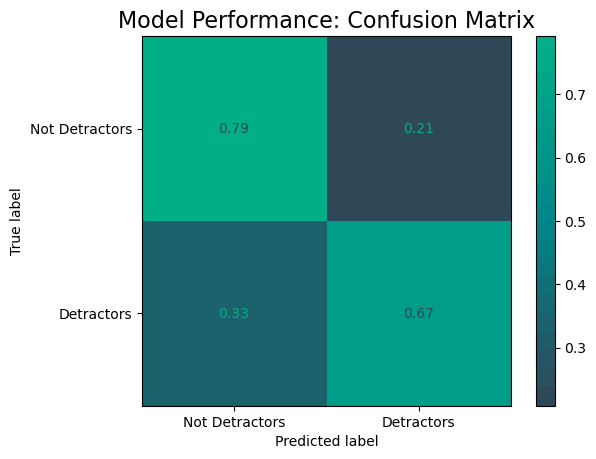

In [267]:
# Recording and displaying the confusion matrix
knn_confusion_matrix = confusion_matrix_display(knn_pipeline, y_test, knn_y_pred)

K-Nearest Neighbor classifier had a negative impact on the model. There is no point in trying to tune it. 

    5) ROC Curve and AUC

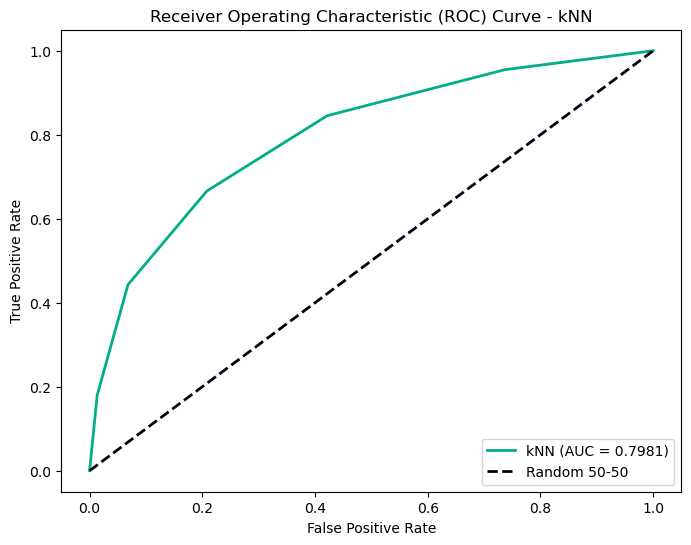

In [268]:
# Plotting the ROC curve for the baseline model
knn_y_pred_proba = knn_pipeline.predict_proba(X_test['original_review'])[:, 1]
auc_knn = plot_roc_curve(y_test, knn_y_pred_proba, model_name=knn_model_name)

In [269]:
# Printing the interpretation
auc_interpretation(auc_knn)

AUC = 0.7981. The model has some predictive power.


In [270]:
# Interpreting AUC:
print('Compared to the last run model: ')
metrics_comparison('AUC', auc_gs, auc_knn)
print()


# # Interpreting AUC:
# print('Compared to the best model so far: ')
# metrics_comparison('AUC', auc_resamp1, auc_prep)

Compared to the last run model: 
AUC decreased from 0.9209 to 0.7981.



In [271]:
# Appending each metric to the lists 
modelnames.append(knn_model_name)
accuracies.append(accuracy_knn)
f1s.append(f1_knn)
recalls.append(recall_knn)
recalls_detractors.append(recall_detractors_knn)
cv_accs.append(cv_knn)
roc_aucs.append(auc_knn)

### 5. c) TfidfVectorizer and Decision Trees

### <u>11th iteration</u>: Decision Trees and Tfidf Vectorizer

Decision trees work well for understanding language because they are easy to interpret and handle the nuances in how words relate. They are good at understanding what words matter most and can deal with different types of word data without much difficulty. 

    1) Fitting and training train data

In [272]:
# Importing the relevant packages
from sklearn.tree import DecisionTreeClassifier

# Defining the pipeline with new classifier, but the same best parameters
dt_pipeline = imblearn.pipeline.Pipeline([
    ('tfidf', TfidfVectorizer(**new_best_tfidf_params)),
    ('us', RandomUnderSampler(sampling_strategy=1, random_state=42)),
    ('classifier', DecisionTreeClassifier())
])

# Fitting the pipeline on training data
dt_pipeline.fit(X_train['original_review'], y_train)

# Making predictions on test data
dt_y_pred = dt_pipeline.predict(X_test['original_review'])

    2) Evaluation Metrics

In [273]:
# Naming the model
dt_model_name = 'DecisionTree'


# Calling the function and recording into the defined values
accuracy_dt, f1_dt, recall_dt, cv_dt = evaluation_metrics(
    y_test,
    dt_y_pred,
    dt_pipeline,
    X_train['original_review'],
    y_train)
    

Accuracy: 0.7195
F1-Score: 0.7332
Recall: 0.7195
Mean Cross-Validated Accuracy: 0.7211


In [274]:
# Comparing the evaluation metrics between undersampled model (best model) and no industry stopwords model 
metrics_comparison('Accuracy', accuracy_gs, accuracy_dt)
metrics_comparison('F1', f1_gs, f1_dt)
metrics_comparison('Recall', recall_gs, recall_dt)
metrics_comparison('Cross-validated Accuracy', cv_gs, cv_dt)

Accuracy decreased from 0.8495 to 0.7195.
F1 decreased from 0.8536 to 0.7332.
Recall decreased from 0.8495 to 0.7195.
Cross-validated Accuracy decreased from 0.8599 to 0.7211.


In [275]:
# Printing the overall summary
print('Decision tree produced slightly better results than kNN but still too low to tune.')

Decision tree produced slightly better results than kNN but still too low to tune.


    3) Classification Report

In [276]:
# Calling the classification report function
class_report_dt, recall_detractors_dt = class_calculation(y_test, dt_y_pred)

Classification Report:
                 precision    recall  f1-score   support

Not Detractors    0.87103   0.72674   0.79237      3773
    Detractors    0.47797   0.69926   0.56782      1350

      accuracy                        0.71950      5123
     macro avg    0.67450   0.71300   0.68010      5123
  weighted avg    0.76745   0.71950   0.73320      5123



    4) Confusion Matrix

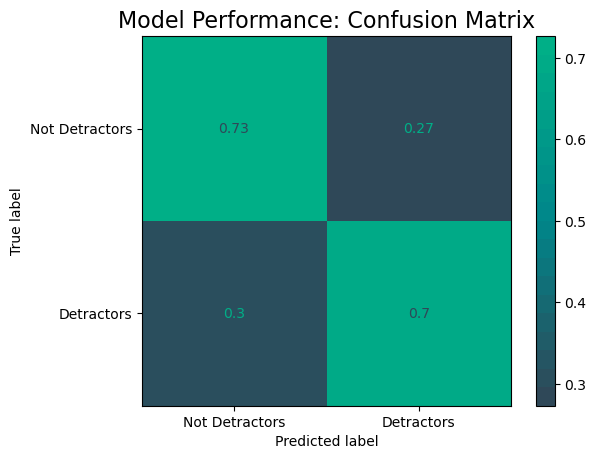

In [277]:
# Recording and displaying the confusion matrix
dt_cfn_matrix = confusion_matrix_display(dt_pipeline, y_test, dt_y_pred)

--------------------CHANGE--------------------
The model correctly identified 47% of positive reviews, but 77% of negative reviews. 

    5) ROC Curve and AUC

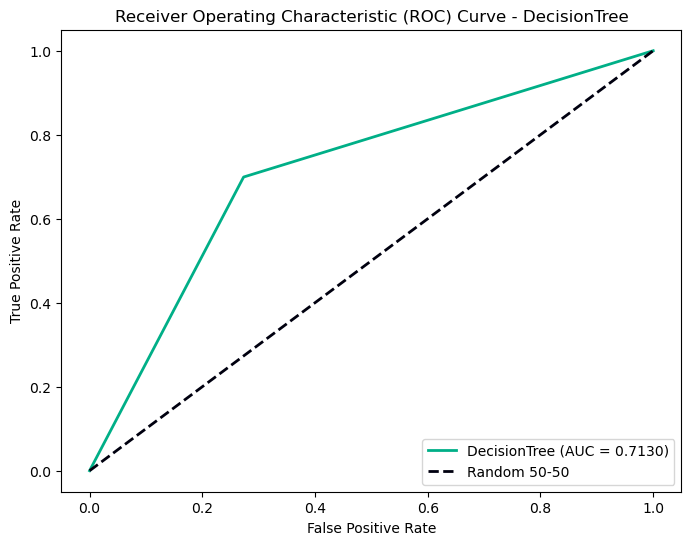

In [278]:
# Plotting the ROC curve for the baseline model
dt_y_pred_proba = dt_pipeline.predict_proba(X_test['original_review'])[:, 1]
auc_dt = plot_roc_curve(y_test, dt_y_pred_proba, model_name=dt_model_name)

In [279]:
# Printing the interpretation
auc_interpretation(auc_dt)

AUC = 0.7130. The model has some predictive power.


In [280]:
# Interpreting AUC:
print('Compared to the last run model: ')
metrics_comparison('AUC', auc_knn, auc_dt)
print()


# # Interpreting AUC:
# print('Compared to the best model so far: ')
# metrics_comparison('AUC', auc_resamp1, auc_prep)

Compared to the last run model: 
AUC decreased from 0.7981 to 0.7130.



In [281]:
# Appending each metric to the lists 
modelnames.append(dt_model_name)
accuracies.append(accuracy_dt)
f1s.append(f1_dt)
recalls.append(recall_dt)
recalls_detractors.append(recall_detractors_dt)
cv_accs.append(cv_dt)
roc_aucs.append(auc_dt)

### 5. d) TfidfVectorizer and Random Forest 

### <u>12th iteration</u>: RandomForestClassifierTuning Tfidf Vectorizer

    1) Fitting and training on train data

Random Forest classifiers can be thought of as an extension of multiple decision trees working together together to understand language text.Let's see if, by using the best TFIDF parameters with another classifier, I can improve further these predictions.


In [282]:
# Importing the relevant package
from sklearn.ensemble import RandomForestClassifier

# Defining the pipeline with the fixed tfidf parameters and RandomForestClassifier
rf_pipeline = imblearn.pipeline.Pipeline([
    ('tfidf', TfidfVectorizer(**new_best_tfidf_params)),
    ('us', RandomUnderSampler(sampling_strategy=1, random_state=42)),
    ('classifier', RandomForestClassifier())
])

# Fitting the pipeline on training data
rf_pipeline.fit(X_train['original_review'], y_train)

# Making predictions on test data
rf_y_pred = rf_pipeline.predict(X_test['original_review'])

    2) Evaluation Metrics

In [283]:
# Naming the model and calling the function to evaluate it
rf_model_name = 'RandomForest'


# Calling the function and recording into the defined values
accuracy_rf, f1_rf, recall_rf, cv_rf = evaluation_metrics(
    y_test,
    rf_y_pred,
    rf_pipeline,
    X_train['original_review'],
    y_train
)

Accuracy: 0.8417
F1-Score: 0.8462
Recall: 0.8417
Mean Cross-Validated Accuracy: 0.8518


The overall scores increased, recording the highest F1 Score reached. 
The model still has difficulty identifying positive reviews due to the dataset imbalance. 

In [284]:
# Comparing the evaluation metrics between the last model and the new one
metrics_comparison('Accuracy', accuracy_dt, accuracy_rf)
metrics_comparison('F1', f1_dt, f1_rf)
metrics_comparison('Recall', recall_dt, recall_rf)
metrics_comparison('Cross-validated Accuracy', cv_dt, cv_rf)

Accuracy improved from 0.7195 to 0.8417.
F1 improved from 0.7332 to 0.8462.
Recall improved from 0.7195 to 0.8417.
Cross-validated Accuracy improved from 0.7211 to 0.8518.


In [285]:
# Printing the overall summary
print('Once again, the best model remained the resampled one applying the model on the fully preprocessed reviews did not improve its predictions.')

Once again, the best model remained the resampled one applying the model on the fully preprocessed reviews did not improve its predictions.


    3) Classification Report

In [286]:
# Calling the classification report function
rf_class_report, recall_detractors_rf = class_calculation(y_test, rf_y_pred)

Classification Report:
                 precision    recall  f1-score   support

Not Detractors    0.92557   0.85370   0.88818      3773
    Detractors    0.66403   0.80815   0.72903      1350

      accuracy                        0.84169      5123
     macro avg    0.79480   0.83092   0.80861      5123
  weighted avg    0.85665   0.84169   0.84625      5123



    4) Confusion Matrix

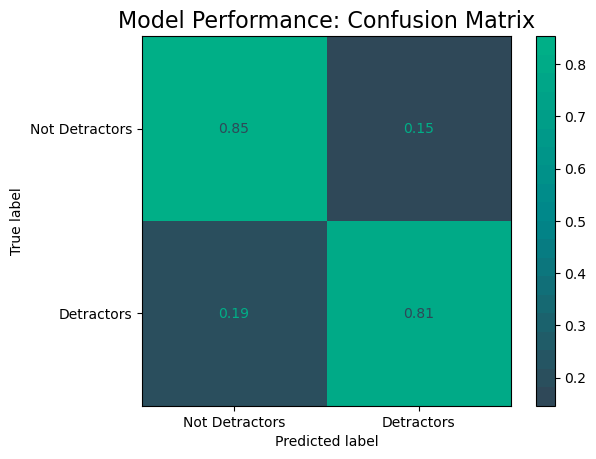

In [287]:
# Recording and displaying the confusion matrix
rf_confusion_matrix = confusion_matrix_display(rf_pipeline, y_test, rf_y_pred)

    5) ROC Curve and AUC

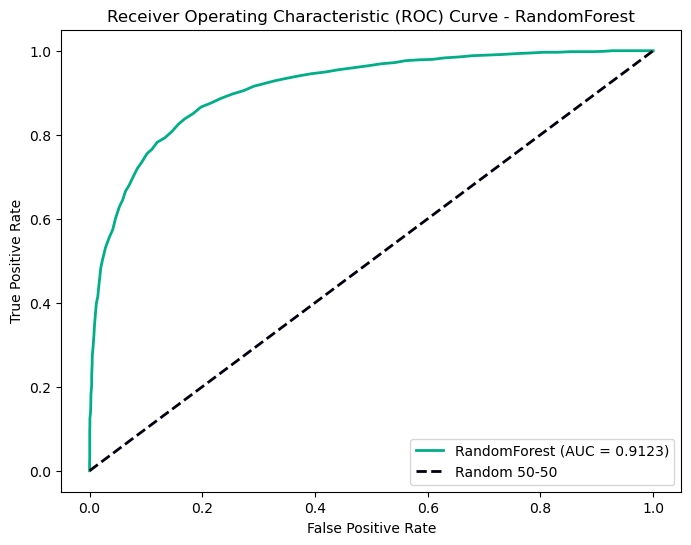

In [288]:
# Plotting the ROC curve for the baseline model
rf_y_pred_proba = rf_pipeline.predict_proba(X_test['original_review'])[:, 1]
auc_rf = plot_roc_curve(y_test, rf_y_pred_proba, model_name=rf_model_name)

In [289]:
# Printing the interpretation
auc_interpretation(auc_rf)

AUC = 0.9123. The model has a great predictive power.


In [290]:
# Interpreting AUC:
print('Compared to the last run model: ')
metrics_comparison('AUC', auc_dt, auc_rf)
print()


# # Interpreting AUC:
# print('Compared to the best model so far: ')
# metrics_comparison('AUC', auc_resamp1, auc_prep)

Compared to the last run model: 
AUC improved from 0.7130 to 0.9123.



In [291]:
# Appending each metric to the lists 
modelnames.append(rf_model_name)
accuracies.append(accuracy_rf)
f1s.append(f1_rf)
recalls.append(recall_rf)
recalls_detractors.append(recall_detractors_rf)
cv_accs.append(cv_rf)
roc_aucs.append(auc_rf)

The RandomForest model resulted in a decent predictive power but is barely providing stronger results than the NaiveBayes model with tuned parameters. 

I will try to take these models to the next levels with Gradient Boosting.

Gradient boosing is a class of ensemble algorithns constructed from decision tree models. Trees are added consecutively and are modified to rectify the errors in prediction made by the models which ran prior. This is why they are called `boosting`.

### 5. e) TfidfVectorizer and Gradient Boosting

### <u>13th iteration</u>: Gradient Boosting Tfidf Vectorizer

    1) Fitting and training on train data

The previous model was a bit computationally expensive. Let's see if the simpler K-Nearest Neighbor classifier would improve on that end. Nevertheless, kNN makes predictions based on what similar cases around it suggest so there is a risk it captures more noise created by the imbalanced dataset, despite the undersampled negative reviews.

In [292]:
# Importing the relevant packages
from sklearn.ensemble import GradientBoostingClassifier


# Defining the pipeline with the fixed tfidf parameters and GradientBoostingClassifier
gb_pipeline = imblearn.pipeline.Pipeline([
    ('tfidf', TfidfVectorizer(**new_best_tfidf_params)),
    ('us', RandomUnderSampler(sampling_strategy=1, random_state=42)),
    ('classifier', GradientBoostingClassifier()) 
])

# Fitting the pipeline on training data
gb_pipeline.fit(X_train['original_review'], y_train)

# Making predictions on test data
gb_y_pred = gb_pipeline.predict(X_test['original_review'])


    2) Evaluation Metrics

In [293]:
# Naming the model and calling the function to evaluate it
gb_model_name = 'GradientBoosting'


# Calling the function and recording into the defined values
accuracy_gb, f1_gb, recall_gb, cv_gb = evaluation_metrics(
    y_test,
    gb_y_pred,
    gb_pipeline,
    X_train['original_review'],
    y_train
)


Accuracy: 0.8192
F1-Score: 0.8261
Recall: 0.8192
Mean Cross-Validated Accuracy: 0.8194


In [294]:
# Comparing the evaluation metrics between undersampled model (best model) and no industry stopwords model 
metrics_comparison('Accuracy', accuracy_rf, accuracy_gb)
metrics_comparison('F1', f1_rf, f1_gb)
metrics_comparison('Recall', recall_rf, recall_gb)
metrics_comparison('Cross-validated Accuracy', cv_rf, cv_gb)

Accuracy decreased from 0.8417 to 0.8192.
F1 decreased from 0.8462 to 0.8261.
Recall decreased from 0.8417 to 0.8192.
Cross-validated Accuracy decreased from 0.8518 to 0.8194.


In [295]:
# Printing the overall summary
print('Change this.')

Change this.


    3) Classification Report

In [296]:
# Calling the function
gb_class_report, recall_detractors_gb = class_calculation(y_test, gb_y_pred)

Classification Report:
                 precision    recall  f1-score   support

Not Detractors    0.92505   0.82110   0.86998      3773
    Detractors    0.61950   0.81407   0.70359      1350

      accuracy                        0.81925      5123
     macro avg    0.77228   0.81759   0.78678      5123
  weighted avg    0.84453   0.81925   0.82613      5123



    4) Confusion Matrix

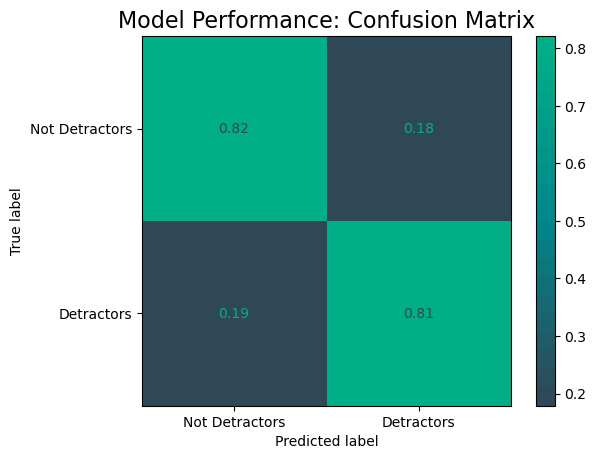

In [297]:
# Recording and displaying the confusion matrix
gb_confusion_matrix = confusion_matrix_display(gb_pipeline, y_test, gb_y_pred)

------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------

The F1 score highly decreased compared to the Random Forest model. Indeed, the model correctly predicted 98% of negative reviews as negative - which makes sense: kNN looks at similar cases to make predictions. 

However the actual positive reviews predicted decreased to 8%. This model cannot be kept at the best one.

------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------

    5) ROC Curve and AUC

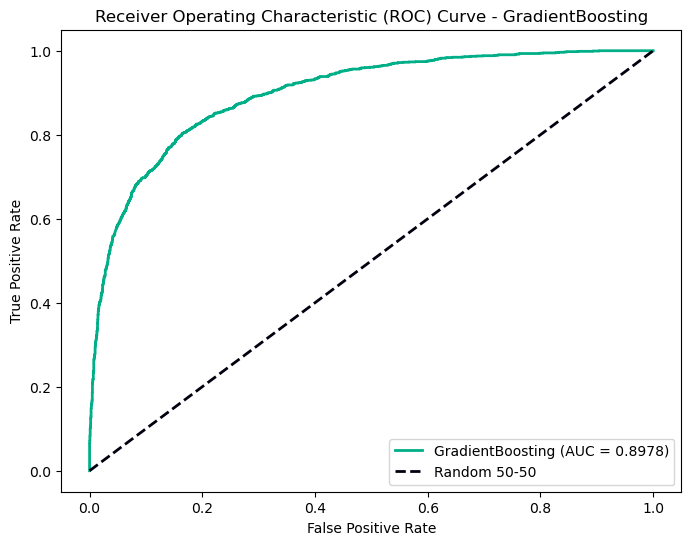

In [298]:
# Plotting the ROC curve for the baseline model
gb_y_pred_proba = gb_pipeline.predict_proba(X_test['original_review'])[:, 1]
auc_gb = plot_roc_curve(y_test, gb_y_pred_proba, model_name=gb_model_name)

In [299]:
# Printing the interpretation
auc_interpretation(auc_gb)

AUC = 0.8978. The model has a good predictive power.


In [300]:
# Interpreting AUC:
print('Compared to the last run model: ')
metrics_comparison('AUC', auc_rf, auc_gb)
print()


Compared to the last run model: 
AUC decreased from 0.9123 to 0.8978.



In [301]:
# Appending each metric to the lists 
modelnames.append(gb_model_name)
accuracies.append(accuracy_gb)
f1s.append(f1_gb)
recalls.append(recall_gb)
recalls_detractors.append(recall_detractors_gb)
cv_accs.append(cv_gb)
roc_aucs.append(auc_gb)

### 5. f) TfidfVectorizer and AdaBoost

### <u>14th iteration</u>: AdaBoost Tfidf Vectorizer

    1) Fitting and training on train data

The previous model was a bit computationally expensive. Let's see if the simpler K-Nearest Neighbor classifier would improve on that end. Nevertheless, kNN makes predictions based on what similar cases around it suggest so there is a risk it captures more noise created by the imbalanced dataset, despite the undersampled negative reviews.

In [302]:
# Importing the relevant packages
from sklearn.ensemble import AdaBoostClassifier


# Defining the pipeline with the fixed tfidf parameters and GradientBoostingClassifier
ab_pipeline = imblearn.pipeline.Pipeline([
    ('tfidf', TfidfVectorizer(**new_best_tfidf_params)),
    ('us', RandomUnderSampler(sampling_strategy=1, random_state=42)),
    ('classifier', AdaBoostClassifier()) 
])

# Fitting the pipeline on training data
ab_pipeline.fit(X_train['original_review'], y_train)

# Making predictions on test data
ab_y_pred = ab_pipeline.predict(X_test['original_review'])


    2) Evaluation Metrics

In [303]:
# Naming the model and calling the function to evaluate it
ab_model_name = 'AdaBoost'


# Calling the function and recording into the defined values
accuracy_ab, f1_ab, recall_ab, cv_ab = evaluation_metrics(
    y_test,
    ab_y_pred,
    ab_pipeline,
    X_train['original_review'],
    y_train
)


Accuracy: 0.8224
F1-Score: 0.8286
Recall: 0.8224
Mean Cross-Validated Accuracy: 0.8176


In [304]:
# Comparing the evaluation metrics between undersampled model (best model) and no industry stopwords model 
metrics_comparison('Accuracy', accuracy_gb, accuracy_ab)
metrics_comparison('F1', f1_gb, f1_ab)
metrics_comparison('Recall', recall_gb, recall_ab)
metrics_comparison('Cross-validated Accuracy', cv_gb, cv_ab)

Accuracy improved from 0.8192 to 0.8224.
F1 improved from 0.8261 to 0.8286.
Recall improved from 0.8192 to 0.8224.
Cross-validated Accuracy decreased from 0.8194 to 0.8176.


In [305]:
# Printing the overall summary
print('Change this.')

Change this.


    3) Classification Report

In [306]:
# Calling the function
ab_class_report, recall_detractors_ab = class_calculation(y_test, ab_y_pred)

Classification Report:
                 precision    recall  f1-score   support

Not Detractors    0.92190   0.82905   0.87301      3773
    Detractors    0.62717   0.80370   0.70455      1350

      accuracy                        0.82237      5123
     macro avg    0.77453   0.81638   0.78878      5123
  weighted avg    0.84423   0.82237   0.82862      5123



    4) Confusion Matrix

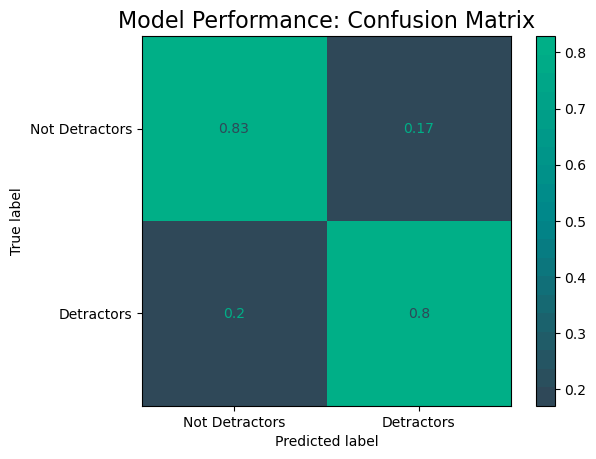

In [307]:
# Recording and displaying the confusion matrix
ab_confusion_matrix = confusion_matrix_display(ab_pipeline, y_test, ab_y_pred)

------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------

The F1 score highly decreased compared to the Random Forest model. Indeed, the model correctly predicted 98% of negative reviews as negative - which makes sense: kNN looks at similar cases to make predictions. 

However the actual positive reviews predicted decreased to 8%. This model cannot be kept at the best one.

------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------

    5) ROC Curve and AUC

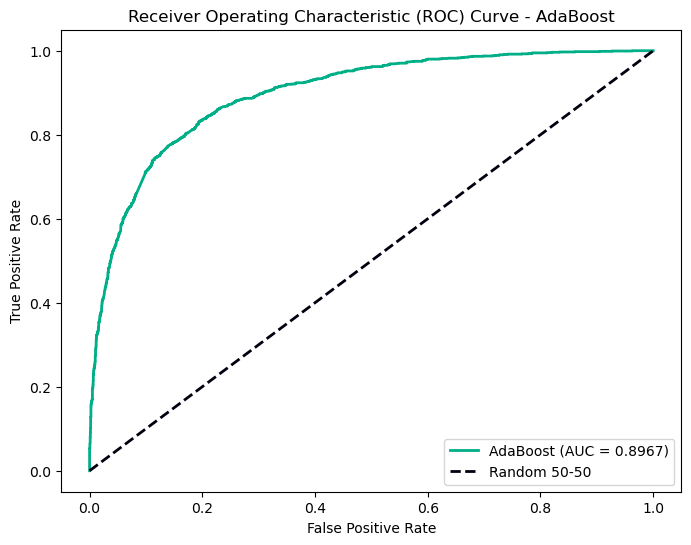

In [308]:
# Plotting the ROC curve for the baseline model
ab_y_pred_proba = ab_pipeline.predict_proba(X_test['original_review'])[:, 1]
auc_ab = plot_roc_curve(y_test, ab_y_pred_proba, model_name=ab_model_name)

In [309]:
# Printing the interpretation
auc_interpretation(auc_ab)

AUC = 0.8967. The model has a good predictive power.


In [310]:
# Interpreting AUC:
print('Compared to the last run model: ')
metrics_comparison('AUC', auc_gb, auc_ab)
print()


# # Interpreting AUC:
# print('Compared to the best model so far: ')
# metrics_comparison('AUC', auc_resamp1, auc_prep)

Compared to the last run model: 
AUC decreased from 0.8978 to 0.8967.



In [311]:
# Appending each metric to the lists 
modelnames.append(ab_model_name)
accuracies.append(accuracy_ab)
f1s.append(f1_ab)
recalls.append(recall_ab)
recalls_detractors.append(recall_detractors_ab)
cv_accs.append(cv_ab)
roc_aucs.append(auc_ab)

### 5. g) TfidfVectorizer and XGBoost

### <u>15th iteration</u>: XGBoost Tfidf Vectorizer

    1) Fitting and training on train data

I am struggling to get an accuracy reaching higher results than 77% with the previous classifiers. I would like to tune them but before doing so, I will try XGBoost, for its popularity among classifiers algorithms. 


XGBoost, or Extreme Gradient Boosting, is a powerful and efficient machine learning algorithm that belongs to the gradient boosting family, known for its speed, scalability, and ability to handle diverse data types.

In [312]:
# Importing the relevant packages
from xgboost import XGBClassifier


# Defining the pipeline with the fixed tfidf parameters and GradientBoostingClassifier
xgb_pipeline = imblearn.pipeline.Pipeline([
    ('tfidf', TfidfVectorizer(**new_best_tfidf_params)),
    ('us', RandomUnderSampler(sampling_strategy=1, random_state=42)),
    ('classifier', XGBClassifier())  # Change AdaBoostClassifier to XGBClassifier
])

# Fitting the pipeline on training data
xgb_pipeline.fit(X_train['original_review'], y_train)

# Making predictions on test data
xgb_y_pred = xgb_pipeline.predict(X_test['original_review'])


    2) Evaluation Metrics

In [313]:
# Naming the model and calling the function to evaluate it
xgb_model_name = 'XGBoost'


# Calling the function and recording into the defined values
accuracy_xgb, f1_xgb, recall_xgb, cv_xgb = evaluation_metrics(
    y_test,
    xgb_y_pred,
    xgb_pipeline,
    X_train['original_review'],
    y_train
)


Accuracy: 0.8409
F1-Score: 0.8463
Recall: 0.8409
Mean Cross-Validated Accuracy: 0.8471


In [314]:
# Comparing the evaluation metrics between the last model the current one 
metrics_comparison('Accuracy', accuracy_ab, accuracy_xgb)
metrics_comparison('F1', f1_ab, f1_xgb)
metrics_comparison('Recall', recall_ab, recall_xgb)
metrics_comparison('Cross-validated Accuracy', cv_ab, cv_xgb)

# Comparing the evaluation metrics between the last best model the current one
print()
metrics_comparison('Accuracy', accuracy_rs1, accuracy_xgb)
metrics_comparison('F1', f1_rs1, f1_xgb)
metrics_comparison('Recall', recall_rs1, recall_xgb)
metrics_comparison('Cross-validated Accuracy', cv_rs1, cv_xgb)


Accuracy improved from 0.8224 to 0.8409.
F1 improved from 0.8286 to 0.8463.
Recall improved from 0.8224 to 0.8409.
Cross-validated Accuracy improved from 0.8176 to 0.8471.

Accuracy improved from 0.8312 to 0.8409.
F1 improved from 0.8378 to 0.8463.
Recall improved from 0.8312 to 0.8409.
Cross-validated Accuracy improved from 0.8442 to 0.8471.


In [315]:
# Printing the overall summary
print('Change this.')

Change this.


    3) Classification Report

In [316]:
# Calling the function
xgb_class_report, recall_detractors_xgb = class_calculation(y_test, xgb_y_pred)

Classification Report:
                 precision    recall  f1-score   support

Not Detractors    0.93347   0.84416   0.88657      3773
    Detractors    0.65634   0.83185   0.73375      1350

      accuracy                        0.84091      5123
     macro avg    0.79491   0.83800   0.81016      5123
  weighted avg    0.86044   0.84091   0.84630      5123



    4) Confusion Matrix

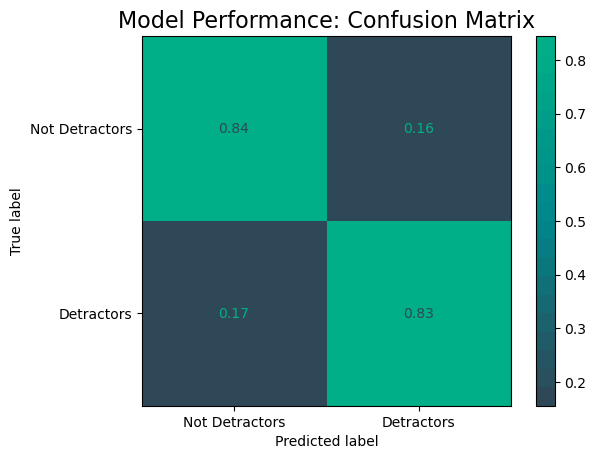

In [317]:
# Recording and displaying the confusion matrix
xgb_confusion_matrix = confusion_matrix_display(xgb_pipeline, y_test, xgb_y_pred)

------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------

The F1 score highly decreased compared to the Random Forest model. Indeed, the model correctly predicted 98% of negative reviews as negative - which makes sense: kNN looks at similar cases to make predictions. 

However the actual positive reviews predicted decreased to 8%. This model cannot be kept at the best one.

------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------

    5) ROC Curve and AUC

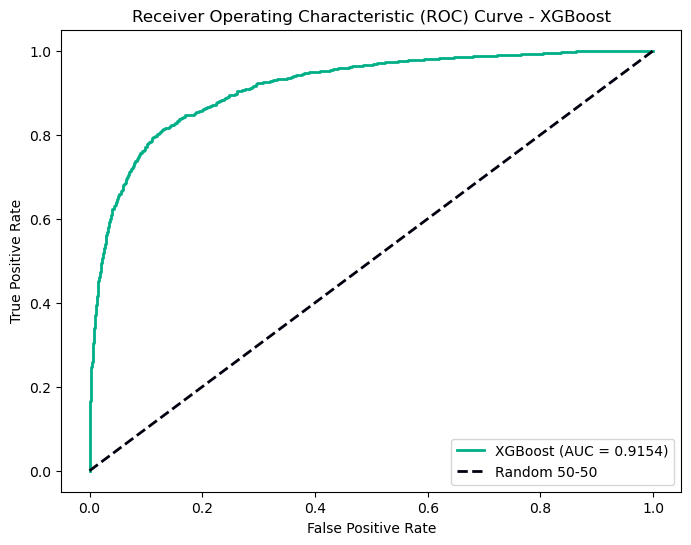

In [318]:
# Plotting the ROC curve for the baseline model
xgb_y_pred_proba = xgb_pipeline.predict_proba(X_test['original_review'])[:, 1]
auc_xgb = plot_roc_curve(y_test, xgb_y_pred_proba, model_name=xgb_model_name)

In [319]:
# Printing the interpretation
auc_interpretation(auc_xgb)

AUC = 0.9154. The model has a great predictive power.


In [320]:
# Interpreting AUC:
print('Compared to the last run model: ')
metrics_comparison('AUC', auc_ab, auc_xgb)
print()


# # Interpreting AUC:
# print('Compared to the best model so far: ')
# metrics_comparison('AUC', auc_resamp1, auc_prep)

Compared to the last run model: 
AUC improved from 0.8967 to 0.9154.



In [321]:
# Appending each metric to the lists 
modelnames.append(xgb_model_name)
accuracies.append(accuracy_xgb)
f1s.append(f1_xgb)
recalls.append(recall_xgb)
recalls_detractors.append(recall_detractors_xgb)
cv_accs.append(cv_xgb)
roc_aucs.append(auc_xgb)

### <u>16th iteration</u>: Tuned XGBoost

    1) Fitting and training on train data

I will try to apply combinatoric grid searching for XGBoost to get the best parameters and try to improve further the model. 

In [322]:
# Defining the parameter grid
param_grid = {
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [3, 5, 7],
#     'classifier__subsample': [0.8, 0.9, 1.0],
}


In [323]:
# Creating the GridSearchCV object
grid_search = GridSearchCV(xgb_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fitting the grid search to the data
grid_search.fit(X_train['original_review'], y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_df=0.7, min_df=3,
                                                        stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    "she's",
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it',
                                                                    "it's",
                                                                    'its',
                                                                    'itself', ...])),
                                       ('us',
                                        RandomUnderS...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.01, 0.1, 0.2],
                         'classifier__max_depth': [3, 5, 7],
                         'classifier__n_estimators': [50, 100, 150]},
             scoring='accuracy')

In [324]:
# Storing the best params
best_xgb_params = grid_search.best_params_

# Storing the best model from the grid search
best_xgb_pipeline = grid_search.best_estimator_

# Printing the best parameters and the corresponding score
print("Best Parameters: ", grid_search.best_params_)


Best Parameters:  {'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__n_estimators': 150}


In [325]:
# Fitting the best pipeline on training data 
best_xgb_pipeline.fit(X_train['original_review'], y_train)

# Making predictions on the test set
best_xgb_y_pred = best_xgb_pipeline.predict(X_test['original_review'])


    2) Evaluation Metrics

In [326]:
# Naming the model and calling the function to evaluate it
xgbtuned_model_name = 'Tuned XGBoost'


# Calling the function and recording into the defined values
accuracy_xgbtuned, f1_xgbtuned, recall_xgbtuned, cv_xgbtuned = evaluation_metrics(
    y_test,
    best_xgb_y_pred,
    best_xgb_pipeline,
    X_train['original_review'],
    y_train
)


Accuracy: 0.8470
F1-Score: 0.8518
Recall: 0.8470
Mean Cross-Validated Accuracy: 0.8492


In [327]:
# Comparing the evaluation metrics between the last model the current one 
metrics_comparison('Accuracy', accuracy_xgb, accuracy_xgbtuned)
metrics_comparison('F1', f1_xgb, f1_xgbtuned)
metrics_comparison('recall', recall_xgb, recall_xgbtuned)
metrics_comparison('Cross-validated Accuracy', cv_xgb, cv_xgbtuned)



Accuracy improved from 0.8409 to 0.8470.
F1 improved from 0.8463 to 0.8518.
recall improved from 0.8409 to 0.8470.
Cross-validated Accuracy improved from 0.8471 to 0.8492.


In [328]:
# Printing the overall summary
print('Change this.')

Change this.


    3) Classification Report

In [329]:
# Calling the function
tunedxgb_class_report, recall_detractors_tunedxgb = class_calculation(y_test, best_xgb_y_pred)

Classification Report:
                 precision    recall  f1-score   support

Not Detractors    0.93457   0.85184   0.89129      3773
    Detractors    0.66805   0.83333   0.74160      1350

      accuracy                        0.84696      5123
     macro avg    0.80131   0.84259   0.81644      5123
  weighted avg    0.86434   0.84696   0.85184      5123



    4) Confusion Matrix

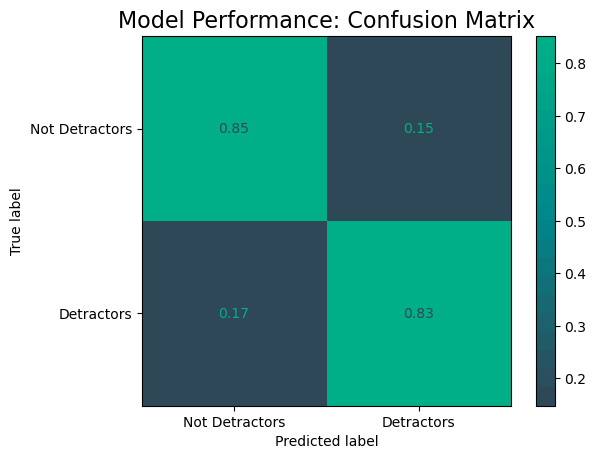

In [330]:
# Recording and displaying the confusion matrix
tunedxgb_confusion_matrix = confusion_matrix_display(best_xgb_pipeline, y_test, best_xgb_y_pred)

------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------

The F1 score highly decreased compared to the Random Forest model. Indeed, the model correctly predicted 98% of negative reviews as negative - which makes sense: kNN looks at similar cases to make predictions. 

However the actual positive reviews predicted decreased to 8%. This model cannot be kept at the best one.

------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------------------------CHANGE------------------

    5) ROC Curve and AUC

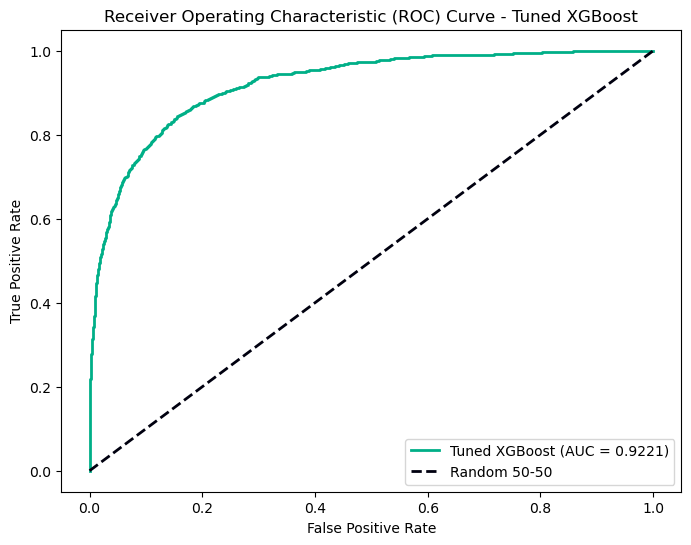

In [331]:
# Plotting the ROC curve for the baseline model
tunedxgb_y_pred_proba = best_xgb_pipeline.predict_proba(X_test['original_review'])[:, 1]
auc_xgbtuned = plot_roc_curve(y_test, tunedxgb_y_pred_proba, model_name=xgbtuned_model_name)

In [332]:
# Printing the interpretation
auc_interpretation(auc_xgbtuned)

AUC = 0.9221. The model has a great predictive power.


In [333]:
# Interpreting AUC:
print('Compared to the last run model: ')
metrics_comparison('AUC', auc_xgb, auc_xgbtuned)
print()


Compared to the last run model: 
AUC improved from 0.9154 to 0.9221.



In [334]:
# Appending each metric to the lists 
modelnames.append(xgbtuned_model_name)
accuracies.append(accuracy_xgbtuned)
f1s.append(f1_xgbtuned)
recalls.append(recall_xgbtuned)
recalls_detractors.append(recall_detractors_tunedxgb)
cv_accs.append(cv_xgbtuned)
roc_aucs.append(auc_xgbtuned)

<a id='evaluation'></a>

## 6. Evaluation

### 6. a) Final Model and Classification Metrics

In [335]:
# Verifying that all lists have the same size
print(len(modelnames))
print()
print(len(accuracies))
print()
print(len(f1s))
print()
print(len(recalls))
print()
print(len(recalls_detractors))
print()
print(len(cv_accs))
print()
print(len(roc_aucs))
print()

16

16

16

16

16

16

16



In [336]:
# Creating a DataFrame with stored best scores 

models_results = {
    'models': modelnames,
    'accuracy': accuracies,
    'f1': f1s,
    'recall': recalls,
    'recall_detractors': recalls_detractors,
    'cross-val_accuracies': cv_accs,
    'ROC-AUCs': roc_aucs
}

overall = pd.DataFrame(models_results)

In [337]:
# Inspecting all iterations' results 
overall

models  accuracy        f1    recall  recall_detractors  \
0             Baseline  0.754636  0.665579  0.754636            0.06963   
1            Resampled  0.884248  0.878426  0.884248            0.65481   
2           Sampling 1  0.831154  0.837767  0.831154            0.65481   
3         No Stopwords  0.831934  0.838196  0.831934            0.83333   
4   Industry Stopwords  0.833106  0.839580  0.833106            0.84444   
5       Full Stopwords  0.834472  0.840474  0.834472            0.83259   
6           Lemmatized  0.828811  0.835766  0.828811            0.84741   
7         Preprocessed  0.827054  0.834132  0.827054            0.84593   
8           NaiveBayes  0.849502  0.853636  0.849502            0.81704   
9                  kNN  0.758735  0.766428  0.758735            0.66593   
10        DecisionTree  0.719500  0.733198  0.719500            0.69926   
11        RandomForest  0.841694  0.846245  0.841694            0.80815   
12    GradientBoosting  0.819247  0.826132  0.819247            0.81407   
13            AdaBoost  0.822370  0.828618  0.822370            0.80370   
14             XGBoost  0.840914  0.846298  0.840914            0.83185   
15       Tuned XGBoost  0.846965  0.851845  0.846965            0.83333   

    cross-val_accuracies  ROC-AUCs  
0               0.750716  0.911003  
1               0.883589  0.927415  
2               0.844221  0.919755  
3               0.846628  0.918632  
4               0.845977  0.920165  
5               0.848060  0.919093  
6               0.840251  0.918153  
7               0.840381  0.917364  
8               0.859903  0.920933  
9               0.774857  0.798136  
10              0.721107  0.713001  
11              0.851769  0.912321  
12              0.819364  0.897826  
13              0.817607  0.896658  
14              0.847150  0.915410  
15              0.849232  0.922093

In [338]:
# Storing the maximum recall detractors value and its index
max_recall_detrac = max(recalls_detractors)
max_recall_index_detrac = recalls_detractors.index(max_recall_detrac)

In [339]:
# Printing metrics for max recall index
overall.iloc[max_recall_index_detrac]

models                  Lemmatized
accuracy                  0.828811
f1                        0.835766
recall                    0.828811
recall_detractors          0.84741
cross-val_accuracies      0.840251
ROC-AUCs                  0.918153
Name: 6, dtype: object

In [340]:
# # Storing both recalls the columns I wanted to average
both_recalls = ['recall', 'recall_detractors']

# # Calculate the average for each row
overall['average_both_recalls'] = overall[both_recalls].mean(axis=1)

In [341]:
# overall

In [342]:
# Storing the maximum recall for both recalls and its index
max_both_recalls = max(both_recalls)
max_both_recalls_index = both_recalls.index(max_both_recalls)

In [343]:
# Printing metrics for max recall index
overall.iloc[max_both_recalls_index]

models                  Resampled
accuracy                 0.884248
f1                       0.878426
recall                   0.884248
recall_detractors         0.65481
cross-val_accuracies     0.883589
ROC-AUCs                 0.927415
average_both_recalls     0.769529
Name: 1, dtype: object

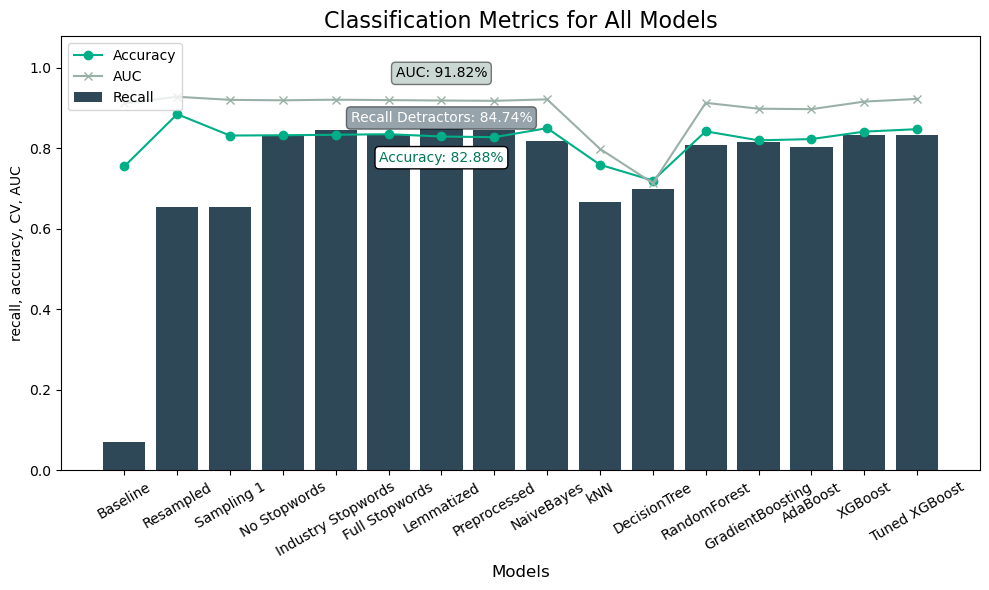

In [344]:
# Creating a bar chart to review all

#  Creating a bar chart for recall
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

# plt.figure(figsize=(10, 6))
plt.bar(overall['models'], overall['recall_detractors'], color='#2F4858', label='Recall')

# Creating line plots for Log Loss and accuracy
plt.plot(overall['models'], overall['accuracy'], marker='o', color='#00AF87', label='Accuracy')
# plt.plot(overall['models'], overall['f1'], marker='x', color='#00A4EF', label='F1')
plt.plot(overall['models'], overall['ROC-AUCs'], marker='x', color='#99B0A7', label='AUC')


# Setting labels and title
plt.xlabel('Models', fontsize=12)
plt.xticks(rotation=30)

plt.ylabel('recall, accuracy, CV, AUC')


    
# Annotating the last index of each category
plt.annotate(f'Recall Detractors: {recalls_detractors[max_recall_index_detrac] * 100:.2f}%', (modelnames[max_recall_index_detrac], recalls_detractors[max_recall_index_detrac] + 0.01), ha='center', va='bottom', color='white', bbox=dict(boxstyle='round', facecolor='#2F4858', alpha=0.5))
plt.annotate(f'Accuracy: {accuracies[max_recall_index_detrac] * 100:.2f}%', (modelnames[max_recall_index_detrac], overall['accuracy'][max_recall_index_detrac] - 0.07), ha='center', va='bottom', color='#007955', bbox=dict(boxstyle='round', facecolor='white', alpha=1))
plt.annotate(f'AUC: {roc_aucs[max_recall_index_detrac] * 100:.2f}%', (modelnames[max_recall_index_detrac], overall['ROC-AUCs'][max_recall_index_detrac] + 0.05), ha='center', va='bottom', color='black', bbox=dict(boxstyle='round', facecolor='#99B0A7', alpha=0.5))
    
# Defining the max value of y 
max_y = max(overall[['ROC-AUCs', 'recall_detractors']].max())
plt.ylim(0, max_y  + 0.15)
plt.title('Classification Metrics for All Models', fontsize=16)

# Displaying the legend
plt.legend(loc='upper left')

# Saving the plot as a PNG with a transparent background
plt.savefig('images/final_model_names.png', transparent=True)

# Showing the plot
plt.tight_layout()
plt.show()

<u>Summarizing the best classification modeling</u>

In [345]:
top_5_models = overall.nlargest(5, 'recall_detractors')

In [346]:
# Verifying the 4 different classifiers 
top_5_models

models  accuracy        f1    recall  recall_detractors  \
6           Lemmatized  0.828811  0.835766  0.828811            0.84741   
7         Preprocessed  0.827054  0.834132  0.827054            0.84593   
4   Industry Stopwords  0.833106  0.839580  0.833106            0.84444   
3         No Stopwords  0.831934  0.838196  0.831934            0.83333   
15       Tuned XGBoost  0.846965  0.851845  0.846965            0.83333   

    cross-val_accuracies  ROC-AUCs  average_both_recalls  
6               0.840251  0.918153              0.838111  
7               0.840381  0.917364              0.836492  
4               0.845977  0.920165              0.838773  
3               0.846628  0.918632              0.832632  
15              0.849232  0.922093              0.840147

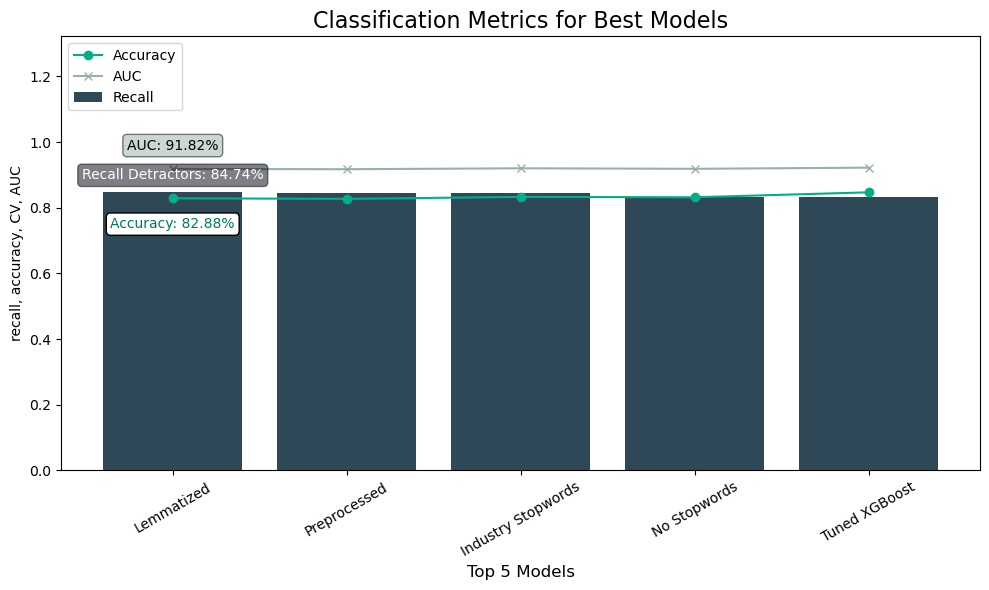

In [347]:
# Creating a bar chart to review top 5 models

#  Creating a bar chart for recall
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

# plt.figure(figsize=(10, 6))
plt.bar(top_5_models['models'], top_5_models['recall_detractors'], color='#2F4858', label='Recall')

# Creating line plots for Log Loss and accuracy
plt.plot(top_5_models['models'], top_5_models['accuracy'], marker='o', color='#00AF87', label='Accuracy')
# plt.plot(top_5_models['models'], top_5_models['f1'], marker='x', color='#00A4EF', label='F1')
plt.plot(top_5_models['models'], top_5_models['ROC-AUCs'], marker='x', color='#99B0A7', label='AUC')


# Setting labels and title
plt.xlabel('Top 5 Models', fontsize=12)
plt.xticks(rotation=30)

plt.ylabel('recall, accuracy, CV, AUC')


    
# Annotating the last index of each category
plt.annotate(f'Recall Detractors: {recalls_detractors[max_recall_index_detrac] * 100:.2f}%', (modelnames[max_recall_index_detrac], recalls_detractors[max_recall_index_detrac] + 0.03), ha='center', va='bottom', color='white', bbox=dict(boxstyle='round', facecolor='#00000F', alpha=0.5))
plt.annotate(f'Accuracy: {accuracies[max_recall_index_detrac] * 100:.2f}%', (modelnames[max_recall_index_detrac], top_5_models['accuracy'][max_recall_index_detrac] - 0.1), ha='center', va='bottom', color='#007955', bbox=dict(boxstyle='round', facecolor='white', alpha=1))
plt.annotate(f'AUC: {roc_aucs[max_recall_index_detrac] * 100:.2f}%', (modelnames[max_recall_index_detrac], top_5_models['ROC-AUCs'][max_recall_index_detrac] + 0.05), ha='center', va='bottom', color='black', bbox=dict(boxstyle='round', facecolor='#99B0A7', alpha=0.5))
    
# Defining the max value of y 
max_y = max(top_5_models[['ROC-AUCs', 'recall_detractors']].max())
plt.ylim(0, max_y  + 0.4)
plt.title('Classification Metrics for Best Models', fontsize=16)

# Displaying the legend
plt.legend(loc='upper left')

# Saving the plot as a PNG with a transparent background
plt.savefig('images/top_models.png', transparent=True)

# Showing the plot
plt.tight_layout()
plt.show()

In [348]:
print(f'All top 5 models resulted in very close results. The {modelnames[max_recall_index_detrac]} model recorded the higest \
results for recall specifically for reviews from detractors, which is the goal for predictions.')

All top 5 models resulted in very close results. The Lemmatized model recorded the higest results for recall specifically for reviews from detractors, which is the goal for predictions.


In [349]:
# Storing the best model in the associated variable
# best_model = rf_pipeline

In [350]:
# # Viewing the best parameters defined by Combinatoric Grid Searching 
# best_tfidf_params = new_best_tfidf_params
# print(list(best_tfidf_params.items())[:])

### 6. b) Model Performance

    2) Evaluation Metrics

* Train data

In [351]:
# Naming the model and calling the function to evaluate it
best_model_name = modelnames[max_recall_index_detrac]
best_model = pipeline_lemm

# Reminding the evaluation metrics for the model
print(f'Evaluation Metrics on Train Data for {best_model_name} model.')

print(f'Accuracy: {overall.iloc[max_recall_index_detrac]["accuracy"]:.4f}')
print(f'F1-Score: {overall.iloc[max_recall_index_detrac]["f1"]:.4f}') 
print(f'Recall: {overall.iloc[max_recall_index_detrac]["recall"]:.4f}')
print(f'Recall Detractors: {overall.iloc[max_recall_index_detrac]["recall_detractors"]:.4f}')
print(f'Mean Cross-Validated Accuracy: {overall.iloc[max_recall_index_detrac]["cross-val_accuracies"]:.4f}')


Evaluation Metrics on Train Data for Lemmatized model.
Accuracy: 0.8288
F1-Score: 0.8358
Recall: 0.8288
Recall Detractors: 0.8474
Mean Cross-Validated Accuracy: 0.8403


* Test data

As I have evaluated the models, I will run our function again. The same results are expected for all metrics, only the cross-validated accuracy should change as this one will be evaluated on the test, unseen data.

In [352]:
print(f'Evaluation Metrics on Unseen Data for {best_model_name} model.')
print()

# Calculating predictions using this model
best_y_pred = best_model.predict(X_test['lemmatized_review'])

# Calling the function and recording into the defined values
accuracy_best_test, recall_best_test, f1_best_test, cv_best_test = evaluation_metrics(
    y_test,
    best_y_pred,
    best_model,
    X_test['lemmatized_review'],
    y_test
)

Evaluation Metrics on Unseen Data for Lemmatized model.

Accuracy: 0.8288
F1-Score: 0.8358
Recall: 0.8288
Mean Cross-Validated Accuracy: 0.8501


    3) Classification Report

In [353]:
# Calling the function
best_class_report, recall_detractors_best = class_calculation(y_test, best_y_pred)

Classification Report:
                 precision    recall  f1-score   support

Not Detractors    0.93773   0.82216   0.87615      3773
    Detractors    0.63030   0.84741   0.72291      1350

      accuracy                        0.82881      5123
     macro avg    0.78401   0.83478   0.79953      5123
  weighted avg    0.85672   0.82881   0.83577      5123



    4) Confusion Matrix

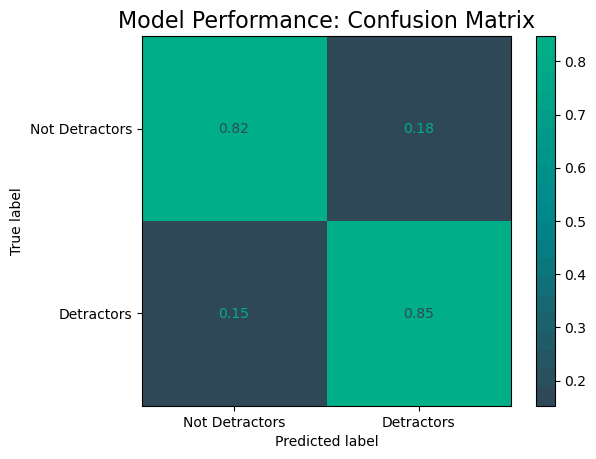

In [354]:
# Recording and displaying the confusion matrix
best_confusion_matrix = confusion_matrix_display(best_model, y_test, best_y_pred)

The classification report and confusion matrix summarize the evaluation of the model's performance on predicting sentiment for reviews related to technology brands (here, Google and Apple) during the SXSW conference. 

The model performs better on predicting *negative* sentiment reviews compared to *positive* sentiment reviews, and this is reflected in all scores. 
F1 is the highest recorded among all models. This score is particularly useful in this dataset, as it is imbalanced, and because it considers both false positives and false negatives. 
The overall weighted accuracy for this model is slightly below 70%. 


Looking at the details by metric: 

<u>F1-Score</u>:
F1-score is the harmonic mean of recall and recall. It was defined as the main metric for this project, as the cost of false negative and false positive was similar, in the sense that both positive and negative reviews need to be accurately predicted. 

The average weighted score recorded for F1 for the random forest model was the highest recorded, despite a larger disparity between F1 score for positive reviews and for negative reviews are more accurately predicted than positive reviews, which provides better scores for negative reviews than positive on all fronts, F1 being one of them. 

<u>recall</u>:
recall measures the accuracy of the positive predictions made by the model. recall focuses on minimizing false positives. A high recall indicates that when the model predicts a positive class, it is likely to be correct. This balances a lower recall for positive reviews, since about 54% of positive reviews predicted as positive, are likely to be correctly identified as such. 

<u>Recall</u>:
Recall measures the ability of the model to capture all the positive instances in the dataset (true positives). Once again, negative reviews are more accurately predicted than positive ones. This can be seen on the confusion matrix on the top left corner. 83% of negative reviews are correctly predicted, while less than 41% of positive reviews are correctly predicted. 

<u>Accuracy</u>:
Finally, accuracy measures the overall correctness of the model predictions. Close to 70% of all reviews were correctly identified.

<a id='findings_n_recommendations'></a>

## 7. Findings & Recommendations

### 7. a) Most Important Features

In [355]:
# Defining a colormap specifically for the top features bar graph
# custom_colors = ['#CCCEC5', '#B3A6A4', '#8A7E7C', '#635856', '#3F3533']

# n_bins = 200

# # Creating the custom colormap
# features_cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_colors, N=n_bins)

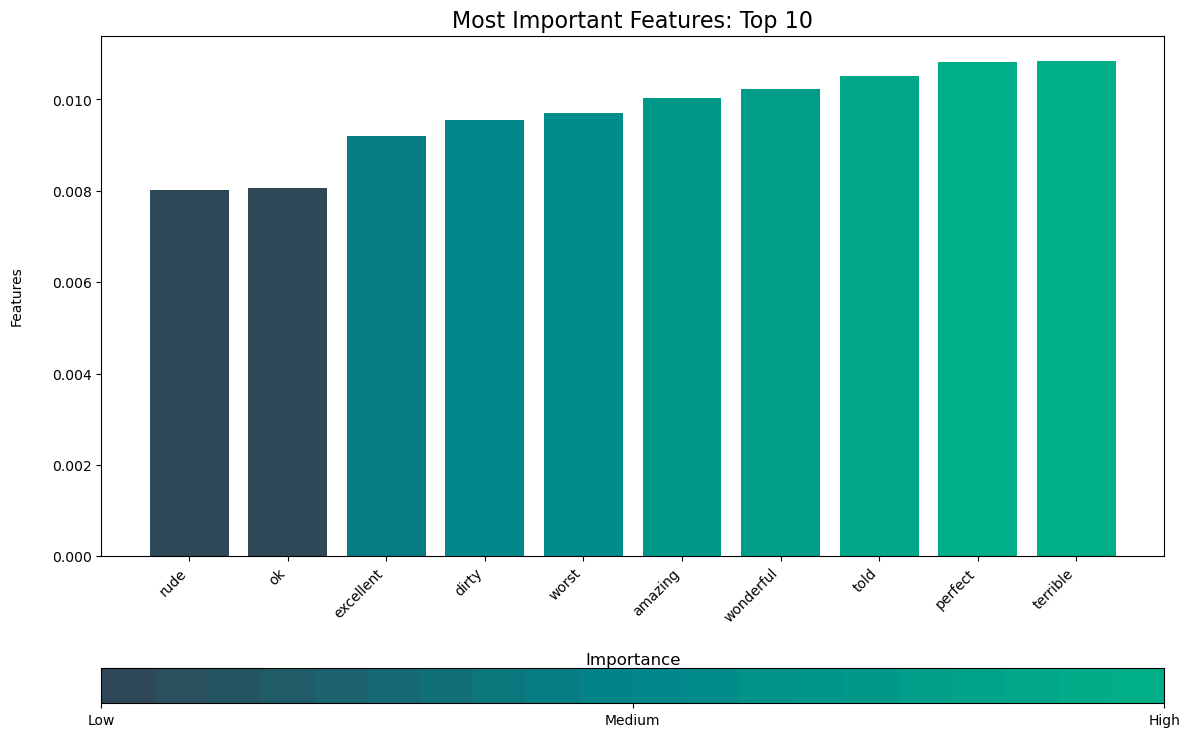

In [356]:
from matplotlib.cm import ScalarMappable


def plot_top_feature_importances(pipeline, top_n):
    # Accessing the classifier instance from the pipeline
    classifier = pipeline.named_steps['classifier']

    # Getting the feature names from the vectorizer
    feature_names = pipeline.named_steps['tfidf'].get_feature_names_out()

    # Getting the feature importances
    feature_importances = classifier.feature_importances_

    # Sorting feature importances in descending order and get the corresponding indices
    sorted_indices = np.argsort(feature_importances)[::-1]

    # Selecting the top 'top_n' features
    top_indices = sorted_indices[:top_n]

    # Sorting the feature names based on the selected top indices
    top_feature_names = feature_names[top_indices]

    # Sorting the feature importances for the selected top features
    top_feature_importances = feature_importances[top_indices]

    # Reverse the order to make it descending
    top_feature_names = top_feature_names[::-1]
    top_feature_importances = top_feature_importances[::-1]

    # Creating a colormap
    cmap = plt.get_cmap(custom_cmap_cnf)

    # Manually normalizing importance values
    normalized_importances = (top_feature_importances - np.min(top_feature_importances)) / (
            np.max(top_feature_importances) - np.min(top_feature_importances))

    # Creating the figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))

    # Using normalized_importances directly for color mapping
    bars = ax.bar(range(top_n), top_feature_importances, align='center', color=cmap(normalized_importances))
    plt.xticks(range(top_n), top_feature_names, rotation=45, ha='right')  # Rotating x-axis labels for better readability
    plt.ylabel('Features', labelpad=20)
    plt.xlabel('Importance', fontsize=12, labelpad=20)
    plt.title('Most Important Features: Top {}'.format(top_n), fontsize=16)

    # Adding a colorbar below the plot
    sm = ScalarMappable(cmap=cmap)
    sm.set_array([])
    colorbar = plt.colorbar(sm, ax=ax, orientation='horizontal', aspect=30)
    # Hide colorbar ticks
    # Defining custom tick positions
    custom_ticks = [0, 0.5, 1]
    custom_ticklabels = ['Low', 'Medium', 'High']
    colorbar.set_ticks(custom_ticks)
    colorbar.set_ticklabels(custom_ticklabels)
    plt.tight_layout()
    # Saving the plot as PNG with a transparent background
    plt.savefig('images/most_important_features.png', transparent=True)

    # Showing the plot
    plt.show()
    return top_feature_names[::-1]


# Calling the function with the best model
top_10_features = plot_top_feature_importances(best_xgb_pipeline, top_n=10)


The most important features for the model help us gather the main themes and make the recommendations previously identified, more precise: 


1. apple store, pop up store, apple pop: 
    <br>Attendees were impressed with the how long lines were becoming to buy the new ipad. 
    <br>This created even more curiosity and people wanted even more to be among the first ones to buy the new iPad 2.
2. iphone app, ipad app: 
    <br> The app created for the SXSW conference was highly appreciated
    <br> It made attendees talk about the brand: this is an easy way to create 'free' communication around your brand
3. google circles, social network: 
    <br> The new social network created by Google created eagerness. 
    <br> Social networks since 2013 have highly evolved and this market has reached its maturity. 
    <br>Instead, the recommendation here would be to build a hashtag to hope to win the new tablet at the event 
4. google party:
    <br>The party was highly enjoyed. To ensure attendees go to the party, mix the previous recommendation with the party: use the hashtag created for the chance to get access to concert, where the tablet will be released. 
    

In [357]:
# Inspecting the returned top 10 features 
top_10_features

array(['terrible', 'perfect', 'told', 'wonderful', 'amazing', 'worst',
       'dirty', 'excellent', 'ok', 'rude'], dtype=object)

The main words that were identified before are confirmed visually here: the main reference is the ipad - which would be our intention for the folding tablet. 

The social network is identified again, which shows the enthusiasm around it. 

Similar approaches show for the apple store, the pop-up store and overall the fact that the launch was major. This is the kind of theme I want for Samsung. 

Nevertheless, without more contact, it is difficult to use this wordcloud on a presentation and understand why this helped us make recommendations, so this visual will not be used. 

### 7. b) Recommendations

To generate buzz around the launch of Samsung's new folding tablet, consider implementing the following key strategies:

1. In-Person Sales and Pop-Up Stores:

    * Offer exclusive early access to SXSW attendees, creating a sense of urgency and desire.
    * Establish pop-up stores within the conference venue to further engage and captivate potential buyers.
    * Foster anticipation by orchestrating lines, enhancing the overall attraction and exclusivity.
    * Innovative Conference App:

2. Develop a cutting-edge mobile app for both phones and tablets, enhancing conference access and engagement.
    * Leverage the app to tap into attendees' creativity, creating a platform for discussion and interaction.

3. Strategic Hashtag Campaign:
    * Take inspiration from the excitement around social network launches, such as Google Circles, by creating a dedicated hashtag.
    * Recognize the evolving landscape of social networks and harness the hashtag to generate excitement and participation.
    * Position the hashtag as a means to win the new tablet, fostering eagerness among the audience.

4. Exclusive Party Integration:

    * Utilize the app to create exclusivity, making it a prerequisite for access to an exclusive party.
    (Blend the party experience with the hashtag campaign, encouraging attendees to use the hashtag for a chance to access the tablet release concert).
    * Strive to surpass the success of the previous year's concert, ensuring the party becomes a highlight of the event.


These refined strategies aim to capture the essence of successful past events, combining physical presence, technological innovation, social media engagement, and exclusive experiences to maximize the impact of the tablet launch at the SXSW conference.

<a id='limits_n_next_steps'></a>

## 8. Limits & Next Steps

Despite providing us a good idea for recommendations, the accuracy and F1 score remain low, I would aim at reaching above 70%. 

To do this in the future I would:
* Synthetically Oversample the Minority class
<br> In addition to undersampling reviews to a certain level, positive reviews should be synthetically oversampled as well to try to draw better results. 

* Stratified Undersampling:
<br> Stratified undersampling may protect from the importance given to single words, by keeping the ratio of words or token

* Hyperparameters Tuning
<br> I searched best parameters for the vectorizer only, but not for the classifier. By changing these, the accuracy, could be improved 
